### Library Import And option data excel fetch

In [1]:
import pandas as pd
from datetime import datetime , time , timedelta
import matplotlib.pyplot as plt
from M_config import fyers
import math

path = r"D:\Programming\PYTHON\Fyersapi\bn option data\DAILY DATA\24_NOV_22.csv"
trade = r"D:\Programming\PYTHON\Finvisia\TRADE DATA EXPIRY\DEC 22\29_DEC_22\TradeOrders-December 29, 2022 7_48_22 PM.csv"

In [2]:
option_df = pd.read_csv(path)
trade_df = pd.read_csv(trade)
# option_df["Date"] = option_df["Date"].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
option_df["Date"] = pd.to_datetime(option_df["Date"])
# option_df.sort_values("Date" , inplace= True)
# option_df = option_df.set_index("Date")
# option_df = option_df.fillna(method = 'ffill')
option_df.head(5)

,Date,39300CE,39300PE,39400CE,39400PE,39500CE,39500PE,39600CE,39600PE,39700CE,...,44100CE,44100PE,44200CE,44200PE,44300CE,44300PE,44400CE,44400PE,44500CE,44500PE
0,2022-11-24 09:15:00,3569.75,1.80,3280.1,1.80,3209.0,1.90,3149.0,2.00,3054.1,...,1.80,1321.9,1.70,1464.6,1.75,1885.95,1.70,1658.8,1.70,1795.1
1,2022-11-24 09:16:00,3569.75,1.75,3280.1,1.70,3209.0,1.75,3149.0,1.75,3054.1,...,1.65,1310.0,1.60,1420.0,1.60,1885.95,1.55,1658.8,1.65,1795.1
2,2022-11-24 09:17:00,3569.75,1.35,3280.1,1.40,3209.0,1.40,3149.0,1.35,3054.1,...,1.75,1310.0,1.65,1420.0,1.60,1885.95,1.55,1658.8,1.60,1795.1
3,2022-11-24 09:18:00,3500.00,1.50,3280.1,1.50,3209.0,1.55,3149.0,1.60,3054.1,...,1.60,1310.0,1.60,1420.0,1.55,1885.95,1.55,1658.8,1.60,1795.1
4,2022-11-24 09:19:00,3500.00,1.55,3280.1,1.55,3209.0,1.55,3149.0,1.70,3054.1,...,1.60,1310.0,1.60,1420.0,1.60,1885.95,1.55,1658.8,1.60,1795.1


### Multiple Fun to get price , straddle price , factor etc

In [3]:
# plot straddle chart
def straddle_price_chart(option_df , strike):
    ch_df = option_df[["Date" , str(strike) + "CE" , str(strike) + "PE"]]
    ch_df["Date"] = (pd.to_datetime(ch_df['Date']).dt.time).astype(str)
    ch_df["straddle_price"] = ch_df[str(strike) + "CE"] + ch_df[str(strike) + "PE"]
    plt.figure(figsize=(20,5))
    plt.plot(ch_df['Date'], ch_df['straddle_price'])
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=90)
    return plt.show()

# return price of a strike for a particular time
def get_price(strike , t_time):
    time_idx = option_df.index[option_df['Date'] == t_time].tolist()[0]
    price = option_df.loc[time_idx , [strike]][0]
    return price

#  return straddle price for a particular time
def get_straddle_price(option_df , strike , s_time):
    time_idx = option_df.index[option_df['Date'] == s_time].tolist()[0]
    straddle_price = option_df.loc[time_idx , [str(strike) + "CE"]][0] + option_df.loc[time_idx , [str(strike) + "PE"]][0]
    return straddle_price

# return factor for a particular time
def get_factor(option_df , spot , s_time):
    atm_strike = strike_diff * round(float(spot) / strike_diff)
    fac = 10000
    for i in range(-3 , 4):
        straddle_price = get_straddle_price(option_df , atm_strike + (100 * i) , s_time)
        
        if straddle_price < fac:
            fac = straddle_price
    return fac

# find strike bases on price or delta for a particular time
def find_strike(option_df , spot , type, s_time , delta = 0 , price = 0):
    atm_strike = strike_diff * round(float(spot) / strike_diff)
    time_idx = option_df.index[option_df['Date'] == s_time].tolist()[0]
    
    if delta != 0 :
        factor = get_factor(option_df , spot , s_time)
        price_to_sell = factor * delta
    else:
        factor = get_factor(option_df , spot , s_time)
        price_to_sell = price
        
#     print("factor" , factor , "Price" , price_to_sell)
    if type == "CE":
        st = 100
    else:
        st = -100

    search = True
    gap = 500
    counter = -2
    while search:
        price = option_df.loc[time_idx , [str(atm_strike + (st * counter)) + type]][0]
        cur_gap = abs(price_to_sell - price)
        if cur_gap < gap:
            counter += 1
            gap = cur_gap
        else:
            strike = atm_strike + (st * (counter - 1))
            price = option_df.loc[time_idx , [str(strike) + type]][0]
            search = False

    return str(strike) + type , factor , price 

#  will taek pos based on price or delta)
def take_pos(spot , s_time , price = 100 , delta = 0):
    ce_strike_to_sell , factor , ce_price = find_strike(option_df , spot , "CE" , s_time , delta = delta , price = price)
    pe_strike_to_sell , factor , pe_price = find_strike(option_df , spot , "PE" , s_time , delta = delta , price = price)
    return factor , ce_strike_to_sell , ce_price , pe_strike_to_sell , pe_price

### Func to append pos taken to pos_df

In [4]:
def append_to_pos_df(df , df1 , time , strike , qty , price):

    if strike in df.index:
        p_strike = df.loc[strike]
        p_qty = p_strike["qty"]
        p_total_buy_qty = p_strike["Total Buy Qty"]
        p_total_sell_qty = p_strike["Total Sell Qty"]
        p_buy_amount = p_strike["Buy Amount"]
        p_sell_amount = p_strike["Sell Amount"]
        df = df.drop(strike)
    else:
        p_qty = 0
        p_total_buy_qty = 0
        p_total_sell_qty = 0
        p_buy_amount = 0
        p_sell_amount = 0
                          
    n_qty = p_qty + qty
    if qty > 0:
        n_total_buy_qty = p_total_buy_qty + qty
        n_total_sell_qty = p_total_sell_qty
        n_buy_amount = p_buy_amount + (qty * price)
        n_sell_amount = p_sell_amount
    
    else:
        n_total_buy_qty = p_total_buy_qty
        n_total_sell_qty = p_total_sell_qty + abs(qty)
        n_sell_amount = p_sell_amount + (abs(qty) * price)
        n_buy_amount = p_buy_amount
        
    try:    
        n_buy_avg_price = n_buy_amount / n_total_buy_qty
    except:
        n_buy_avg_price = 0
    
    try:
        n_sell_avg_price = n_sell_amount / n_total_sell_qty
    except:
        n_sell_avg_price = 0
        
    if n_qty > 0 :
        n_avg_price = n_buy_avg_price
    else:
        n_avg_price = n_sell_avg_price
        
    n_rpnl = min(n_total_buy_qty , n_total_sell_qty) * (n_sell_avg_price - n_buy_avg_price)
#     n_upnl = (n_total_buy_qty - n_total_sell_qty) * (ltp - n_avg_price)
    df = pd.concat([df, pd.DataFrame({"Ltp" : 0 , "qty" :  n_qty , "RPnl" : n_rpnl , " UPnl" : 0 , "Avg Price" : n_avg_price , "Buy Avg Price" : n_buy_avg_price , "Sell Avg Price" : n_sell_avg_price , "Total Buy Qty" : n_total_buy_qty , "Total Sell Qty" : n_total_sell_qty , "Buy Amount" : n_buy_amount , "Sell Amount" : n_sell_amount},index = [strike])])
    df1 = pd.concat([df1 , pd.DataFrame({"Strike" : strike , "Qty" : qty , "Price" : price} , index = [time])])
    return df , df1

### Func to update the pos_df with ltp every minute to get latest ltp

In [5]:
def update_df(pos_df):
    pos_df["Ltp"] = {get_price(i , time) : get_price(i , time) for i in pos_df.index}
    pos_df["Factor Ltp"] = get_factor(option_df , spot , time)
    pos_df["Factor Ltp"] = pos_df[["Ltp" , "Factor Ltp"]].min(axis = 1)
    pos_df["Value"] = pos_df["Factor Ltp"] * pos_df["qty"]
    pos_df["UPnl"] = (pos_df["Total Buy Qty"] - pos_df["Total Sell Qty"]) * (pos_df["Ltp"] - pos_df["Avg Price"])
    return pos_df

### Func to create a df for minute basis pnl , spot , factor etc

In [46]:
def create_min_data(time , spot , factor , delta , df , df1):
#     try:
    mtm = (df["UPnl"] + df["RPnl"]).sum()
    n_q = df["qty"].sum()
    val = df["Value"].sum()
    tv = 0
#     except:
#         mtm = 0
#         n_q = 0
#         val = 0
#         tv = 0
    df1 = pd.concat([df1, pd.DataFrame({"Spot" : spot , "Factor" :  factor , "MTM" : mtm , "Net Qty" : n_q , "Value" : val , "Time Value" : tv , "Delta" : delta},index = [time])])
    return df1

### Func to get Spot Data

In [47]:
def get_data(sym, date):
    data = {"symbol": sym,
            "resolution":"1",
            "date_format":"1",
            "range_from":date,
            "range_to":date,
            "cont_flag":"1"
            }
    data = fyers.history(data)
    return data

### Main Program 

#### This will take pos in strike based on delta or price and will keep on adding pos taken to pos_df where the value based delta calculation is happeing on minute basis and it will hedge the pos base on delta range from 0.25 to -0.25.

In [72]:
pos_df = pd.DataFrame(columns = ["Ltp" , "qty" , "RPnl" , "UPnl" , "Avg Price" , "Buy Avg Price" , "Sell Avg Price" , "Total Buy Qty"  , "Total Sell Qty" , "Buy Amount" , "Sell Amount"])
order_df = pd.DataFrame(columns = ["Strike" , "Qty" , "Price"])
pnl_df = pd.DataFrame(columns = ["Spot" , "Factor" , "MTM" , "Net Qty" , "Value" , "Time Value" , "Delta"])
date = "2022-11-24"
bn_data = get_data("NSE:NIFTYBANK-INDEX" , date)
strike_diff = 100
entry = False
ce_rntry = False
pe_entry = False
qty = 25
lot = 25
min_price_to_sell = 18
min_price_to_buy = 10

#Loopin on option_df

for i in range(370):
    print("=============================================================================================")
    spot = bn_data["candles"][i][4]
    time = option_df.loc[i]["Date"]
    start_time = time.replace(hour = 9 , minute = 20)
    end_time = time.replace(hour = 15 , minute = 25)
    print("Time : " , time)
    print("Spot : " , spot)

# Initial Pos taken

    if end_time >= time >= start_time and entry == False:
        
        factor , ce_strike_to_sell , ce_price , pe_strike_to_sell , pe_price = take_pos(spot , time , price = 0 , delta = 0.5)
        pos_df , order_df = append_to_pos_df(pos_df , order_df , time , ce_strike_to_sell , -qty , ce_price)
        pos_df , order_df = append_to_pos_df(pos_df , order_df , time , pe_strike_to_sell , -qty , pe_price)
        entry = True
        ce_entry = True
        pe_entry = True
        pos_df = update_df(pos_df)
        
    pos_df = update_df(pos_df)
    
# Delta Calculation

    try:
        delta = round((pos_df.loc[pos_df.index.str[-2:] == "CE" , "Value"].sum() - pos_df.loc[pos_df.index.str[-2:] == "PE" , "Value"].sum()) / pos_df["Value"].sum() , 2)
    except :
        delta = 0
    
    display(pos_df)
    print(pos_df[["UPnl" , "RPnl"]].sum())
    print("Delta : " , delta)
    factor = get_factor(option_df , spot , time)
    pnl_df = create_min_data(time , spot , factor , delta , pos_df , pnl_df)
    
# Checking Delta to Hedge
#  Up Side Hedging

    if delta > 0.25:
        
        print("pe",delta)
        
        if pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0) & (pos_df.index.str[-2:] == "CE")].empty is not True:
            print("itm ce buy")
            display(pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0)])
            strike_buy = pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0)].index[0]
            ltp = pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0)]["Ltp"][0]
            pos_df , order_df = append_to_pos_df(pos_df , order_df , time , strike_buy , qty , ltp)
            pos_df , order_df = append_to_pos_df(pos_df , order_df , time , str(int(strike_buy[:-2]) + (strike_diff)) + "CE" , -qty , get_price(str(int(strike_buy[:-2]) + (strike_diff)) + "CE" , time))
            pos_df = update_df(pos_df)

        else:
            print("otm pe sell")
            pe_strike_to_sell , fac , pe_price = find_strike(option_df , spot , "PE", time , delta = 0.50 , price = 0)

            while pe_price < min_price_to_sell:
                pe_strike_to_sell = str(int(pe_strike_to_sell[:-2]) + 100) + "PE"
                pe_price = get_price(pe_strike_to_sell , time)

            pos_df , order_df = append_to_pos_df(pos_df , order_df , time , pe_strike_to_sell , -qty , pe_price)
            
        pos_df = update_df(pos_df)
        
#  Down Side Hedging
    if delta < - 0.25:
        
        print("ce",delta)
        
        if pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0) & (pos_df.index.str[-2:] == "PE")].empty is not True:
            print("itm pe buy")
            display(pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0)])
            strike_buy = pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0)].index[0]
            ltp = pos_df[(pos_df["Ltp"] >= factor) & (pos_df["qty"] < 0)]["Ltp"][0]   
            pos_df , order_df = append_to_pos_df(pos_df , order_df , time , strike_buy , qty , ltp)
            pos_df , order_df = append_to_pos_df(pos_df , order_df , time , str(int(strike_buy[:-2]) - (strike_diff)) + "PE" , -qty , get_price(str(int(strike_buy[:-2]) - (strike_diff)) + "PE" , time))
            pos_df = update_df(pos_df)
            
        else:
            print("otm ce sell")
            ce_strike_to_sell , fac , ce_price = find_strike(option_df , spot , "CE", time , delta = 0.50 , price = 0)

            while ce_price < min_price_to_sell:
                ce_strike_to_sell = str(int(ce_strike_to_sell[:-2]) + 100) + "CE"
                ce_price = get_price(ce_strike_to_sell , time)
        
            pos_df , order_df = append_to_pos_df(pos_df , order_df , time , ce_strike_to_sell , -qty , ce_price)
        pos_df = update_df(pos_df)
        
# Buying sold option whose price is less than min_price_to_buy
    while pos_df[(pos_df["Ltp"] <= min_price_to_buy) & (pos_df["qty"] < 0)].empty is not True:
        display(pos_df[(pos_df["Ltp"] <= min_price_to_buy) & (pos_df["qty"] < 0)])
        strike_buy = pos_df[(pos_df["Ltp"] <= min_price_to_buy) & (pos_df["qty"] < 0)].index[0]
        qty_buy = - pos_df.loc[strike_buy]["qty"]
        ltp = pos_df.loc[strike_buy]["Ltp"] 
        pos_df , order_df = append_to_pos_df(pos_df , order_df , time , strike_buy , qty_buy , ltp)
        buy_val = qty_buy * ltp
        price_sell = buy_val / lot
                                                               
        if strike_buy[-2:] == "CE":
            print("ce buy")
            k = 1
            while get_price(str(int(strike_buy[:-2]) - (k * strike_diff)) + "CE" , time) <= min_price_to_sell:
                k += 1
            new_qty = math.floor(price_sell / get_price(str(int(strike_buy[:-2]) - (k * strike_diff)) + "CE" , time)) * lot
            if new_qty > 0:
                pos_df , order_df = append_to_pos_df(pos_df , order_df , time , str(int(strike_buy[:-2]) - (k * strike_diff)) + "CE" , -new_qty , get_price(str(int(strike_buy[:-2]) - (k * strike_diff)) + "CE" , time))
            pos_df = update_df(pos_df)
            
        if strike_buy[-2:] == "PE":
            print("pe buy")
            k = 1
            while get_price(str(int(strike_buy[:-2]) + (k * strike_diff)) + "PE" , time) <= min_price_to_sell:
                k += 1
            new_qty = math.floor(price_sell / get_price(str(int(strike_buy[:-2]) + (k * strike_diff)) + "PE" , time)) * lot
            if new_qty > 0:
                pos_df , order_df = append_to_pos_df(pos_df , order_df , time , str(int(strike_buy[:-2]) + (k * strike_diff)) + "PE" , -new_qty , get_price(str(int(strike_buy[:-2]) + (k * strike_diff)) + "PE" , time))
            pos_df = update_df(pos_df)  
  

Time :  2022-11-24 09:15:00
Spot :  42799.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value


UPnl    0.0
RPnl    0.0
dtype: float64
Delta :  0
Time :  2022-11-24 09:16:00
Spot :  42814.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value


UPnl    0.0
RPnl    0.0
dtype: float64
Delta :  0
Time :  2022-11-24 09:17:00
Spot :  42812.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value


UPnl    0.0
RPnl    0.0
dtype: float64
Delta :  0
Time :  2022-11-24 09:18:00
Spot :  42812.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value


UPnl    0.0
RPnl    0.0
dtype: float64
Delta :  0
Time :  2022-11-24 09:19:00
Spot :  42804.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value


UPnl    0.0
RPnl    0.0
dtype: float64
Delta :  0
Time :  2022-11-24 09:20:00
Spot :  42803.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,70.2,-25,0.0,-0.0,70.2,0,70.2,0,25,0,1755.0,70.2,-1755.0,0.0
42800PE,79.0,-25,0.0,-0.0,79.0,0,79.0,0,25,0,1975.0,79.0,-1975.0,0.0


UPnl   -0.0
RPnl    0.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 09:21:00
Spot :  42811.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,72.65,-25,0.0,-61.25,70.2,0,70.2,0,25,0,1755.0,72.65,-1816.25,0.0
42800PE,73.00,-25,0.0,150.0,79.0,0,79.0,0,25,0,1975.0,73.00,-1825.0,0.0


UPnl    88.75
RPnl      0.0
dtype: object
Delta :  -0.0
Time :  2022-11-24 09:22:00
Spot :  42811.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,74.3,-25,0.0,-102.5,70.2,0,70.2,0,25,0,1755.0,74.3,-1857.5,0.0
42800PE,71.2,-25,0.0,195.0,79.0,0,79.0,0,25,0,1975.0,71.2,-1780.0,0.0


UPnl    92.5
RPnl     0.0
dtype: object
Delta :  0.02
Time :  2022-11-24 09:23:00
Spot :  42826.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,80.85,-25,0.0,-266.25,70.2,0,70.2,0,25,0,1755.0,80.85,-2021.25,0.0
42800PE,65.95,-25,0.0,326.25,79.0,0,79.0,0,25,0,1975.0,65.95,-1648.75,0.0


UPnl    60.0
RPnl     0.0
dtype: object
Delta :  0.1
Time :  2022-11-24 09:24:00
Spot :  42832.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,87.5,-25,0.0,-432.5,70.2,0,70.2,0,25,0,1755.0,87.5,-2187.5,0.0
42800PE,63.2,-25,0.0,395.0,79.0,0,79.0,0,25,0,1975.0,63.2,-1580.0,0.0


UPnl   -37.5
RPnl     0.0
dtype: object
Delta :  0.16
Time :  2022-11-24 09:25:00
Spot :  42832.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,83.55,-25,0.0,-333.75,70.2,0,70.2,0,25,0,1755.0,83.55,-2088.75,0.0
42800PE,64.75,-25,0.0,356.25,79.0,0,79.0,0,25,0,1975.0,64.75,-1618.75,0.0


UPnl    22.5
RPnl     0.0
dtype: object
Delta :  0.13
Time :  2022-11-24 09:26:00
Spot :  42849.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,102.95,-25,0.0,-818.75,70.2,0,70.2,0,25,0,1755.0,102.95,-2573.75,0.0
42800PE,67.60,-25,0.0,285.0,79.0,0,79.0,0,25,0,1975.0,67.60,-1690.0,0.0


UPnl   -533.75
RPnl       0.0
dtype: object
Delta :  0.21
Time :  2022-11-24 09:27:00
Spot :  42841.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,98.40,-25,0.0,-705.0,70.2,0,70.2,0,25,0,1755.0,98.40,-2460.0,0.0
42800PE,63.15,-25,0.0,396.25,79.0,0,79.0,0,25,0,1975.0,63.15,-1578.75,0.0


UPnl   -308.75
RPnl       0.0
dtype: object
Delta :  0.22
Time :  2022-11-24 09:28:00
Spot :  42838.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,95.4,-25,0.0,-630.0,70.2,0,70.2,0,25,0,1755.0,95.4,-2385.0,0.0
42800PE,63.5,-25,0.0,387.5,79.0,0,79.0,0,25,0,1975.0,63.5,-1587.5,0.0


UPnl   -242.5
RPnl      0.0
dtype: object
Delta :  0.2
Time :  2022-11-24 09:29:00
Spot :  42831.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,91.6,-25,0.0,-535.0,70.2,0,70.2,0,25,0,1755.0,91.6,-2290.0,0.0
42800PE,64.1,-25,0.0,372.5,79.0,0,79.0,0,25,0,1975.0,64.1,-1602.5,0.0


UPnl   -162.5
RPnl      0.0
dtype: object
Delta :  0.18
Time :  2022-11-24 09:30:00
Spot :  42850.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,100.9,-25,0.0,-767.5,70.2,0,70.2,0,25,0,1755.0,100.9,-2522.5,0.0
42800PE,59.4,-25,0.0,490.0,79.0,0,79.0,0,25,0,1975.0,59.4,-1485.0,0.0


UPnl   -277.5
RPnl      0.0
dtype: object
Delta :  0.26
pe 0.26
otm pe sell
Time :  2022-11-24 09:31:00
Spot :  42873.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,114.50,-25,0.0,-1107.5,70.2,0,70.2,0,25,0,1755.0,114.50,-2862.5,0.0
42800PE,53.25,-50,0.0,797.5,69.2,0,69.2,0,50,0,3460.0,53.25,-2662.5,0.0


UPnl   -310.0
RPnl      0.0
dtype: object
Delta :  0.04
Time :  2022-11-24 09:32:00
Spot :  42874.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,123.15,-25,0.0,-1323.75,70.2,0,70.2,0,25,0,1755.0,123.15,-3078.75,0.0
42800PE,52.10,-50,0.0,855.0,69.2,0,69.2,0,50,0,3460.0,52.10,-2605.0,0.0


UPnl   -468.75
RPnl       0.0
dtype: object
Delta :  0.08
Time :  2022-11-24 09:33:00
Spot :  42884.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,123.90,-25,0.0,-1342.5,70.2,0,70.2,0,25,0,1755.0,123.90,-3097.5,0.0
42800PE,50.15,-50,0.0,952.5,69.2,0,69.2,0,50,0,3460.0,50.15,-2507.5,0.0


UPnl   -390.0
RPnl      0.0
dtype: object
Delta :  0.11
Time :  2022-11-24 09:34:00
Spot :  42891.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,132.35,-25,0.0,-1553.75,70.2,0,70.2,0,25,0,1755.0,132.35,-3308.75,0.0
42800PE,48.65,-50,0.0,1027.5,69.2,0,69.2,0,50,0,3460.0,48.65,-2432.5,0.0


UPnl   -526.25
RPnl       0.0
dtype: object
Delta :  0.15
Time :  2022-11-24 09:35:00
Spot :  42891.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,130.35,-25,0.0,-1503.75,70.2,0,70.2,0,25,0,1755.0,130.35,-3258.75,0.0
42800PE,49.45,-50,0.0,987.5,69.2,0,69.2,0,50,0,3460.0,49.45,-2472.5,0.0


UPnl   -516.25
RPnl       0.0
dtype: object
Delta :  0.14
Time :  2022-11-24 09:36:00
Spot :  42883.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,131.95,-25,0.0,-1543.75,70.2,0,70.2,0,25,0,1755.0,131.95,-3298.75,0.0
42800PE,50.00,-50,0.0,960.0,69.2,0,69.2,0,50,0,3460.0,50.00,-2500.0,0.0


UPnl   -583.75
RPnl       0.0
dtype: object
Delta :  0.14
Time :  2022-11-24 09:37:00
Spot :  42903.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,143.95,-25,0.0,-1843.75,70.2,0,70.2,0,25,0,1755.0,143.95,-3598.75,0.0
42800PE,45.65,-50,0.0,1177.5,69.2,0,69.2,0,50,0,3460.0,45.65,-2282.5,0.0


UPnl   -666.25
RPnl       0.0
dtype: object
Delta :  0.22
Time :  2022-11-24 09:38:00
Spot :  42912.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.15,-25,0.0,-2023.75,70.2,0,70.2,0,25,0,1755.0,151.15,-3778.75,0.0
42800PE,45.25,-50,0.0,1197.5,69.2,0,69.2,0,50,0,3460.0,45.25,-2262.5,0.0


UPnl   -826.25
RPnl       0.0
dtype: object
Delta :  0.25
Time :  2022-11-24 09:39:00
Spot :  42908.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.65,-25,0.0,-2011.25,70.2,0,70.2,0,25,0,1755.0,150.65,-3766.25,0.0
42800PE,45.45,-50,0.0,1187.5,69.2,0,69.2,0,50,0,3460.0,45.45,-2272.5,0.0


UPnl   -823.75
RPnl       0.0
dtype: object
Delta :  0.25
Time :  2022-11-24 09:40:00
Spot :  42916.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,156.5,-25,0.0,-2157.5,70.2,0,70.2,0,25,0,1755.0,156.5,-3912.5,0.0
42800PE,46.4,-50,0.0,1140.0,69.2,0,69.2,0,50,0,3460.0,46.4,-2320.0,0.0


UPnl   -1017.5
RPnl       0.0
dtype: object
Delta :  0.26
pe 0.26
otm pe sell
Time :  2022-11-24 09:41:00
Spot :  42914.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,152.20,-25,0.0,-2050.0,70.2,0,70.2,0,25,0,1755.0,152.20,-3805.0,0.0
42800PE,45.95,-50,0.0,1162.5,69.2,0,69.2,0,50,0,3460.0,45.95,-2297.5,0.0
42900PE,82.85,-25,0.0,15.0,83.45,0,83.45,0,25,0,2086.25,82.85,-2071.25,0.0


UPnl   -872.5
RPnl      0.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 09:42:00
Spot :  42900.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,145.35,-25,0.0,-1878.75,70.2,0,70.2,0,25,0,1755.0,145.35,-3633.75,0.0
42800PE,47.00,-50,0.0,1110.0,69.2,0,69.2,0,50,0,3460.0,47.00,-2350.0,0.0
42900PE,85.20,-25,0.0,-43.75,83.45,0,83.45,0,25,0,2086.25,85.20,-2130.0,0.0


UPnl   -812.5
RPnl      0.0
dtype: object
Delta :  -0.1
Time :  2022-11-24 09:43:00
Spot :  42916.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,153.75,-25,0.0,-2088.75,70.2,0,70.2,0,25,0,1755.0,153.75,-3843.75,0.0
42800PE,44.85,-50,0.0,1217.5,69.2,0,69.2,0,50,0,3460.0,44.85,-2242.5,0.0
42900PE,81.35,-25,0.0,52.5,83.45,0,83.45,0,25,0,2086.25,81.35,-2033.75,0.0


UPnl   -818.75
RPnl       0.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 09:44:00
Spot :  42943.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,164.0,-25,0.0,-2345.0,70.2,0,70.2,0,25,0,1755.0,164.0,-4100.0,0.0
42800PE,39.1,-50,0.0,1505.0,69.2,0,69.2,0,50,0,3460.0,39.1,-1955.0,0.0
42900PE,72.9,-25,0.0,263.75,83.45,0,83.45,0,25,0,2086.25,72.9,-1822.5,0.0


UPnl   -576.25
RPnl       0.0
dtype: object
Delta :  0.04
Time :  2022-11-24 09:45:00
Spot :  42943.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,159.60,-25,0.0,-2235.0,70.2,0,70.2,0,25,0,1755.0,159.60,-3990.0,0.0
42800PE,39.10,-50,0.0,1505.0,69.2,0,69.2,0,50,0,3460.0,39.10,-1955.0,0.0
42900PE,73.35,-25,0.0,252.5,83.45,0,83.45,0,25,0,2086.25,73.35,-1833.75,0.0


UPnl   -477.5
RPnl      0.0
dtype: object
Delta :  0.03
Time :  2022-11-24 09:46:00
Spot :  42944.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,162.45,-25,0.0,-2306.25,70.2,0,70.2,0,25,0,1755.0,162.45,-4061.25,0.0
42800PE,38.70,-50,0.0,1525.0,69.2,0,69.2,0,50,0,3460.0,38.70,-1935.0,0.0
42900PE,72.10,-25,0.0,283.75,83.45,0,83.45,0,25,0,2086.25,72.10,-1802.5,0.0


UPnl   -497.5
RPnl      0.0
dtype: object
Delta :  0.04
Time :  2022-11-24 09:47:00
Spot :  42946.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,164.35,-25,0.0,-2353.75,70.2,0,70.2,0,25,0,1755.0,164.35,-4108.75,0.0
42800PE,38.50,-50,0.0,1535.0,69.2,0,69.2,0,50,0,3460.0,38.50,-1925.0,0.0
42900PE,71.55,-25,0.0,297.5,83.45,0,83.45,0,25,0,2086.25,71.55,-1788.75,0.0


UPnl   -521.25
RPnl       0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 09:48:00
Spot :  42951.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,169.40,-25,0.0,-2480.0,70.2,0,70.2,0,25,0,1755.0,169.15,-4228.75,0.0
42800PE,37.35,-50,0.0,1592.5,69.2,0,69.2,0,50,0,3460.0,37.35,-1867.5,0.0
42900PE,69.70,-25,0.0,343.75,83.45,0,83.45,0,25,0,2086.25,69.70,-1742.5,0.0


UPnl   -543.75
RPnl       0.0
dtype: object
Delta :  0.08
Time :  2022-11-24 09:49:00
Spot :  42925.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,156.75,-25,0.0,-2163.75,70.2,0,70.2,0,25,0,1755.0,156.75,-3918.75,0.0
42800PE,40.35,-50,0.0,1442.5,69.2,0,69.2,0,50,0,3460.0,40.35,-2017.5,0.0
42900PE,75.20,-25,0.0,206.25,83.45,0,83.45,0,25,0,2086.25,75.20,-1880.0,0.0


UPnl   -515.0
RPnl      0.0
dtype: object
Delta :  0.0
Time :  2022-11-24 09:50:00
Spot :  42926.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,159.95,-25,0.0,-2243.75,70.2,0,70.2,0,25,0,1755.0,159.95,-3998.75,0.0
42800PE,40.75,-50,0.0,1422.5,69.2,0,69.2,0,50,0,3460.0,40.75,-2037.5,0.0
42900PE,75.00,-25,0.0,211.25,83.45,0,83.45,0,25,0,2086.25,75.00,-1875.0,0.0


UPnl   -610.0
RPnl      0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 09:51:00
Spot :  42915.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.3,-25,0.0,-2177.5,70.2,0,70.2,0,25,0,1755.0,157.3,-3932.5,0.0
42800PE,42.4,-50,0.0,1340.0,69.2,0,69.2,0,50,0,3460.0,42.4,-2120.0,0.0
42900PE,76.6,-25,0.0,171.25,83.45,0,83.45,0,25,0,2086.25,76.6,-1915.0,0.0


UPnl   -666.25
RPnl       0.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 09:52:00
Spot :  42917.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.95,-25,0.0,-2193.75,70.2,0,70.2,0,25,0,1755.0,157.95,-3948.75,0.0
42800PE,42.40,-50,0.0,1340.0,69.2,0,69.2,0,50,0,3460.0,42.40,-2120.0,0.0
42900PE,76.85,-25,0.0,165.0,83.45,0,83.45,0,25,0,2086.25,76.85,-1921.25,0.0


UPnl   -688.75
RPnl       0.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 09:53:00
Spot :  42935.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,164.60,-25,0.0,-2360.0,70.2,0,70.2,0,25,0,1755.0,164.60,-4115.0,0.0
42800PE,39.35,-50,0.0,1492.5,69.2,0,69.2,0,50,0,3460.0,39.35,-1967.5,0.0
42900PE,71.60,-25,0.0,296.25,83.45,0,83.45,0,25,0,2086.25,71.60,-1790.0,0.0


UPnl   -571.25
RPnl       0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 09:54:00
Spot :  42942.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,165.5,-25,0.0,-2382.5,70.2,0,70.2,0,25,0,1755.0,165.5,-4137.5,0.0
42800PE,39.0,-50,0.0,1510.0,69.2,0,69.2,0,50,0,3460.0,39.0,-1950.0,0.0
42900PE,70.8,-25,0.0,316.25,83.45,0,83.45,0,25,0,2086.25,70.8,-1770.0,0.0


UPnl   -556.25
RPnl       0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 09:55:00
Spot :  42949.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,166.15,-25,0.0,-2398.75,70.2,0,70.2,0,25,0,1755.0,166.15,-4153.75,0.0
42800PE,38.50,-50,0.0,1535.0,69.2,0,69.2,0,50,0,3460.0,38.50,-1925.0,0.0
42900PE,70.30,-25,0.0,328.75,83.45,0,83.45,0,25,0,2086.25,70.30,-1757.5,0.0


UPnl   -535.0
RPnl      0.0
dtype: object
Delta :  0.06
Time :  2022-11-24 09:56:00
Spot :  42950.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,168.70,-25,0.0,-2462.5,70.2,0,70.2,0,25,0,1755.0,168.50,-4212.5,0.0
42800PE,38.05,-50,0.0,1557.5,69.2,0,69.2,0,50,0,3460.0,38.05,-1902.5,0.0
42900PE,69.10,-25,0.0,358.75,83.45,0,83.45,0,25,0,2086.25,69.10,-1727.5,0.0


UPnl   -546.25
RPnl       0.0
dtype: object
Delta :  0.07
Time :  2022-11-24 09:57:00
Spot :  42939.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,164.35,-25,0.0,-2353.75,70.2,0,70.2,0,25,0,1755.0,164.35,-4108.75,0.0
42800PE,38.35,-50,0.0,1542.5,69.2,0,69.2,0,50,0,3460.0,38.35,-1917.5,0.0
42900PE,70.30,-25,0.0,328.75,83.45,0,83.45,0,25,0,2086.25,70.30,-1757.5,0.0


UPnl   -482.5
RPnl      0.0
dtype: object
Delta :  0.06
Time :  2022-11-24 09:58:00
Spot :  42930.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,160.6,-25,0.0,-2260.0,70.2,0,70.2,0,25,0,1755.0,160.6,-4015.0,0.0
42800PE,40.0,-50,0.0,1460.0,69.2,0,69.2,0,50,0,3460.0,40.0,-2000.0,0.0
42900PE,72.9,-25,0.0,263.75,83.45,0,83.45,0,25,0,2086.25,72.9,-1822.5,0.0


UPnl   -536.25
RPnl       0.0
dtype: object
Delta :  0.02
Time :  2022-11-24 09:59:00
Spot :  42919.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,156.65,-25,0.0,-2161.25,70.2,0,70.2,0,25,0,1755.0,156.65,-3916.25,0.0
42800PE,40.70,-50,0.0,1425.0,69.2,0,69.2,0,50,0,3460.0,40.70,-2035.0,0.0
42900PE,74.10,-25,0.0,233.75,83.45,0,83.45,0,25,0,2086.25,74.10,-1852.5,0.0


UPnl   -502.5
RPnl      0.0
dtype: object
Delta :  0.0
Time :  2022-11-24 10:00:00
Spot :  42922.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,156.95,-25,0.0,-2168.75,70.2,0,70.2,0,25,0,1755.0,156.95,-3923.75,0.0
42800PE,40.25,-50,0.0,1447.5,69.2,0,69.2,0,50,0,3460.0,40.25,-2012.5,0.0
42900PE,73.75,-25,0.0,242.5,83.45,0,83.45,0,25,0,2086.25,73.75,-1843.75,0.0


UPnl   -478.75
RPnl       0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 10:01:00
Spot :  42933.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,161.35,-25,0.0,-2278.75,70.2,0,70.2,0,25,0,1755.0,161.35,-4033.75,0.0
42800PE,37.60,-50,0.0,1580.0,69.2,0,69.2,0,50,0,3460.0,37.60,-1880.0,0.0
42900PE,69.35,-25,0.0,352.5,83.45,0,83.45,0,25,0,2086.25,69.35,-1733.75,0.0


UPnl   -346.25
RPnl       0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 10:02:00
Spot :  42922.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,155.0,-25,0.0,-2120.0,70.2,0,70.2,0,25,0,1755.0,155.0,-3875.0,0.0
42800PE,39.8,-50,0.0,1470.0,69.2,0,69.2,0,50,0,3460.0,39.8,-1990.0,0.0
42900PE,73.4,-25,0.0,251.25,83.45,0,83.45,0,25,0,2086.25,73.4,-1835.0,0.0


UPnl   -398.75
RPnl       0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 10:03:00
Spot :  42923.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,155.55,-25,0.0,-2133.75,70.2,0,70.2,0,25,0,1755.0,155.55,-3888.75,0.0
42800PE,39.70,-50,0.0,1475.0,69.2,0,69.2,0,50,0,3460.0,39.70,-1985.0,0.0
42900PE,72.55,-25,0.0,272.5,83.45,0,83.45,0,25,0,2086.25,72.55,-1813.75,0.0


UPnl   -386.25
RPnl       0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 10:04:00
Spot :  42919.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.65,-25,0.0,-2036.25,70.2,0,70.2,0,25,0,1755.0,151.65,-3791.25,0.0
42800PE,39.90,-50,0.0,1465.0,69.2,0,69.2,0,50,0,3460.0,39.90,-1995.0,0.0
42900PE,73.70,-25,0.0,243.75,83.45,0,83.45,0,25,0,2086.25,73.70,-1842.5,0.0


UPnl   -327.5
RPnl      0.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 10:05:00
Spot :  42915.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,145.20,-25,0.0,-1875.0,70.2,0,70.2,0,25,0,1755.0,145.20,-3630.0,0.0
42800PE,40.70,-50,0.0,1425.0,69.2,0,69.2,0,50,0,3460.0,40.70,-2035.0,0.0
42900PE,75.05,-25,0.0,210.0,83.45,0,83.45,0,25,0,2086.25,75.05,-1876.25,0.0


UPnl   -240.0
RPnl      0.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 10:06:00
Spot :  42911.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,147.35,-25,0.0,-1928.75,70.2,0,70.2,0,25,0,1755.0,147.35,-3683.75,0.0
42800PE,40.45,-50,0.0,1437.5,69.2,0,69.2,0,50,0,3460.0,40.45,-2022.5,0.0
42900PE,74.40,-25,0.0,226.25,83.45,0,83.45,0,25,0,2086.25,74.40,-1860.0,0.0


UPnl   -265.0
RPnl      0.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 10:07:00
Spot :  42912.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.60,-25,0.0,-2035.0,70.2,0,70.2,0,25,0,1755.0,151.60,-3790.0,0.0
42800PE,38.55,-50,0.0,1532.5,69.2,0,69.2,0,50,0,3460.0,38.55,-1927.5,0.0
42900PE,71.65,-25,0.0,295.0,83.45,0,83.45,0,25,0,2086.25,71.65,-1791.25,0.0


UPnl   -207.5
RPnl      0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 10:08:00
Spot :  42915.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,154.15,-25,0.0,-2098.75,70.2,0,70.2,0,25,0,1755.0,154.15,-3853.75,0.0
42800PE,37.20,-50,0.0,1600.0,69.2,0,69.2,0,50,0,3460.0,37.20,-1860.0,0.0
42900PE,69.40,-25,0.0,351.25,83.45,0,83.45,0,25,0,2086.25,69.40,-1735.0,0.0


UPnl   -147.5
RPnl      0.0
dtype: object
Delta :  0.03
Time :  2022-11-24 10:09:00
Spot :  42936.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,165.60,-25,0.0,-2385.0,70.2,0,70.2,0,25,0,1755.0,157.10,-3927.5,0.0
42800PE,32.55,-50,0.0,1832.5,69.2,0,69.2,0,50,0,3460.0,32.55,-1627.5,0.0
42900PE,62.35,-25,0.0,527.5,83.45,0,83.45,0,25,0,2086.25,62.35,-1558.75,0.0


UPnl   -25.0
RPnl     0.0
dtype: object
Delta :  0.1
Time :  2022-11-24 10:10:00
Spot :  42938.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,161.50,-25,0.0,-2282.5,70.2,0,70.2,0,25,0,1755.0,154.50,-3862.5,0.0
42800PE,32.00,-50,0.0,1860.0,69.2,0,69.2,0,50,0,3460.0,32.00,-1600.0,0.0
42900PE,62.25,-25,0.0,530.0,83.45,0,83.45,0,25,0,2086.25,62.25,-1556.25,0.0


UPnl    107.5
RPnl      0.0
dtype: object
Delta :  0.1
Time :  2022-11-24 10:11:00
Spot :  42935.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,162.00,-25,0.0,-2295.0,70.2,0,70.2,0,25,0,1755.0,155.05,-3876.25,0.0
42800PE,32.35,-50,0.0,1842.5,69.2,0,69.2,0,50,0,3460.0,32.35,-1617.5,0.0
42900PE,62.70,-25,0.0,518.75,83.45,0,83.45,0,25,0,2086.25,62.70,-1567.5,0.0


UPnl    66.25
RPnl      0.0
dtype: object
Delta :  0.1
Time :  2022-11-24 10:12:00
Spot :  42923.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.00,-25,0.0,-2020.0,70.2,0,70.2,0,25,0,1755.0,150.80,-3770.0,0.0
42800PE,34.40,-50,0.0,1740.0,69.2,0,69.2,0,50,0,3460.0,34.40,-1720.0,0.0
42900PE,66.95,-25,0.0,412.5,83.45,0,83.45,0,25,0,2086.25,66.95,-1673.75,0.0


UPnl    132.5
RPnl      0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 10:13:00
Spot :  42915.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.05,-25,0.0,-1996.25,70.2,0,70.2,0,25,0,1755.0,150.05,-3751.25,0.0
42800PE,35.35,-50,0.0,1692.5,69.2,0,69.2,0,50,0,3460.0,35.35,-1767.5,0.0
42900PE,68.25,-25,0.0,380.0,83.45,0,83.45,0,25,0,2086.25,68.25,-1706.25,0.0


UPnl    76.25
RPnl      0.0
dtype: object
Delta :  0.04
Time :  2022-11-24 10:14:00
Spot :  42910.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.9,-25,0.0,-2017.5,70.2,0,70.2,0,25,0,1755.0,150.9,-3772.5,0.0
42800PE,35.2,-50,0.0,1700.0,69.2,0,69.2,0,50,0,3460.0,35.2,-1760.0,0.0
42900PE,68.2,-25,0.0,381.25,83.45,0,83.45,0,25,0,2086.25,68.2,-1705.0,0.0


UPnl    63.75
RPnl      0.0
dtype: object
Delta :  0.04
Time :  2022-11-24 10:15:00
Spot :  42914.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.7,-25,0.0,-2012.5,70.2,0,70.2,0,25,0,1755.0,150.7,-3767.5,0.0
42800PE,34.8,-50,0.0,1720.0,69.2,0,69.2,0,50,0,3460.0,34.8,-1740.0,0.0
42900PE,68.0,-25,0.0,386.25,83.45,0,83.45,0,25,0,2086.25,68.0,-1700.0,0.0


UPnl    93.75
RPnl      0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 10:16:00
Spot :  42919.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,152.0,-25,0.0,-2045.0,70.2,0,70.2,0,25,0,1755.0,152.0,-3800.0,0.0
42800PE,34.7,-50,0.0,1725.0,69.2,0,69.2,0,50,0,3460.0,34.7,-1735.0,0.0
42900PE,67.8,-25,0.0,391.25,83.45,0,83.45,0,25,0,2086.25,67.8,-1695.0,0.0


UPnl    71.25
RPnl      0.0
dtype: object
Delta :  0.05
Time :  2022-11-24 10:17:00
Spot :  42913.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,146.7,-25,0.0,-1912.5,70.2,0,70.2,0,25,0,1755.0,146.7,-3667.5,0.0
42800PE,35.5,-50,0.0,1685.0,69.2,0,69.2,0,50,0,3460.0,35.5,-1775.0,0.0
42900PE,69.3,-25,0.0,353.75,83.45,0,83.45,0,25,0,2086.25,69.3,-1732.5,0.0


UPnl    126.25
RPnl       0.0
dtype: object
Delta :  0.02
Time :  2022-11-24 10:18:00
Spot :  42917.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,149.90,-25,0.0,-1992.5,70.2,0,70.2,0,25,0,1755.0,149.90,-3747.5,0.0
42800PE,34.65,-50,0.0,1727.5,69.2,0,69.2,0,50,0,3460.0,34.65,-1732.5,0.0
42900PE,67.85,-25,0.0,390.0,83.45,0,83.45,0,25,0,2086.25,67.85,-1696.25,0.0


UPnl    125.0
RPnl      0.0
dtype: object
Delta :  0.04
Time :  2022-11-24 10:19:00
Spot :  42914.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,147.50,-25,0.0,-1932.5,70.2,0,70.2,0,25,0,1755.0,147.50,-3687.5,0.0
42800PE,35.25,-50,0.0,1697.5,69.2,0,69.2,0,50,0,3460.0,35.25,-1762.5,0.0
42900PE,68.75,-25,0.0,367.5,83.45,0,83.45,0,25,0,2086.25,68.75,-1718.75,0.0


UPnl    132.5
RPnl      0.0
dtype: object
Delta :  0.03
Time :  2022-11-24 10:20:00
Spot :  42906.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,142.2,-25,0.0,-1800.0,70.2,0,70.2,0,25,0,1755.0,142.2,-3555.0,0.0
42800PE,35.4,-50,0.0,1690.0,69.2,0,69.2,0,50,0,3460.0,35.4,-1770.0,0.0
42900PE,69.5,-25,0.0,348.75,83.45,0,83.45,0,25,0,2086.25,69.5,-1737.5,0.0


UPnl    238.75
RPnl       0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 10:21:00
Spot :  42906.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,144.10,-25,0.0,-1847.5,70.2,0,70.2,0,25,0,1755.0,144.10,-3602.5,0.0
42800PE,35.95,-50,0.0,1662.5,69.2,0,69.2,0,50,0,3460.0,35.95,-1797.5,0.0
42900PE,69.90,-25,0.0,338.75,83.45,0,83.45,0,25,0,2086.25,69.90,-1747.5,0.0


UPnl    153.75
RPnl       0.0
dtype: object
Delta :  0.01
Time :  2022-11-24 10:22:00
Spot :  42919.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.90,-25,0.0,-2017.5,70.2,0,70.2,0,25,0,1755.0,146.80,-3670.0,0.0
42800PE,33.15,-50,0.0,1802.5,69.2,0,69.2,0,50,0,3460.0,33.15,-1657.5,0.0
42900PE,64.30,-25,0.0,478.75,83.45,0,83.45,0,25,0,2086.25,64.30,-1607.5,0.0


UPnl    263.75
RPnl       0.0
dtype: object
Delta :  0.06
Time :  2022-11-24 10:23:00
Spot :  42916.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,152.35,-25,0.0,-2053.75,70.2,0,70.2,0,25,0,1755.0,146.50,-3662.5,0.0
42800PE,32.60,-50,0.0,1830.0,69.2,0,69.2,0,50,0,3460.0,32.60,-1630.0,0.0
42900PE,63.55,-25,0.0,497.5,83.45,0,83.45,0,25,0,2086.25,63.55,-1588.75,0.0


UPnl    273.75
RPnl       0.0
dtype: object
Delta :  0.06
Time :  2022-11-24 10:24:00
Spot :  42927.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,156.95,-25,0.0,-2168.75,70.2,0,70.2,0,25,0,1755.0,143.70,-3592.5,0.0
42800PE,28.35,-50,0.0,2042.5,69.2,0,69.2,0,50,0,3460.0,28.35,-1417.5,0.0
42900PE,57.85,-25,0.0,640.0,83.45,0,83.45,0,25,0,2086.25,57.85,-1446.25,0.0


UPnl    513.75
RPnl       0.0
dtype: object
Delta :  0.11
Time :  2022-11-24 10:25:00
Spot :  42935.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.70,-25,0.0,-2187.5,70.2,0,70.2,0,25,0,1755.0,146.20,-3655.0,0.0
42800PE,28.65,-50,0.0,2027.5,69.2,0,69.2,0,50,0,3460.0,28.65,-1432.5,0.0
42900PE,58.70,-25,0.0,618.75,83.45,0,83.45,0,25,0,2086.25,58.70,-1467.5,0.0


UPnl    458.75
RPnl       0.0
dtype: object
Delta :  0.12
Time :  2022-11-24 10:26:00
Spot :  42925.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.8,-25,0.0,-2015.0,70.2,0,70.2,0,25,0,1755.0,144.5,-3612.5,0.0
42800PE,30.1,-50,0.0,1955.0,69.2,0,69.2,0,50,0,3460.0,30.1,-1505.0,0.0
42900PE,61.9,-25,0.0,538.75,83.45,0,83.45,0,25,0,2086.25,61.9,-1547.5,0.0


UPnl    478.75
RPnl       0.0
dtype: object
Delta :  0.08
Time :  2022-11-24 10:27:00
Spot :  42925.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,154.10,-25,0.0,-2097.5,70.2,0,70.2,0,25,0,1755.0,146.15,-3653.75,0.0
42800PE,29.55,-50,0.0,1982.5,69.2,0,69.2,0,50,0,3460.0,29.55,-1477.5,0.0
42900PE,60.75,-25,0.0,567.5,83.45,0,83.45,0,25,0,2086.25,60.75,-1518.75,0.0


UPnl    452.5
RPnl      0.0
dtype: object
Delta :  0.1
Time :  2022-11-24 10:28:00
Spot :  42923.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.90,-25,0.0,-2042.5,70.2,0,70.2,0,25,0,1755.0,145.35,-3633.75,0.0
42800PE,30.25,-50,0.0,1947.5,69.2,0,69.2,0,50,0,3460.0,30.25,-1512.5,0.0
42900PE,62.15,-25,0.0,532.5,83.45,0,83.45,0,25,0,2086.25,62.15,-1553.75,0.0


UPnl    437.5
RPnl      0.0
dtype: object
Delta :  0.08
Time :  2022-11-24 10:29:00
Spot :  42917.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,149.80,-25,0.0,-1990.0,70.2,0,70.2,0,25,0,1755.0,143.35,-3583.75,0.0
42800PE,30.20,-50,0.0,1950.0,69.2,0,69.2,0,50,0,3460.0,30.20,-1510.0,0.0
42900PE,61.95,-25,0.0,537.5,83.45,0,83.45,0,25,0,2086.25,61.95,-1548.75,0.0


UPnl    497.5
RPnl      0.0
dtype: object
Delta :  0.08
Time :  2022-11-24 10:30:00
Spot :  42916.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,148.00,-25,0.0,-1945.0,70.2,0,70.2,0,25,0,1755.0,141.30,-3532.5,0.0
42800PE,30.65,-50,0.0,1927.5,69.2,0,69.2,0,50,0,3460.0,30.65,-1532.5,0.0
42900PE,62.25,-25,0.0,530.0,83.45,0,83.45,0,25,0,2086.25,62.25,-1556.25,0.0


UPnl    512.5
RPnl      0.0
dtype: object
Delta :  0.07
Time :  2022-11-24 10:31:00
Spot :  42923.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.05,-25,0.0,-2021.25,70.2,0,70.2,0,25,0,1755.0,141.35,-3533.75,0.0
42800PE,29.40,-50,0.0,1990.0,69.2,0,69.2,0,50,0,3460.0,29.40,-1470.0,0.0
42900PE,59.95,-25,0.0,587.5,83.45,0,83.45,0,25,0,2086.25,59.95,-1498.75,0.0


UPnl    556.25
RPnl       0.0
dtype: object
Delta :  0.09
Time :  2022-11-24 10:32:00
Spot :  42921.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.45,-25,0.0,-2006.25,70.2,0,70.2,0,25,0,1755.0,141.55,-3538.75,0.0
42800PE,29.35,-50,0.0,1992.5,69.2,0,69.2,0,50,0,3460.0,29.35,-1467.5,0.0
42900PE,60.15,-25,0.0,582.5,83.45,0,83.45,0,25,0,2086.25,60.15,-1503.75,0.0


UPnl    568.75
RPnl       0.0
dtype: object
Delta :  0.09
Time :  2022-11-24 10:33:00
Spot :  42916.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,147.55,-25,0.0,-1933.75,70.2,0,70.2,0,25,0,1755.0,138.70,-3467.5,0.0
42800PE,29.15,-50,0.0,2002.5,69.2,0,69.2,0,50,0,3460.0,29.15,-1457.5,0.0
42900PE,60.45,-25,0.0,575.0,83.45,0,83.45,0,25,0,2086.25,60.45,-1511.25,0.0


UPnl    643.75
RPnl       0.0
dtype: object
Delta :  0.08
Time :  2022-11-24 10:34:00
Spot :  42929.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,154.4,-25,0.0,-2105.0,70.2,0,70.2,0,25,0,1755.0,140.8,-3520.0,0.0
42800PE,27.5,-50,0.0,2085.0,69.2,0,69.2,0,50,0,3460.0,27.5,-1375.0,0.0
42900PE,57.0,-25,0.0,661.25,83.45,0,83.45,0,25,0,2086.25,57.0,-1425.0,0.0


UPnl    641.25
RPnl       0.0
dtype: object
Delta :  0.11
Time :  2022-11-24 10:35:00
Spot :  42928.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,154.00,-25,0.0,-2095.0,70.2,0,70.2,0,25,0,1755.0,140.00,-3500.0,0.0
42800PE,26.80,-50,0.0,2120.0,69.2,0,69.2,0,50,0,3460.0,26.80,-1340.0,0.0
42900PE,56.45,-25,0.0,675.0,83.45,0,83.45,0,25,0,2086.25,56.45,-1411.25,0.0


UPnl    700.0
RPnl      0.0
dtype: object
Delta :  0.12
Time :  2022-11-24 10:36:00
Spot :  42935.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,159.50,-25,0.0,-2232.5,70.2,0,70.2,0,25,0,1755.0,140.45,-3511.25,0.0
42800PE,25.00,-50,0.0,2210.0,69.2,0,69.2,0,50,0,3460.0,25.00,-1250.0,0.0
42900PE,52.65,-25,0.0,770.0,83.45,0,83.45,0,25,0,2086.25,52.65,-1316.25,0.0


UPnl    747.5
RPnl      0.0
dtype: object
Delta :  0.16
Time :  2022-11-24 10:37:00
Spot :  42946.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,161.50,-25,0.0,-2282.5,70.2,0,70.2,0,25,0,1755.0,141.30,-3532.5,0.0
42800PE,23.95,-50,0.0,2262.5,69.2,0,69.2,0,50,0,3460.0,23.95,-1197.5,0.0
42900PE,51.70,-25,0.0,793.75,83.45,0,83.45,0,25,0,2086.25,51.70,-1292.5,0.0


UPnl    773.75
RPnl       0.0
dtype: object
Delta :  0.17
Time :  2022-11-24 10:38:00
Spot :  42940.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,158.85,-25,0.0,-2216.25,70.2,0,70.2,0,25,0,1755.0,140.05,-3501.25,0.0
42800PE,24.60,-50,0.0,2230.0,69.2,0,69.2,0,50,0,3460.0,24.60,-1230.0,0.0
42900PE,53.10,-25,0.0,758.75,83.45,0,83.45,0,25,0,2086.25,53.10,-1327.5,0.0


UPnl    772.5
RPnl      0.0
dtype: object
Delta :  0.16
Time :  2022-11-24 10:39:00
Spot :  42944.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,159.65,-25,0.0,-2236.25,70.2,0,70.2,0,25,0,1755.0,140.1,-3502.5,0.0
42800PE,24.10,-50,0.0,2255.0,69.2,0,69.2,0,50,0,3460.0,24.1,-1205.0,0.0
42900PE,52.20,-25,0.0,781.25,83.45,0,83.45,0,25,0,2086.25,52.2,-1305.0,0.0


UPnl    800.0
RPnl      0.0
dtype: object
Delta :  0.17
Time :  2022-11-24 10:40:00
Spot :  42944.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,158.65,-25,0.0,-2211.25,70.2,0,70.2,0,25,0,1755.0,139.65,-3491.25,0.0
42800PE,24.50,-50,0.0,2235.0,69.2,0,69.2,0,50,0,3460.0,24.50,-1225.0,0.0
42900PE,52.70,-25,0.0,768.75,83.45,0,83.45,0,25,0,2086.25,52.70,-1317.5,0.0


UPnl    792.5
RPnl      0.0
dtype: object
Delta :  0.16
Time :  2022-11-24 10:41:00
Spot :  42935.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,154.75,-25,0.0,-2113.75,70.2,0,70.2,0,25,0,1755.0,136.55,-3413.75,0.0
42800PE,24.95,-50,0.0,2212.5,69.2,0,69.2,0,50,0,3460.0,24.95,-1247.5,0.0
42900PE,53.65,-25,0.0,745.0,83.45,0,83.45,0,25,0,2086.25,53.65,-1341.25,0.0


UPnl    843.75
RPnl       0.0
dtype: object
Delta :  0.14
Time :  2022-11-24 10:42:00
Spot :  42936.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,155.55,-25,0.0,-2133.75,70.2,0,70.2,0,25,0,1755.0,137.95,-3448.75,0.0
42800PE,25.55,-50,0.0,2182.5,69.2,0,69.2,0,50,0,3460.0,25.55,-1277.5,0.0
42900PE,54.15,-25,0.0,732.5,83.45,0,83.45,0,25,0,2086.25,54.15,-1353.75,0.0


UPnl    781.25
RPnl       0.0
dtype: object
Delta :  0.13
Time :  2022-11-24 10:43:00
Spot :  42938.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,155.55,-25,0.0,-2133.75,70.2,0,70.2,0,25,0,1755.0,138.60,-3465.0,0.0
42800PE,25.90,-50,0.0,2165.0,69.2,0,69.2,0,50,0,3460.0,25.90,-1295.0,0.0
42900PE,54.45,-25,0.0,725.0,83.45,0,83.45,0,25,0,2086.25,54.45,-1361.25,0.0


UPnl    756.25
RPnl       0.0
dtype: object
Delta :  0.13
Time :  2022-11-24 10:44:00
Spot :  42944.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.30,-25,0.0,-2177.5,70.2,0,70.2,0,25,0,1755.0,138.85,-3471.25,0.0
42800PE,25.55,-50,0.0,2182.5,69.2,0,69.2,0,50,0,3460.0,25.55,-1277.5,0.0
42900PE,53.50,-25,0.0,748.75,83.45,0,83.45,0,25,0,2086.25,53.50,-1337.5,0.0


UPnl    753.75
RPnl       0.0
dtype: object
Delta :  0.14
Time :  2022-11-24 10:45:00
Spot :  42951.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,162.5,-25,0.0,-2307.5,70.2,0,70.2,0,25,0,1755.0,140.95,-3523.75,0.0
42800PE,24.6,-50,0.0,2230.0,69.2,0,69.2,0,50,0,3460.0,24.60,-1230.0,0.0
42900PE,51.6,-25,0.0,796.25,83.45,0,83.45,0,25,0,2086.25,51.60,-1290.0,0.0


UPnl    718.75
RPnl       0.0
dtype: object
Delta :  0.17
Time :  2022-11-24 10:46:00
Spot :  42950.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,159.9,-25,0.0,-2242.5,70.2,0,70.2,0,25,0,1755.0,140.45,-3511.25,0.0
42800PE,25.0,-50,0.0,2210.0,69.2,0,69.2,0,50,0,3460.0,25.00,-1250.0,0.0
42900PE,52.7,-25,0.0,768.75,83.45,0,83.45,0,25,0,2086.25,52.70,-1317.5,0.0


UPnl    736.25
RPnl       0.0
dtype: object
Delta :  0.16
Time :  2022-11-24 10:47:00
Spot :  42954.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,165.15,-25,0.0,-2373.75,70.2,0,70.2,0,25,0,1755.0,141.75,-3543.75,0.0
42800PE,23.70,-50,0.0,2275.0,69.2,0,69.2,0,50,0,3460.0,23.70,-1185.0,0.0
42900PE,49.90,-25,0.0,838.75,83.45,0,83.45,0,25,0,2086.25,49.90,-1247.5,0.0


UPnl    740.0
RPnl      0.0
dtype: object
Delta :  0.19
Time :  2022-11-24 10:48:00
Spot :  42952.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,162.35,-25,0.0,-2303.75,70.2,0,70.2,0,25,0,1755.0,140.60,-3515.0,0.0
42800PE,24.00,-50,0.0,2260.0,69.2,0,69.2,0,50,0,3460.0,24.00,-1200.0,0.0
42900PE,51.45,-25,0.0,800.0,83.45,0,83.45,0,25,0,2086.25,51.45,-1286.25,0.0


UPnl    756.25
RPnl       0.0
dtype: object
Delta :  0.17
Time :  2022-11-24 10:49:00
Spot :  42953.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,163.25,-25,0.0,-2326.25,70.2,0,70.2,0,25,0,1755.0,141.70,-3542.5,0.0
42800PE,24.10,-50,0.0,2255.0,69.2,0,69.2,0,50,0,3460.0,24.10,-1205.0,0.0
42900PE,50.95,-25,0.0,812.5,83.45,0,83.45,0,25,0,2086.25,50.95,-1273.75,0.0


UPnl    741.25
RPnl       0.0
dtype: object
Delta :  0.18
Time :  2022-11-24 10:50:00
Spot :  42948.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,162.00,-25,0.0,-2295.0,70.2,0,70.2,0,25,0,1755.0,140.55,-3513.75,0.0
42800PE,24.25,-50,0.0,2247.5,69.2,0,69.2,0,50,0,3460.0,24.25,-1212.5,0.0
42900PE,51.45,-25,0.0,800.0,83.45,0,83.45,0,25,0,2086.25,51.45,-1286.25,0.0


UPnl    752.5
RPnl      0.0
dtype: object
Delta :  0.17
Time :  2022-11-24 10:51:00
Spot :  42957.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,165.15,-25,0.0,-2373.75,70.2,0,70.2,0,25,0,1755.0,142.1,-3552.5,0.0
42800PE,24.00,-50,0.0,2260.0,69.2,0,69.2,0,50,0,3460.0,24.0,-1200.0,0.0
42900PE,50.20,-25,0.0,831.25,83.45,0,83.45,0,25,0,2086.25,50.2,-1255.0,0.0


UPnl    717.5
RPnl      0.0
dtype: object
Delta :  0.18
Time :  2022-11-24 10:52:00
Spot :  42956.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,164.25,-25,0.0,-2351.25,70.2,0,70.2,0,25,0,1755.0,141.25,-3531.25,0.0
42800PE,24.20,-50,0.0,2250.0,69.2,0,69.2,0,50,0,3460.0,24.20,-1210.0,0.0
42900PE,51.05,-25,0.0,810.0,83.45,0,83.45,0,25,0,2086.25,51.05,-1276.25,0.0


UPnl    708.75
RPnl       0.0
dtype: object
Delta :  0.17
Time :  2022-11-24 10:53:00
Spot :  42959.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,164.90,-25,0.0,-2367.5,70.2,0,70.2,0,25,0,1755.0,140.15,-3503.75,0.0
42800PE,23.35,-50,0.0,2292.5,69.2,0,69.2,0,50,0,3460.0,23.35,-1167.5,0.0
42900PE,49.40,-25,0.0,851.25,83.45,0,83.45,0,25,0,2086.25,49.40,-1235.0,0.0


UPnl    776.25
RPnl       0.0
dtype: object
Delta :  0.19
Time :  2022-11-24 10:54:00
Spot :  42962.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,168.25,-25,0.0,-2451.25,70.2,0,70.2,0,25,0,1755.0,142.45,-3561.25,0.0
42800PE,22.55,-50,0.0,2332.5,69.2,0,69.2,0,50,0,3460.0,22.55,-1127.5,0.0
42900PE,48.20,-25,0.0,881.25,83.45,0,83.45,0,25,0,2086.25,48.20,-1205.0,0.0


UPnl    762.5
RPnl      0.0
dtype: object
Delta :  0.21
Time :  2022-11-24 10:55:00
Spot :  42979.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,175.80,-25,0.0,-2640.0,70.2,0,70.2,0,25,0,1755.0,141.55,-3538.75,0.0
42800PE,19.35,-50,0.0,2492.5,69.2,0,69.2,0,50,0,3460.0,19.35,-967.5,0.0
42900PE,43.00,-25,0.0,1011.25,83.45,0,83.45,0,25,0,2086.25,43.00,-1075.0,0.0


UPnl    863.75
RPnl       0.0
dtype: object
Delta :  0.27
pe 0.27
itm ce buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,175.8,-25,0.0,-2640.0,70.2,0,70.2,0,25,0,1755.0,141.55,-3538.75,0.0


Time :  2022-11-24 10:56:00
Spot :  42975.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.85,-50,0.0,2467.5,69.2,0,69.2,0,50,0,3460.0,19.85,-992.5,0.0
42900PE,43.25,-25,0.0,1005.0,83.45,0,83.45,0,25,0,2086.25,43.25,-1081.25,0.0
42800CE,173.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,140.20,0.0,0.0
42900CE,96.95,-25,0.0,40.0,98.55,0,98.55,0,25,0,2463.75,96.95,-2423.75,0.0


UPnl    3512.5
RPnl   -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 10:57:00
Spot :  42962.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.75,-50,0.0,2422.5,69.2,0,69.2,0,50,0,3460.0,20.75,-1037.5,0.0
42900PE,44.80,-25,0.0,966.25,83.45,0,83.45,0,25,0,2086.25,44.80,-1120.0,0.0
42800CE,167.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,136.95,0.0,0.0
42900CE,92.15,-25,0.0,160.0,98.55,0,98.55,0,25,0,2463.75,92.15,-2303.75,0.0


UPnl    3548.75
RPnl    -2640.0
dtype: object
Delta :  0.03
Time :  2022-11-24 10:58:00
Spot :  42966.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.60,-50,0.0,2430.0,69.2,0,69.2,0,50,0,3460.0,20.6,-1030.0,0.0
42900PE,44.60,-25,0.0,971.25,83.45,0,83.45,0,25,0,2086.25,44.6,-1115.0,0.0
42800CE,170.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.4,0.0,0.0
42900CE,94.80,-25,0.0,93.75,98.55,0,98.55,0,25,0,2463.75,94.8,-2370.0,0.0


UPnl    3495.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 10:59:00
Spot :  42968.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.70,-50,0.0,2425.0,69.2,0,69.2,0,50,0,3460.0,20.7,-1035.0,0.0
42900PE,44.50,-25,0.0,973.75,83.45,0,83.45,0,25,0,2086.25,44.5,-1112.5,0.0
42800CE,169.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,138.4,0.0,0.0
42900CE,93.90,-25,0.0,116.25,98.55,0,98.55,0,25,0,2463.75,93.9,-2347.5,0.0


UPnl    3515.0
RPnl   -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 11:00:00
Spot :  42963.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.30,-50,0.0,2395.0,69.2,0,69.2,0,50,0,3460.0,21.30,-1065.0,0.0
42900PE,46.55,-25,0.0,922.5,83.45,0,83.45,0,25,0,2086.25,46.55,-1163.75,0.0
42800CE,161.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,133.65,0.0,0.0
42900CE,87.10,-25,0.0,286.25,98.55,0,98.55,0,25,0,2463.75,87.10,-2177.5,0.0


UPnl    3603.75
RPnl    -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 11:01:00
Spot :  42956.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.40,-50,0.0,2340.0,69.2,0,69.2,0,50,0,3460.0,22.40,-1120.0,0.0
42900PE,48.05,-25,0.0,885.0,83.45,0,83.45,0,25,0,2086.25,48.05,-1201.25,0.0
42800CE,159.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,133.80,0.0,0.0
42900CE,85.75,-25,0.0,320.0,98.55,0,98.55,0,25,0,2463.75,85.75,-2143.75,0.0


UPnl    3545.0
RPnl   -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 11:02:00
Spot :  42963.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.25,-50,0.0,2347.5,69.2,0,69.2,0,50,0,3460.0,22.25,-1112.5,0.0
42900PE,46.50,-25,0.0,923.75,83.45,0,83.45,0,25,0,2086.25,46.50,-1162.5,0.0
42800CE,166.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,137.35,0.0,0.0
42900CE,90.85,-25,0.0,192.5,98.55,0,98.55,0,25,0,2463.75,90.85,-2271.25,0.0


UPnl    3463.75
RPnl    -2640.0
dtype: object
Delta :  -0.0
Time :  2022-11-24 11:03:00
Spot :  42961.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.95,-50,0.0,2362.5,69.2,0,69.2,0,50,0,3460.0,21.95,-1097.5,0.0
42900PE,46.05,-25,0.0,935.0,83.45,0,83.45,0,25,0,2086.25,46.05,-1151.25,0.0
42800CE,167.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,137.85,0.0,0.0
42900CE,91.80,-25,0.0,168.75,98.55,0,98.55,0,25,0,2463.75,91.80,-2295.0,0.0


UPnl    3466.25
RPnl    -2640.0
dtype: object
Delta :  0.01
Time :  2022-11-24 11:04:00
Spot :  42962.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.15,-50,0.0,2352.5,69.2,0,69.2,0,50,0,3460.0,22.15,-1107.5,0.0
42900PE,46.90,-25,0.0,913.75,83.45,0,83.45,0,25,0,2086.25,46.90,-1172.5,0.0
42800CE,165.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,136.30,0.0,0.0
42900CE,89.40,-25,0.0,228.75,98.55,0,98.55,0,25,0,2463.75,89.40,-2235.0,0.0


UPnl    3495.0
RPnl   -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 11:05:00
Spot :  42966.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.65,-50,0.0,2427.5,69.2,0,69.2,0,50,0,3460.0,20.65,-1032.5,0.0
42900PE,44.40,-25,0.0,976.25,83.45,0,83.45,0,25,0,2086.25,44.40,-1110.0,0.0
42800CE,171.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,138.30,0.0,0.0
42900CE,93.90,-25,0.0,116.25,98.55,0,98.55,0,25,0,2463.75,93.90,-2347.5,0.0


UPnl    3520.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 11:06:00
Spot :  42973.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.60,-50,0.0,2480.0,69.2,0,69.2,0,50,0,3460.0,19.60,-980.0,0.0
42900PE,42.65,-25,0.0,1020.0,83.45,0,83.45,0,25,0,2086.25,42.65,-1066.25,0.0
42800CE,173.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,138.05,0.0,0.0
42900CE,95.40,-25,0.0,78.75,98.55,0,98.55,0,25,0,2463.75,95.40,-2385.0,0.0


UPnl    3578.75
RPnl    -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 11:07:00
Spot :  42979.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.50,-50,0.0,2485.0,69.2,0,69.2,0,50,0,3460.0,19.50,-975.0,0.0
42900PE,42.35,-25,0.0,1027.5,83.45,0,83.45,0,25,0,2086.25,42.35,-1058.75,0.0
42800CE,174.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.65,0.0,0.0
42900CE,97.30,-25,0.0,31.25,98.55,0,98.55,0,25,0,2463.75,97.30,-2432.5,0.0


UPnl    3543.75
RPnl    -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 11:08:00
Spot :  42978.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.60,-50,0.0,2480.0,69.2,0,69.2,0,50,0,3460.0,19.60,-980.0,0.0
42900PE,42.95,-25,0.0,1012.5,83.45,0,83.45,0,25,0,2086.25,42.95,-1073.75,0.0
42800CE,174.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,140.50,0.0,0.0
42900CE,97.55,-25,0.0,25.0,98.55,0,98.55,0,25,0,2463.75,97.55,-2438.75,0.0


UPnl    3517.5
RPnl   -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 11:09:00
Spot :  42984.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.15,-50,0.0,2502.5,69.2,0,69.2,0,50,0,3460.0,19.15,-957.5,0.0
42900PE,42.20,-25,0.0,1031.25,83.45,0,83.45,0,25,0,2086.25,42.20,-1055.0,0.0
42800CE,176.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,141.80,0.0,0.0
42900CE,99.95,-25,0.0,-35.0,98.55,0,98.55,0,25,0,2463.75,99.95,-2498.75,0.0


UPnl    3498.75
RPnl    -2640.0
dtype: object
Delta :  0.11
Time :  2022-11-24 11:10:00
Spot :  42983.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.10,-50,0.0,2505.0,69.2,0,69.2,0,50,0,3460.0,19.10,-955.0,0.0
42900PE,41.75,-25,0.0,1042.5,83.45,0,83.45,0,25,0,2086.25,41.75,-1043.75,0.0
42800CE,179.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,141.85,0.0,0.0
42900CE,102.05,-25,0.0,-87.5,98.55,0,98.55,0,25,0,2463.75,102.05,-2551.25,0.0


UPnl    3460.0
RPnl   -2640.0
dtype: object
Delta :  0.12
Time :  2022-11-24 11:11:00
Spot :  42982.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.50,-50,0.0,2485.0,69.2,0,69.2,0,50,0,3460.0,19.50,-975.0,0.0
42900PE,42.20,-25,0.0,1031.25,83.45,0,83.45,0,25,0,2086.25,42.20,-1055.0,0.0
42800CE,181.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,142.05,0.0,0.0
42900CE,104.15,-25,0.0,-140.0,98.55,0,98.55,0,25,0,2463.75,104.15,-2603.75,0.0


UPnl    3376.25
RPnl    -2640.0
dtype: object
Delta :  0.12
Time :  2022-11-24 11:12:00
Spot :  42984.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.30,-50,0.0,2495.0,69.2,0,69.2,0,50,0,3460.0,19.30,-965.0,0.0
42900PE,42.40,-25,0.0,1026.25,83.45,0,83.45,0,25,0,2086.25,42.40,-1060.0,0.0
42800CE,181.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,142.90,0.0,0.0
42900CE,103.95,-25,0.0,-135.0,98.55,0,98.55,0,25,0,2463.75,103.95,-2598.75,0.0


UPnl    3386.25
RPnl    -2640.0
dtype: object
Delta :  0.12
Time :  2022-11-24 11:13:00
Spot :  42977.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.90,-50,0.0,2465.0,69.2,0,69.2,0,50,0,3460.0,19.90,-995.0,0.0
42900PE,43.60,-25,0.0,996.25,83.45,0,83.45,0,25,0,2086.25,43.60,-1090.0,0.0
42800CE,175.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,142.05,0.0,0.0
42900CE,99.65,-25,0.0,-27.5,98.55,0,98.55,0,25,0,2463.75,99.65,-2491.25,0.0


UPnl    3433.75
RPnl    -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 11:14:00
Spot :  42976.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.90,-50,0.0,2465.0,69.2,0,69.2,0,50,0,3460.0,19.90,-995.0,0.0
42900PE,43.15,-25,0.0,1007.5,83.45,0,83.45,0,25,0,2086.25,43.15,-1078.75,0.0
42800CE,174.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.60,0.0,0.0
42900CE,98.20,-25,0.0,8.75,98.55,0,98.55,0,25,0,2463.75,98.20,-2455.0,0.0


UPnl    3481.25
RPnl    -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 11:15:00
Spot :  42970.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.65,-50,0.0,2427.5,69.2,0,69.2,0,50,0,3460.0,20.65,-1032.5,0.0
42900PE,44.40,-25,0.0,976.25,83.45,0,83.45,0,25,0,2086.25,44.40,-1110.0,0.0
42800CE,170.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,138.35,0.0,0.0
42900CE,93.95,-25,0.0,115.0,98.55,0,98.55,0,25,0,2463.75,93.95,-2348.75,0.0


UPnl    3518.75
RPnl    -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 11:16:00
Spot :  42972.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.50,-50,0.0,2435.0,69.2,0,69.2,0,50,0,3460.0,20.50,-1025.0,0.0
42900PE,43.85,-25,0.0,990.0,83.45,0,83.45,0,25,0,2086.25,43.85,-1096.25,0.0
42800CE,173.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.70,0.0,0.0
42900CE,95.85,-25,0.0,67.5,98.55,0,98.55,0,25,0,2463.75,95.85,-2396.25,0.0


UPnl    3492.5
RPnl   -2640.0
dtype: object
Delta :  0.06
Time :  2022-11-24 11:17:00
Spot :  42977.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.20,-50,0.0,2450.0,69.2,0,69.2,0,50,0,3460.0,20.20,-1010.0,0.0
42900PE,43.30,-25,0.0,1003.75,83.45,0,83.45,0,25,0,2086.25,43.30,-1082.5,0.0
42800CE,174.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.95,0.0,0.0
42900CE,96.65,-25,0.0,47.5,98.55,0,98.55,0,25,0,2463.75,96.65,-2416.25,0.0


UPnl    3501.25
RPnl    -2640.0
dtype: object
Delta :  0.07
Time :  2022-11-24 11:18:00
Spot :  42977.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.85,-50,0.0,2467.5,69.2,0,69.2,0,50,0,3460.0,19.85,-992.5,0.0
42900PE,42.55,-25,0.0,1022.5,83.45,0,83.45,0,25,0,2086.25,42.55,-1063.75,0.0
42800CE,175.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.95,0.0,0.0
42900CE,98.15,-25,0.0,10.0,98.55,0,98.55,0,25,0,2463.75,98.15,-2453.75,0.0


UPnl    3500.0
RPnl   -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 11:19:00
Spot :  42971.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.20,-50,0.0,2450.0,69.2,0,69.2,0,50,0,3460.0,20.20,-1010.0,0.0
42900PE,43.55,-25,0.0,997.5,83.45,0,83.45,0,25,0,2086.25,43.55,-1088.75,0.0
42800CE,173.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,140.00,0.0,0.0
42900CE,96.45,-25,0.0,52.5,98.55,0,98.55,0,25,0,2463.75,96.45,-2411.25,0.0


UPnl    3500.0
RPnl   -2640.0
dtype: object
Delta :  0.07
Time :  2022-11-24 11:20:00
Spot :  42966.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.60,-50,0.0,2430.0,69.2,0,69.2,0,50,0,3460.0,20.60,-1030.0,0.0
42900PE,44.25,-25,0.0,980.0,83.45,0,83.45,0,25,0,2086.25,44.25,-1106.25,0.0
42800CE,171.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,138.80,0.0,0.0
42900CE,94.55,-25,0.0,100.0,98.55,0,98.55,0,25,0,2463.75,94.55,-2363.75,0.0


UPnl    3510.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 11:21:00
Spot :  42957.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.0,-50,0.0,2410.0,69.2,0,69.2,0,50,0,3460.0,21.0,-1050.0,0.0
42900PE,44.8,-25,0.0,966.25,83.45,0,83.45,0,25,0,2086.25,44.8,-1120.0,0.0
42800CE,167.7,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,136.0,0.0,0.0
42900CE,91.2,-25,0.0,183.75,98.55,0,98.55,0,25,0,2463.75,91.2,-2280.0,0.0


UPnl    3560.0
RPnl   -2640.0
dtype: object
Delta :  0.02
Time :  2022-11-24 11:22:00
Spot :  42955.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.50,-50,0.0,2385.0,69.2,0,69.2,0,50,0,3460.0,21.50,-1075.0,0.0
42900PE,45.35,-25,0.0,952.5,83.45,0,83.45,0,25,0,2086.25,45.35,-1133.75,0.0
42800CE,169.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,138.10,0.0,0.0
42900CE,92.75,-25,0.0,145.0,98.55,0,98.55,0,25,0,2463.75,92.75,-2318.75,0.0


UPnl    3482.5
RPnl   -2640.0
dtype: object
Delta :  0.02
Time :  2022-11-24 11:23:00
Spot :  42955.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.05,-50,0.0,2407.5,69.2,0,69.2,0,50,0,3460.0,21.05,-1052.5,0.0
42900PE,44.65,-25,0.0,970.0,83.45,0,83.45,0,25,0,2086.25,44.65,-1116.25,0.0
42800CE,169.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,137.75,0.0,0.0
42900CE,93.10,-25,0.0,136.25,98.55,0,98.55,0,25,0,2463.75,93.10,-2327.5,0.0


UPnl    3513.75
RPnl    -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 11:24:00
Spot :  42950.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.50,-50,0.0,2385.0,69.2,0,69.2,0,50,0,3460.0,21.5,-1075.0,0.0
42900PE,45.60,-25,0.0,946.25,83.45,0,83.45,0,25,0,2086.25,45.6,-1140.0,0.0
42800CE,165.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,134.4,0.0,0.0
42900CE,88.80,-25,0.0,243.75,98.55,0,98.55,0,25,0,2463.75,88.8,-2220.0,0.0


UPnl    3575.0
RPnl   -2640.0
dtype: object
Delta :  0.0
Time :  2022-11-24 11:25:00
Spot :  42953.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.00,-50,0.0,2410.0,69.2,0,69.2,0,50,0,3460.0,21.00,-1050.0,0.0
42900PE,44.45,-25,0.0,975.0,83.45,0,83.45,0,25,0,2086.25,44.45,-1111.25,0.0
42800CE,167.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,135.35,0.0,0.0
42900CE,90.90,-25,0.0,191.25,98.55,0,98.55,0,25,0,2463.75,90.90,-2272.5,0.0


UPnl    3576.25
RPnl    -2640.0
dtype: object
Delta :  0.03
Time :  2022-11-24 11:26:00
Spot :  42947.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.40,-50,0.0,2390.0,69.2,0,69.2,0,50,0,3460.0,21.40,-1070.0,0.0
42900PE,45.75,-25,0.0,942.5,83.45,0,83.45,0,25,0,2086.25,45.75,-1143.75,0.0
42800CE,165.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,134.15,0.0,0.0
42900CE,88.40,-25,0.0,253.75,98.55,0,98.55,0,25,0,2463.75,88.40,-2210.0,0.0


UPnl    3586.25
RPnl    -2640.0
dtype: object
Delta :  -0.0
Time :  2022-11-24 11:27:00
Spot :  42950.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.35,-50,0.0,2392.5,69.2,0,69.2,0,50,0,3460.0,21.35,-1067.5,0.0
42900PE,45.55,-25,0.0,947.5,83.45,0,83.45,0,25,0,2086.25,45.55,-1138.75,0.0
42800CE,163.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,132.65,0.0,0.0
42900CE,87.10,-25,0.0,286.25,98.55,0,98.55,0,25,0,2463.75,87.10,-2177.5,0.0


UPnl    3626.25
RPnl    -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 11:28:00
Spot :  42941.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.00,-50,0.0,2360.0,69.2,0,69.2,0,50,0,3460.0,22.00,-1100.0,0.0
42900PE,47.05,-25,0.0,910.0,83.45,0,83.45,0,25,0,2086.25,47.05,-1176.25,0.0
42800CE,159.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.80,0.0,0.0
42900CE,83.75,-25,0.0,370.0,98.55,0,98.55,0,25,0,2463.75,83.75,-2093.75,0.0


UPnl    3640.0
RPnl   -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 11:29:00
Spot :  42941.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.95,-50,0.0,2362.5,69.2,0,69.2,0,50,0,3460.0,21.95,-1097.5,0.0
42900PE,47.35,-25,0.0,902.5,83.45,0,83.45,0,25,0,2086.25,47.35,-1183.75,0.0
42800CE,159.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.35,0.0,0.0
42900CE,84.00,-25,0.0,363.75,98.55,0,98.55,0,25,0,2463.75,84.00,-2100.0,0.0


UPnl    3628.75
RPnl    -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 11:30:00
Spot :  42940.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.65,-50,0.0,2377.5,69.2,0,69.2,0,50,0,3460.0,21.65,-1082.5,0.0
42900PE,46.35,-25,0.0,927.5,83.45,0,83.45,0,25,0,2086.25,46.35,-1158.75,0.0
42800CE,162.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,132.30,0.0,0.0
42900CE,85.95,-25,0.0,315.0,98.55,0,98.55,0,25,0,2463.75,85.95,-2148.75,0.0


UPnl    3620.0
RPnl   -2640.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 11:31:00
Spot :  42942.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.05,-50,0.0,2407.5,69.2,0,69.2,0,50,0,3460.0,21.05,-1052.5,0.0
42900PE,45.85,-25,0.0,940.0,83.45,0,83.45,0,25,0,2086.25,45.85,-1146.25,0.0
42800CE,161.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.20,0.0,0.0
42900CE,85.35,-25,0.0,330.0,98.55,0,98.55,0,25,0,2463.75,85.35,-2133.75,0.0


UPnl    3677.5
RPnl   -2640.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 11:32:00
Spot :  42955.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.75,-50,0.0,2572.5,69.2,0,69.2,0,50,0,3460.0,17.75,-887.5,0.0
42900PE,40.15,-25,0.0,1082.5,83.45,0,83.45,0,25,0,2086.25,40.15,-1003.75,0.0
42800CE,167.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.40,0.0,0.0
42900CE,90.25,-25,0.0,207.5,98.55,0,98.55,0,25,0,2463.75,90.25,-2256.25,0.0


UPnl    3862.5
RPnl   -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 11:33:00
Spot :  42938.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.9,-50,0.0,2465.0,69.2,0,69.2,0,50,0,3460.0,19.9,-995.0,0.0
42900PE,45.7,-25,0.0,943.75,83.45,0,83.45,0,25,0,2086.25,45.7,-1142.5,0.0
42800CE,156.0,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.4,0.0,0.0
42900CE,81.7,-25,0.0,421.25,98.55,0,98.55,0,25,0,2463.75,81.7,-2042.5,0.0


UPnl    3830.0
RPnl   -2640.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 11:34:00
Spot :  42938.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.0,-50,0.0,2410.0,69.2,0,69.2,0,50,0,3460.0,21.0,-1050.0,0.0
42900PE,46.8,-25,0.0,916.25,83.45,0,83.45,0,25,0,2086.25,46.8,-1170.0,0.0
42800CE,158.0,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.0,0.0,0.0
42900CE,83.2,-25,0.0,383.75,98.55,0,98.55,0,25,0,2463.75,83.2,-2080.0,0.0


UPnl    3710.0
RPnl   -2640.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 11:35:00
Spot :  42944.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.35,-50,0.0,2442.5,69.2,0,69.2,0,50,0,3460.0,20.35,-1017.5,0.0
42900PE,44.90,-25,0.0,963.75,83.45,0,83.45,0,25,0,2086.25,44.90,-1122.5,0.0
42800CE,159.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.50,0.0,0.0
42900CE,83.60,-25,0.0,373.75,98.55,0,98.55,0,25,0,2463.75,83.60,-2090.0,0.0


UPnl    3780.0
RPnl   -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 11:36:00
Spot :  42947.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.35,-50,0.0,2442.5,69.2,0,69.2,0,50,0,3460.0,20.35,-1017.5,0.0
42900PE,44.85,-25,0.0,965.0,83.45,0,83.45,0,25,0,2086.25,44.85,-1121.25,0.0
42800CE,160.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.35,0.0,0.0
42900CE,84.50,-25,0.0,351.25,98.55,0,98.55,0,25,0,2463.75,84.50,-2112.5,0.0


UPnl    3758.75
RPnl    -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 11:37:00
Spot :  42962.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.15,-50,0.0,2552.5,69.2,0,69.2,0,50,0,3460.0,18.15,-907.5,0.0
42900PE,40.95,-25,0.0,1062.5,83.45,0,83.45,0,25,0,2086.25,40.95,-1023.75,0.0
42800CE,165.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.25,0.0,0.0
42900CE,88.30,-25,0.0,256.25,98.55,0,98.55,0,25,0,2463.75,88.30,-2207.5,0.0


UPnl    3871.25
RPnl    -2640.0
dtype: object
Delta :  0.07
Time :  2022-11-24 11:38:00
Spot :  42958.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.0,-50,0.0,2510.0,69.2,0,69.2,0,50,0,3460.0,19.0,-950.0,0.0
42900PE,42.5,-25,0.0,1023.75,83.45,0,83.45,0,25,0,2086.25,42.5,-1062.5,0.0
42800CE,163.8,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.5,0.0,0.0
42900CE,87.0,-25,0.0,288.75,98.55,0,98.55,0,25,0,2463.75,87.0,-2175.0,0.0


UPnl    3822.5
RPnl   -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 11:39:00
Spot :  42964.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.40,-50,0.0,2540.0,69.2,0,69.2,0,50,0,3460.0,18.40,-920.0,0.0
42900PE,41.45,-25,0.0,1050.0,83.45,0,83.45,0,25,0,2086.25,41.45,-1036.25,0.0
42800CE,166.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.45,0.0,0.0
42900CE,89.00,-25,0.0,238.75,98.55,0,98.55,0,25,0,2463.75,89.00,-2225.0,0.0


UPnl    3828.75
RPnl    -2640.0
dtype: object
Delta :  0.06
Time :  2022-11-24 11:40:00
Spot :  42961.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.60,-50,0.0,2530.0,69.2,0,69.2,0,50,0,3460.0,18.60,-930.0,0.0
42900PE,41.95,-25,0.0,1037.5,83.45,0,83.45,0,25,0,2086.25,41.95,-1048.75,0.0
42800CE,165.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.20,0.0,0.0
42900CE,88.25,-25,0.0,257.5,98.55,0,98.55,0,25,0,2463.75,88.25,-2206.25,0.0


UPnl    3825.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 11:41:00
Spot :  42955.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.85,-50,0.0,2517.5,69.2,0,69.2,0,50,0,3460.0,18.85,-942.5,0.0
42900PE,42.70,-25,0.0,1018.75,83.45,0,83.45,0,25,0,2086.25,42.70,-1067.5,0.0
42800CE,162.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.80,0.0,0.0
42900CE,86.10,-25,0.0,311.25,98.55,0,98.55,0,25,0,2463.75,86.10,-2152.5,0.0


UPnl    3847.5
RPnl   -2640.0
dtype: object
Delta :  0.03
Time :  2022-11-24 11:42:00
Spot :  42961.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.00,-50,0.0,2510.0,69.2,0,69.2,0,50,0,3460.0,19.0,-950.0,0.0
42900PE,42.20,-25,0.0,1031.25,83.45,0,83.45,0,25,0,2086.25,42.2,-1055.0,0.0
42800CE,164.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.4,0.0,0.0
42900CE,87.20,-25,0.0,283.75,98.55,0,98.55,0,25,0,2463.75,87.2,-2180.0,0.0


UPnl    3825.0
RPnl   -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 11:43:00
Spot :  42962.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.90,-50,0.0,2515.0,69.2,0,69.2,0,50,0,3460.0,18.90,-945.0,0.0
42900PE,41.80,-25,0.0,1041.25,83.45,0,83.45,0,25,0,2086.25,41.80,-1045.0,0.0
42800CE,165.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.55,0.0,0.0
42900CE,87.75,-25,0.0,270.0,98.55,0,98.55,0,25,0,2463.75,87.75,-2193.75,0.0


UPnl    3826.25
RPnl    -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 11:44:00
Spot :  42968.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.55,-50,0.0,2532.5,69.2,0,69.2,0,50,0,3460.0,18.55,-927.5,0.0
42900PE,40.45,-25,0.0,1075.0,83.45,0,83.45,0,25,0,2086.25,40.45,-1011.25,0.0
42800CE,167.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.15,0.0,0.0
42900CE,89.70,-25,0.0,221.25,98.55,0,98.55,0,25,0,2463.75,89.70,-2242.5,0.0


UPnl    3828.75
RPnl    -2640.0
dtype: object
Delta :  0.07
Time :  2022-11-24 11:45:00
Spot :  42961.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.75,-50,0.0,2522.5,69.2,0,69.2,0,50,0,3460.0,18.75,-937.5,0.0
42900PE,41.45,-25,0.0,1050.0,83.45,0,83.45,0,25,0,2086.25,41.45,-1036.25,0.0
42800CE,166.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.55,0.0,0.0
42900CE,89.10,-25,0.0,236.25,98.55,0,98.55,0,25,0,2463.75,89.10,-2227.5,0.0


UPnl    3808.75
RPnl    -2640.0
dtype: object
Delta :  0.06
Time :  2022-11-24 11:46:00
Spot :  42963.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.40,-50,0.0,2540.0,69.2,0,69.2,0,50,0,3460.0,18.40,-920.0,0.0
42900PE,40.55,-25,0.0,1072.5,83.45,0,83.45,0,25,0,2086.25,40.55,-1013.75,0.0
42800CE,167.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.65,0.0,0.0
42900CE,89.10,-25,0.0,236.25,98.55,0,98.55,0,25,0,2463.75,89.10,-2227.5,0.0


UPnl    3848.75
RPnl    -2640.0
dtype: object
Delta :  0.07
Time :  2022-11-24 11:47:00
Spot :  42962.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.75,-50,0.0,2522.5,69.2,0,69.2,0,50,0,3460.0,18.75,-937.5,0.0
42900PE,41.35,-25,0.0,1052.5,83.45,0,83.45,0,25,0,2086.25,41.35,-1033.75,0.0
42800CE,164.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.90,0.0,0.0
42900CE,87.55,-25,0.0,275.0,98.55,0,98.55,0,25,0,2463.75,87.55,-2188.75,0.0


UPnl    3850.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 11:48:00
Spot :  42961.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.70,-50,0.0,2525.0,69.2,0,69.2,0,50,0,3460.0,18.70,-935.0,0.0
42900PE,41.90,-25,0.0,1038.75,83.45,0,83.45,0,25,0,2086.25,41.90,-1047.5,0.0
42800CE,163.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.45,0.0,0.0
42900CE,86.55,-25,0.0,300.0,98.55,0,98.55,0,25,0,2463.75,86.55,-2163.75,0.0


UPnl    3863.75
RPnl    -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 11:49:00
Spot :  42958.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.30,-50,0.0,2495.0,69.2,0,69.2,0,50,0,3460.0,19.30,-965.0,0.0
42900PE,42.85,-25,0.0,1015.0,83.45,0,83.45,0,25,0,2086.25,42.85,-1071.25,0.0
42800CE,161.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.75,0.0,0.0
42900CE,84.90,-25,0.0,341.25,98.55,0,98.55,0,25,0,2463.75,84.90,-2122.5,0.0


UPnl    3851.25
RPnl    -2640.0
dtype: object
Delta :  0.02
Time :  2022-11-24 11:50:00
Spot :  42949.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.25,-50,0.0,2447.5,69.2,0,69.2,0,50,0,3460.0,20.25,-1012.5,0.0
42900PE,45.40,-25,0.0,951.25,83.45,0,83.45,0,25,0,2086.25,45.40,-1135.0,0.0
42800CE,153.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.90,0.0,0.0
42900CE,78.50,-25,0.0,501.25,98.55,0,98.55,0,25,0,2463.75,78.50,-1962.5,0.0


UPnl    3900.0
RPnl   -2640.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 11:51:00
Spot :  42943.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.60,-50,0.0,2380.0,69.2,0,69.2,0,50,0,3460.0,21.60,-1080.0,0.0
42900PE,47.55,-25,0.0,897.5,83.45,0,83.45,0,25,0,2086.25,47.55,-1188.75,0.0
42800CE,151.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.30,0.0,0.0
42900CE,76.75,-25,0.0,545.0,98.55,0,98.55,0,25,0,2463.75,76.75,-1918.75,0.0


UPnl    3822.5
RPnl   -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 11:52:00
Spot :  42935.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.20,-50,0.0,2350.0,69.2,0,69.2,0,50,0,3460.0,22.20,-1110.0,0.0
42900PE,48.65,-25,0.0,870.0,83.45,0,83.45,0,25,0,2086.25,48.65,-1216.25,0.0
42800CE,149.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.35,0.0,0.0
42900CE,74.70,-25,0.0,596.25,98.55,0,98.55,0,25,0,2463.75,74.70,-1867.5,0.0


UPnl    3816.25
RPnl    -2640.0
dtype: object
Delta :  -0.11
Time :  2022-11-24 11:53:00
Spot :  42938.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.30,-50,0.0,2395.0,69.2,0,69.2,0,50,0,3460.0,21.30,-1065.0,0.0
42900PE,46.35,-25,0.0,927.5,83.45,0,83.45,0,25,0,2086.25,46.35,-1158.75,0.0
42800CE,152.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.85,0.0,0.0
42900CE,77.50,-25,0.0,526.25,98.55,0,98.55,0,25,0,2463.75,77.50,-1937.5,0.0


UPnl    3848.75
RPnl    -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 11:54:00
Spot :  42948.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.00,-50,0.0,2460.0,69.2,0,69.2,0,50,0,3460.0,20.00,-1000.0,0.0
42900PE,44.30,-25,0.0,978.75,83.45,0,83.45,0,25,0,2086.25,44.30,-1107.5,0.0
42800CE,157.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,125.75,0.0,0.0
42900CE,81.45,-25,0.0,427.5,98.55,0,98.55,0,25,0,2463.75,81.45,-2036.25,0.0


UPnl    3866.25
RPnl    -2640.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 11:55:00
Spot :  42940.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.25,-50,0.0,2397.5,69.2,0,69.2,0,50,0,3460.0,21.25,-1062.5,0.0
42900PE,46.70,-25,0.0,918.75,83.45,0,83.45,0,25,0,2086.25,46.70,-1167.5,0.0
42800CE,152.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.55,0.0,0.0
42900CE,77.85,-25,0.0,517.5,98.55,0,98.55,0,25,0,2463.75,77.85,-1946.25,0.0


UPnl    3833.75
RPnl    -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 11:56:00
Spot :  42950.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.75,-50,0.0,2422.5,69.2,0,69.2,0,50,0,3460.0,20.75,-1037.5,0.0
42900PE,45.30,-25,0.0,953.75,83.45,0,83.45,0,25,0,2086.25,45.30,-1132.5,0.0
42800CE,156.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.65,0.0,0.0
42900CE,81.35,-25,0.0,430.0,98.55,0,98.55,0,25,0,2463.75,81.35,-2033.75,0.0


UPnl    3806.25
RPnl    -2640.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 11:57:00
Spot :  42952.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.05,-50,0.0,2457.5,69.2,0,69.2,0,50,0,3460.0,20.05,-1002.5,0.0
42900PE,43.90,-25,0.0,988.75,83.45,0,83.45,0,25,0,2086.25,43.90,-1097.5,0.0
42800CE,158.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.60,0.0,0.0
42900CE,82.70,-25,0.0,396.25,98.55,0,98.55,0,25,0,2463.75,82.70,-2067.5,0.0


UPnl    3842.5
RPnl   -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 11:58:00
Spot :  42944.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.75,-50,0.0,2422.5,69.2,0,69.2,0,50,0,3460.0,20.75,-1037.5,0.0
42900PE,45.70,-25,0.0,943.75,83.45,0,83.45,0,25,0,2086.25,45.70,-1142.5,0.0
42800CE,156.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.40,0.0,0.0
42900CE,80.70,-25,0.0,446.25,98.55,0,98.55,0,25,0,2463.75,80.70,-2017.5,0.0


UPnl    3812.5
RPnl   -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 11:59:00
Spot :  42945.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.00,-50,0.0,2410.0,69.2,0,69.2,0,50,0,3460.0,21.00,-1050.0,0.0
42900PE,46.45,-25,0.0,925.0,83.45,0,83.45,0,25,0,2086.25,46.45,-1161.25,0.0
42800CE,155.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.30,0.0,0.0
42900CE,80.85,-25,0.0,442.5,98.55,0,98.55,0,25,0,2463.75,80.85,-2021.25,0.0


UPnl    3777.5
RPnl   -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 12:00:00
Spot :  42938.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.35,-50,0.0,2392.5,69.2,0,69.2,0,50,0,3460.0,21.35,-1067.5,0.0
42900PE,47.50,-25,0.0,898.75,83.45,0,83.45,0,25,0,2086.25,47.50,-1187.5,0.0
42800CE,152.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.60,0.0,0.0
42900CE,79.10,-25,0.0,486.25,98.55,0,98.55,0,25,0,2463.75,79.10,-1977.5,0.0


UPnl    3777.5
RPnl   -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 12:01:00
Spot :  42937.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.40,-50,0.0,2390.0,69.2,0,69.2,0,50,0,3460.0,21.40,-1070.0,0.0
42900PE,47.75,-25,0.0,892.5,83.45,0,83.45,0,25,0,2086.25,47.75,-1193.75,0.0
42800CE,153.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.50,0.0,0.0
42900CE,79.75,-25,0.0,470.0,98.55,0,98.55,0,25,0,2463.75,79.75,-1993.75,0.0


UPnl    3752.5
RPnl   -2640.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 12:02:00
Spot :  42963.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.4,-50,0.0,2590.0,69.2,0,69.2,0,50,0,3460.0,17.4,-870.0,0.0
42900PE,40.1,-25,0.0,1083.75,83.45,0,83.45,0,25,0,2086.25,40.1,-1002.5,0.0
42800CE,165.9,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.4,0.0,0.0
42900CE,88.3,-25,0.0,256.25,98.55,0,98.55,0,25,0,2463.75,88.3,-2207.5,0.0


UPnl    3930.0
RPnl   -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 12:03:00
Spot :  42972.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.95,-50,0.0,2562.5,69.2,0,69.2,0,50,0,3460.0,17.95,-897.5,0.0
42900PE,40.35,-25,0.0,1077.5,83.45,0,83.45,0,25,0,2086.25,40.35,-1008.75,0.0
42800CE,168.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.35,0.0,0.0
42900CE,90.00,-25,0.0,213.75,98.55,0,98.55,0,25,0,2463.75,90.00,-2250.0,0.0


UPnl    3853.75
RPnl    -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 12:04:00
Spot :  42974.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.45,-50,0.0,2587.5,69.2,0,69.2,0,50,0,3460.0,17.45,-872.5,0.0
42900PE,39.65,-25,0.0,1095.0,83.45,0,83.45,0,25,0,2086.25,39.65,-991.25,0.0
42800CE,171.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,132.35,0.0,0.0
42900CE,92.70,-25,0.0,146.25,98.55,0,98.55,0,25,0,2463.75,92.70,-2317.5,0.0


UPnl    3828.75
RPnl    -2640.0
dtype: object
Delta :  0.11
Time :  2022-11-24 12:05:00
Spot :  42965.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.0,-50,0.0,2560.0,69.2,0,69.2,0,50,0,3460.0,18.0,-900.0,0.0
42900PE,41.2,-25,0.0,1056.25,83.45,0,83.45,0,25,0,2086.25,41.2,-1030.0,0.0
42800CE,166.8,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.3,0.0,0.0
42900CE,90.1,-25,0.0,211.25,98.55,0,98.55,0,25,0,2463.75,90.1,-2252.5,0.0


UPnl    3827.5
RPnl   -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 12:06:00
Spot :  42961.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.15,-50,0.0,2552.5,69.2,0,69.2,0,50,0,3460.0,18.15,-907.5,0.0
42900PE,41.35,-25,0.0,1052.5,83.45,0,83.45,0,25,0,2086.25,41.35,-1033.75,0.0
42800CE,166.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.60,0.0,0.0
42900CE,89.25,-25,0.0,232.5,98.55,0,98.55,0,25,0,2463.75,89.25,-2231.25,0.0


UPnl    3837.5
RPnl   -2640.0
dtype: object
Delta :  0.07
Time :  2022-11-24 12:07:00
Spot :  42965.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.10,-50,0.0,2555.0,69.2,0,69.2,0,50,0,3460.0,18.10,-905.0,0.0
42900PE,40.90,-25,0.0,1063.75,83.45,0,83.45,0,25,0,2086.25,40.90,-1022.5,0.0
42800CE,168.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.15,0.0,0.0
42900CE,90.25,-25,0.0,207.5,98.55,0,98.55,0,25,0,2463.75,90.25,-2256.25,0.0


UPnl    3826.25
RPnl    -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 12:08:00
Spot :  42973.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.60,-50,0.0,2630.0,69.2,0,69.2,0,50,0,3460.0,16.60,-830.0,0.0
42900PE,37.80,-25,0.0,1141.25,83.45,0,83.45,0,25,0,2086.25,37.80,-945.0,0.0
42800CE,173.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.90,0.0,0.0
42900CE,94.75,-25,0.0,95.0,98.55,0,98.55,0,25,0,2463.75,94.75,-2368.75,0.0


UPnl    3866.25
RPnl    -2640.0
dtype: object
Delta :  0.14
Time :  2022-11-24 12:09:00
Spot :  42971.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.60,-50,0.0,2680.0,69.2,0,69.2,0,50,0,3460.0,15.60,-780.0,0.0
42900PE,36.90,-25,0.0,1163.75,83.45,0,83.45,0,25,0,2086.25,36.90,-922.5,0.0
42800CE,173.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.65,0.0,0.0
42900CE,94.65,-25,0.0,97.5,98.55,0,98.55,0,25,0,2463.75,94.65,-2366.25,0.0


UPnl    3941.25
RPnl    -2640.0
dtype: object
Delta :  0.16
Time :  2022-11-24 12:10:00
Spot :  42965.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.30,-50,0.0,2645.0,69.2,0,69.2,0,50,0,3460.0,16.3,-815.0,0.0
42900PE,38.80,-25,0.0,1116.25,83.45,0,83.45,0,25,0,2086.25,38.8,-970.0,0.0
42800CE,168.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.8,0.0,0.0
42900CE,91.00,-25,0.0,188.75,98.55,0,98.55,0,25,0,2463.75,91.0,-2275.0,0.0


UPnl    3950.0
RPnl   -2640.0
dtype: object
Delta :  0.12
Time :  2022-11-24 12:11:00
Spot :  42969.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.95,-50,0.0,2662.5,69.2,0,69.2,0,50,0,3460.0,15.95,-797.5,0.0
42900PE,37.30,-25,0.0,1153.75,83.45,0,83.45,0,25,0,2086.25,37.30,-932.5,0.0
42800CE,170.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.05,0.0,0.0
42900CE,91.75,-25,0.0,170.0,98.55,0,98.55,0,25,0,2463.75,91.75,-2293.75,0.0


UPnl    3986.25
RPnl    -2640.0
dtype: object
Delta :  0.14
Time :  2022-11-24 12:12:00
Spot :  42980.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.80,-50,0.0,2720.0,69.2,0,69.2,0,50,0,3460.0,14.80,-740.0,0.0
42900PE,34.75,-25,0.0,1217.5,83.45,0,83.45,0,25,0,2086.25,34.75,-868.75,0.0
42800CE,178.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.20,0.0,0.0
42900CE,98.20,-25,0.0,8.75,98.55,0,98.55,0,25,0,2463.75,98.20,-2455.0,0.0


UPnl    3946.25
RPnl    -2640.0
dtype: object
Delta :  0.21
Time :  2022-11-24 12:13:00
Spot :  42984.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.95,-50,0.0,2712.5,69.2,0,69.2,0,50,0,3460.0,14.95,-747.5,0.0
42900PE,34.85,-25,0.0,1215.0,83.45,0,83.45,0,25,0,2086.25,34.85,-871.25,0.0
42800CE,178.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.25,0.0,0.0
42900CE,99.15,-25,0.0,-15.0,98.55,0,98.55,0,25,0,2463.75,99.15,-2478.75,0.0


UPnl    3912.5
RPnl   -2640.0
dtype: object
Delta :  0.21
Time :  2022-11-24 12:14:00
Spot :  42986.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.75,-50,0.0,2722.5,69.2,0,69.2,0,50,0,3460.0,14.75,-737.5,0.0
42900PE,34.50,-25,0.0,1223.75,83.45,0,83.45,0,25,0,2086.25,34.50,-862.5,0.0
42800CE,182.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.95,0.0,0.0
42900CE,102.90,-25,0.0,-108.75,98.55,0,98.55,0,25,0,2463.75,102.90,-2572.5,0.0


UPnl    3837.5
RPnl   -2640.0
dtype: object
Delta :  0.23
Time :  2022-11-24 12:15:00
Spot :  43003.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.55,-50,0.0,2632.5,69.2,0,69.2,0,50,0,3460.0,16.55,-827.5,0.0
42900PE,34.85,-25,0.0,1215.0,83.45,0,83.45,0,25,0,2086.25,34.85,-871.25,0.0
42800CE,210.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,143.60,0.0,0.0
42900CE,129.05,-25,0.0,-762.5,98.55,0,98.55,0,25,0,2463.75,129.05,-3226.25,0.0


UPnl    3085.0
RPnl   -2640.0
dtype: object
Delta :  0.31
pe 0.31
otm pe sell
Time :  2022-11-24 12:16:00
Spot :  43004.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.95,-50,0.0,2662.5,69.2,0,69.2,0,50,0,3460.0,15.95,-797.5,0.0
42900PE,33.70,-25,0.0,1243.75,83.45,0,83.45,0,25,0,2086.25,33.70,-842.5,0.0
42800CE,208.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,139.00,0.0,0.0
42900CE,126.05,-25,0.0,-687.5,98.55,0,98.55,0,25,0,2463.75,126.05,-3151.25,0.0
43000PE,73.45,-25,0.0,50.0,75.45,0,75.45,0,25,0,1886.25,73.45,-1836.25,0.0


UPnl    3268.75
RPnl    -2640.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 12:17:00
Spot :  42988.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.20,-50,0.0,2650.0,69.2,0,69.2,0,50,0,3460.0,16.20,-810.0,0.0
42900PE,34.60,-25,0.0,1221.25,83.45,0,83.45,0,25,0,2086.25,34.60,-865.0,0.0
42800CE,203.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,136.70,0.0,0.0
42900CE,121.55,-25,0.0,-575.0,98.55,0,98.55,0,25,0,2463.75,121.55,-3038.75,0.0
43000PE,75.00,-25,0.0,11.25,75.45,0,75.45,0,25,0,1886.25,75.00,-1875.0,0.0


UPnl    3307.5
RPnl   -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 12:18:00
Spot :  42975.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.10,-50,0.0,2605.0,69.2,0,69.2,0,50,0,3460.0,17.10,-855.0,0.0
42900PE,36.60,-25,0.0,1171.25,83.45,0,83.45,0,25,0,2086.25,36.60,-915.0,0.0
42800CE,193.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,133.85,0.0,0.0
42900CE,113.05,-25,0.0,-362.5,98.55,0,98.55,0,25,0,2463.75,113.05,-2826.25,0.0
43000PE,79.00,-25,0.0,-88.75,75.45,0,75.45,0,25,0,1886.25,79.00,-1975.0,0.0


UPnl    3325.0
RPnl   -2640.0
dtype: object
Delta :  -0.14
Time :  2022-11-24 12:19:00
Spot :  42979.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.25,-50,0.0,2597.5,69.2,0,69.2,0,50,0,3460.0,17.25,-862.5,0.0
42900PE,36.45,-25,0.0,1175.0,83.45,0,83.45,0,25,0,2086.25,36.45,-911.25,0.0
42800CE,192.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,133.15,0.0,0.0
42900CE,112.30,-25,0.0,-343.75,98.55,0,98.55,0,25,0,2463.75,112.30,-2807.5,0.0
43000PE,78.85,-25,0.0,-85.0,75.45,0,75.45,0,25,0,1886.25,78.85,-1971.25,0.0


UPnl    3343.75
RPnl    -2640.0
dtype: object
Delta :  -0.14
Time :  2022-11-24 12:20:00
Spot :  42959.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.20,-50,0.0,2550.0,69.2,0,69.2,0,50,0,3460.0,18.20,-910.0,0.0
42900PE,38.70,-25,0.0,1118.75,83.45,0,83.45,0,25,0,2086.25,38.70,-967.5,0.0
42800CE,182.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.40,0.0,0.0
42900CE,103.15,-25,0.0,-115.0,98.55,0,98.55,0,25,0,2463.75,103.15,-2578.75,0.0
43000PE,83.55,-25,0.0,-202.5,75.45,0,75.45,0,25,0,1886.25,83.55,-2088.75,0.0


UPnl    3351.25
RPnl    -2640.0
dtype: object
Delta :  -0.21
Time :  2022-11-24 12:21:00
Spot :  42944.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.45,-50,0.0,2437.5,69.2,0,69.2,0,50,0,3460.0,20.45,-1022.5,0.0
42900PE,43.95,-25,0.0,987.5,83.45,0,83.45,0,25,0,2086.25,43.95,-1098.75,0.0
42800CE,166.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,134.05,0.0,0.0
42900CE,90.35,-25,0.0,205.0,98.55,0,98.55,0,25,0,2463.75,90.35,-2258.75,0.0
43000PE,93.85,-25,0.0,-460.0,75.45,0,75.45,0,25,0,1886.25,93.85,-2346.25,0.0


UPnl    3170.0
RPnl   -2640.0
dtype: object
Delta :  -0.33
ce -0.33
otm ce sell
Time :  2022-11-24 12:22:00
Spot :  42937.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.35,-50,0.0,2392.5,69.2,0,69.2,0,50,0,3460.0,21.35,-1067.5,0.0
42900PE,46.30,-25,0.0,928.75,83.45,0,83.45,0,25,0,2086.25,46.30,-1157.5,0.0
42800CE,160.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,131.45,0.0,0.0
43000PE,98.45,-25,0.0,-575.0,75.45,0,75.45,0,25,0,1886.25,98.45,-2461.25,0.0
42900CE,85.15,-50,0.0,465.0,94.45,0,94.45,0,50,0,4722.5,85.15,-4257.5,0.0


UPnl    3211.25
RPnl    -2640.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 12:23:00
Spot :  42935.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.80,-50,0.0,2370.0,69.2,0,69.2,0,50,0,3460.0,21.80,-1090.0,0.0
42900PE,47.10,-25,0.0,908.75,83.45,0,83.45,0,25,0,2086.25,47.10,-1177.5,0.0
42800CE,159.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,130.95,0.0,0.0
43000PE,99.80,-25,0.0,-608.75,75.45,0,75.45,0,25,0,1886.25,99.80,-2495.0,0.0
42900CE,83.85,-50,0.0,530.0,94.45,0,94.45,0,50,0,4722.5,83.85,-4192.5,0.0


UPnl    3200.0
RPnl   -2640.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 12:24:00
Spot :  42928.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.25,-50,0.0,2347.5,69.2,0,69.2,0,50,0,3460.0,22.25,-1112.5,0.0
42900PE,48.80,-25,0.0,866.25,83.45,0,83.45,0,25,0,2086.25,48.80,-1220.0,0.0
42800CE,152.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.80,0.0,0.0
43000PE,103.30,-25,0.0,-696.25,75.45,0,75.45,0,25,0,1886.25,103.30,-2582.5,0.0
42900CE,79.00,-50,0.0,772.5,94.45,0,94.45,0,50,0,4722.5,79.00,-3950.0,0.0


UPnl    3290.0
RPnl   -2640.0
dtype: object
Delta :  -0.11
Time :  2022-11-24 12:25:00
Spot :  42917.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.55,-50,0.0,2232.5,69.2,0,69.2,0,50,0,3460.0,24.55,-1227.5,0.0
42900PE,51.90,-25,0.0,788.75,83.45,0,83.45,0,25,0,2086.25,51.90,-1297.5,0.0
42800CE,149.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.10,0.0,0.0
43000PE,108.45,-25,0.0,-825.0,75.45,0,75.45,0,25,0,1886.25,108.45,-2711.25,0.0
42900CE,77.20,-50,0.0,862.5,94.45,0,94.45,0,50,0,4722.5,77.20,-3860.0,0.0


UPnl    3058.75
RPnl    -2640.0
dtype: object
Delta :  -0.15
Time :  2022-11-24 12:26:00
Spot :  42927.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.95,-50,0.0,2362.5,69.2,0,69.2,0,50,0,3460.0,21.95,-1097.5,0.0
42900PE,47.80,-25,0.0,891.25,83.45,0,83.45,0,25,0,2086.25,47.80,-1195.0,0.0
42800CE,154.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.80,0.0,0.0
43000PE,103.20,-25,0.0,-693.75,75.45,0,75.45,0,25,0,1886.25,103.20,-2580.0,0.0
42900CE,80.00,-50,0.0,722.5,94.45,0,94.45,0,50,0,4722.5,80.00,-4000.0,0.0


UPnl    3282.5
RPnl   -2640.0
dtype: object
Delta :  -0.1
Time :  2022-11-24 12:27:00
Spot :  42938.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.15,-50,0.0,2452.5,69.2,0,69.2,0,50,0,3460.0,20.15,-1007.5,0.0
42900PE,45.05,-25,0.0,960.0,83.45,0,83.45,0,25,0,2086.25,45.05,-1126.25,0.0
42800CE,159.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.00,0.0,0.0
43000PE,98.80,-25,0.0,-583.75,75.45,0,75.45,0,25,0,1886.25,98.80,-2470.0,0.0
42900CE,83.95,-50,0.0,525.0,94.45,0,94.45,0,50,0,4722.5,83.95,-4197.5,0.0


UPnl    3353.75
RPnl    -2640.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 12:28:00
Spot :  42940.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.75,-50,0.0,2422.5,69.2,0,69.2,0,50,0,3460.0,20.75,-1037.5,0.0
42900PE,46.35,-25,0.0,927.5,83.45,0,83.45,0,25,0,2086.25,46.35,-1158.75,0.0
42800CE,156.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.45,0.0,0.0
43000PE,100.70,-25,0.0,-631.25,75.45,0,75.45,0,25,0,1886.25,100.70,-2517.5,0.0
42900CE,82.10,-50,0.0,617.5,94.45,0,94.45,0,50,0,4722.5,82.10,-4105.0,0.0


UPnl    3336.25
RPnl    -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 12:29:00
Spot :  42933.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.20,-50,0.0,2350.0,69.2,0,69.2,0,50,0,3460.0,22.20,-1110.0,0.0
42900PE,48.45,-25,0.0,875.0,83.45,0,83.45,0,25,0,2086.25,48.45,-1211.25,0.0
42800CE,155.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.45,0.0,0.0
43000PE,103.70,-25,0.0,-706.25,75.45,0,75.45,0,25,0,1886.25,103.70,-2592.5,0.0
42900CE,81.00,-50,0.0,672.5,94.45,0,94.45,0,50,0,4722.5,81.00,-4050.0,0.0


UPnl    3191.25
RPnl    -2640.0
dtype: object
Delta :  -0.1
Time :  2022-11-24 12:30:00
Spot :  42938.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.30,-50,0.0,2395.0,69.2,0,69.2,0,50,0,3460.0,21.30,-1065.0,0.0
42900PE,47.00,-25,0.0,911.25,83.45,0,83.45,0,25,0,2086.25,47.00,-1175.0,0.0
42800CE,156.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.25,0.0,0.0
43000PE,101.05,-25,0.0,-640.0,75.45,0,75.45,0,25,0,1886.25,101.05,-2526.25,0.0
42900CE,82.25,-50,0.0,610.0,94.45,0,94.45,0,50,0,4722.5,82.25,-4112.5,0.0


UPnl    3276.25
RPnl    -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 12:31:00
Spot :  42951.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.65,-50,0.0,2427.5,69.2,0,69.2,0,50,0,3460.0,20.65,-1032.5,0.0
42900PE,46.00,-25,0.0,936.25,83.45,0,83.45,0,25,0,2086.25,46.00,-1150.0,0.0
42800CE,157.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.80,0.0,0.0
43000PE,100.10,-25,0.0,-616.25,75.45,0,75.45,0,25,0,1886.25,100.10,-2502.5,0.0
42900CE,82.80,-50,0.0,582.5,94.45,0,94.45,0,50,0,4722.5,82.80,-4140.0,0.0


UPnl    3330.0
RPnl   -2640.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 12:32:00
Spot :  42940.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.50,-50,0.0,2385.0,69.2,0,69.2,0,50,0,3460.0,21.50,-1075.0,0.0
42900PE,47.95,-25,0.0,887.5,83.45,0,83.45,0,25,0,2086.25,47.95,-1198.75,0.0
42800CE,155.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,129.80,0.0,0.0
43000PE,102.45,-25,0.0,-675.0,75.45,0,75.45,0,25,0,1886.25,102.45,-2561.25,0.0
42900CE,81.85,-50,0.0,630.0,94.45,0,94.45,0,50,0,4722.5,81.85,-4092.5,0.0


UPnl    3227.5
RPnl   -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 12:33:00
Spot :  42950.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.35,-50,0.0,2442.5,69.2,0,69.2,0,50,0,3460.0,20.35,-1017.5,0.0
42900PE,46.50,-25,0.0,923.75,83.45,0,83.45,0,25,0,2086.25,46.50,-1162.5,0.0
42800CE,156.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.60,0.0,0.0
43000PE,100.10,-25,0.0,-616.25,75.45,0,75.45,0,25,0,1886.25,100.10,-2502.5,0.0
42900CE,82.10,-50,0.0,617.5,94.45,0,94.45,0,50,0,4722.5,82.10,-4105.0,0.0


UPnl    3367.5
RPnl   -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 12:34:00
Spot :  42941.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.90,-50,0.0,2415.0,69.2,0,69.2,0,50,0,3460.0,20.90,-1045.0,0.0
42900PE,47.65,-25,0.0,895.0,83.45,0,83.45,0,25,0,2086.25,47.65,-1191.25,0.0
42800CE,153.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.85,0.0,0.0
43000PE,103.05,-25,0.0,-690.0,75.45,0,75.45,0,25,0,1886.25,103.05,-2576.25,0.0
42900CE,80.20,-50,0.0,712.5,94.45,0,94.45,0,50,0,4722.5,80.20,-4010.0,0.0


UPnl    3332.5
RPnl   -2640.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 12:35:00
Spot :  42943.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.90,-50,0.0,2415.0,69.2,0,69.2,0,50,0,3460.0,20.90,-1045.0,0.0
42900PE,47.15,-25,0.0,907.5,83.45,0,83.45,0,25,0,2086.25,47.15,-1178.75,0.0
42800CE,155.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.50,0.0,0.0
43000PE,101.55,-25,0.0,-652.5,75.45,0,75.45,0,25,0,1886.25,101.55,-2538.75,0.0
42900CE,81.35,-50,0.0,655.0,94.45,0,94.45,0,50,0,4722.5,81.35,-4067.5,0.0


UPnl    3325.0
RPnl   -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 12:36:00
Spot :  42937.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.80,-50,0.0,2370.0,69.2,0,69.2,0,50,0,3460.0,21.80,-1090.0,0.0
42900PE,48.40,-25,0.0,876.25,83.45,0,83.45,0,25,0,2086.25,48.40,-1210.0,0.0
42800CE,153.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.95,0.0,0.0
43000PE,103.80,-25,0.0,-708.75,75.45,0,75.45,0,25,0,1886.25,103.80,-2595.0,0.0
42900CE,79.55,-50,0.0,745.0,94.45,0,94.45,0,50,0,4722.5,79.55,-3977.5,0.0


UPnl    3282.5
RPnl   -2640.0
dtype: object
Delta :  -0.1
Time :  2022-11-24 12:37:00
Spot :  42942.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.00,-50,0.0,2410.0,69.2,0,69.2,0,50,0,3460.0,21.00,-1050.0,0.0
42900PE,46.70,-25,0.0,918.75,83.45,0,83.45,0,25,0,2086.25,46.70,-1167.5,0.0
42800CE,156.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.05,0.0,0.0
43000PE,101.05,-25,0.0,-640.0,75.45,0,75.45,0,25,0,1886.25,101.05,-2526.25,0.0
42900CE,81.35,-50,0.0,655.0,94.45,0,94.45,0,50,0,4722.5,81.35,-4067.5,0.0


UPnl    3343.75
RPnl    -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 12:38:00
Spot :  42944.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,20.5,-50,0.0,2435.0,69.2,0,69.2,0,50,0,3460.0,20.5,-1025.0,0.0
42900PE,45.9,-25,0.0,938.75,83.45,0,83.45,0,25,0,2086.25,45.9,-1147.5,0.0
42800CE,157.1,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.3,0.0,0.0
43000PE,100.1,-25,0.0,-616.25,75.45,0,75.45,0,25,0,1886.25,100.1,-2502.5,0.0
42900CE,82.4,-50,0.0,602.5,94.45,0,94.45,0,50,0,4722.5,82.4,-4120.0,0.0


UPnl    3360.0
RPnl   -2640.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 12:39:00
Spot :  42937.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.10,-50,0.0,2405.0,69.2,0,69.2,0,50,0,3460.0,21.10,-1055.0,0.0
42900PE,47.00,-25,0.0,911.25,83.45,0,83.45,0,25,0,2086.25,47.00,-1175.0,0.0
42800CE,155.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.45,0.0,0.0
43000PE,101.55,-25,0.0,-652.5,75.45,0,75.45,0,25,0,1886.25,101.55,-2538.75,0.0
42900CE,80.45,-50,0.0,700.0,94.45,0,94.45,0,50,0,4722.5,80.45,-4022.5,0.0


UPnl    3363.75
RPnl    -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 12:40:00
Spot :  42942.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.10,-50,0.0,2405.0,69.2,0,69.2,0,50,0,3460.0,21.10,-1055.0,0.0
42900PE,47.05,-25,0.0,910.0,83.45,0,83.45,0,25,0,2086.25,47.05,-1176.25,0.0
42800CE,155.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.90,0.0,0.0
43000PE,101.55,-25,0.0,-652.5,75.45,0,75.45,0,25,0,1886.25,101.55,-2538.75,0.0
42900CE,80.85,-50,0.0,680.0,94.45,0,94.45,0,50,0,4722.5,80.85,-4042.5,0.0


UPnl    3342.5
RPnl   -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 12:41:00
Spot :  42936.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.80,-50,0.0,2370.0,69.2,0,69.2,0,50,0,3460.0,21.80,-1090.0,0.0
42900PE,48.40,-25,0.0,876.25,83.45,0,83.45,0,25,0,2086.25,48.40,-1210.0,0.0
42800CE,152.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.85,0.0,0.0
43000PE,104.30,-25,0.0,-721.25,75.45,0,75.45,0,25,0,1886.25,104.30,-2607.5,0.0
42900CE,78.45,-50,0.0,800.0,94.45,0,94.45,0,50,0,4722.5,78.45,-3922.5,0.0


UPnl    3325.0
RPnl   -2640.0
dtype: object
Delta :  -0.11
Time :  2022-11-24 12:42:00
Spot :  42929.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.60,-50,0.0,2330.0,69.2,0,69.2,0,50,0,3460.0,22.60,-1130.0,0.0
42900PE,50.15,-25,0.0,832.5,83.45,0,83.45,0,25,0,2086.25,50.15,-1253.75,0.0
42800CE,149.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.00,0.0,0.0
43000PE,106.75,-25,0.0,-782.5,75.45,0,75.45,0,25,0,1886.25,106.75,-2668.75,0.0
42900CE,76.85,-50,0.0,880.0,94.45,0,94.45,0,50,0,4722.5,76.85,-3842.5,0.0


UPnl    3260.0
RPnl   -2640.0
dtype: object
Delta :  -0.14
Time :  2022-11-24 12:43:00
Spot :  42925.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,23.35,-50,0.0,2292.5,69.2,0,69.2,0,50,0,3460.0,23.35,-1167.5,0.0
42900PE,50.95,-25,0.0,812.5,83.45,0,83.45,0,25,0,2086.25,50.95,-1273.75,0.0
42800CE,149.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,128.45,0.0,0.0
43000PE,107.45,-25,0.0,-800.0,75.45,0,75.45,0,25,0,1886.25,107.45,-2686.25,0.0
42900CE,77.50,-50,0.0,847.5,94.45,0,94.45,0,50,0,4722.5,77.50,-3875.0,0.0


UPnl    3152.5
RPnl   -2640.0
dtype: object
Delta :  -0.14
Time :  2022-11-24 12:44:00
Spot :  42930.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.55,-50,0.0,2332.5,69.2,0,69.2,0,50,0,3460.0,22.55,-1127.5,0.0
42900PE,49.00,-25,0.0,861.25,83.45,0,83.45,0,25,0,2086.25,49.00,-1225.0,0.0
42800CE,151.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.30,0.0,0.0
43000PE,104.55,-25,0.0,-727.5,75.45,0,75.45,0,25,0,1886.25,104.55,-2613.75,0.0
42900CE,78.30,-50,0.0,807.5,94.45,0,94.45,0,50,0,4722.5,78.30,-3915.0,0.0


UPnl    3273.75
RPnl    -2640.0
dtype: object
Delta :  -0.12
Time :  2022-11-24 12:45:00
Spot :  42940.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.30,-50,0.0,2495.0,69.2,0,69.2,0,50,0,3460.0,19.30,-965.0,0.0
42900PE,43.45,-25,0.0,1000.0,83.45,0,83.45,0,25,0,2086.25,43.45,-1086.25,0.0
42800CE,158.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.30,0.0,0.0
43000PE,96.80,-25,0.0,-533.75,75.45,0,75.45,0,25,0,1886.25,96.80,-2420.0,0.0
42900CE,82.85,-50,0.0,580.0,94.45,0,94.45,0,50,0,4722.5,82.85,-4142.5,0.0


UPnl    3541.25
RPnl    -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 12:46:00
Spot :  42948.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.95,-50,0.0,2562.5,69.2,0,69.2,0,50,0,3460.0,17.95,-897.5,0.0
42900PE,41.35,-25,0.0,1052.5,83.45,0,83.45,0,25,0,2086.25,41.35,-1033.75,0.0
42800CE,160.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,125.25,0.0,0.0
43000PE,94.85,-25,0.0,-485.0,75.45,0,75.45,0,25,0,1886.25,94.85,-2371.25,0.0
42900CE,83.90,-50,0.0,527.5,94.45,0,94.45,0,50,0,4722.5,83.90,-4195.0,0.0


UPnl    3657.5
RPnl   -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 12:47:00
Spot :  42945.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.50,-50,0.0,2535.0,69.2,0,69.2,0,50,0,3460.0,18.50,-925.0,0.0
42900PE,43.00,-25,0.0,1011.25,83.45,0,83.45,0,25,0,2086.25,43.00,-1075.0,0.0
42800CE,157.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.20,0.0,0.0
43000PE,97.55,-25,0.0,-552.5,75.45,0,75.45,0,25,0,1886.25,97.55,-2438.75,0.0
42900CE,81.20,-50,0.0,662.5,94.45,0,94.45,0,50,0,4722.5,81.20,-4060.0,0.0


UPnl    3656.25
RPnl    -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 12:48:00
Spot :  42951.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.90,-50,0.0,2565.0,69.2,0,69.2,0,50,0,3460.0,17.90,-895.0,0.0
42900PE,41.30,-25,0.0,1053.75,83.45,0,83.45,0,25,0,2086.25,41.30,-1032.5,0.0
42800CE,160.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.85,0.0,0.0
43000PE,94.80,-25,0.0,-483.75,75.45,0,75.45,0,25,0,1886.25,94.80,-2370.0,0.0
42900CE,83.55,-50,0.0,545.0,94.45,0,94.45,0,50,0,4722.5,83.55,-4177.5,0.0


UPnl    3680.0
RPnl   -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 12:49:00
Spot :  42957.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.00,-50,0.0,2660.0,69.2,0,69.2,0,50,0,3460.0,16.00,-800.0,0.0
42900PE,37.65,-25,0.0,1145.0,83.45,0,83.45,0,25,0,2086.25,37.65,-941.25,0.0
42800CE,164.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.15,0.0,0.0
43000PE,89.25,-25,0.0,-345.0,75.45,0,75.45,0,25,0,1886.25,89.25,-2231.25,0.0
42900CE,85.50,-50,0.0,447.5,94.45,0,94.45,0,50,0,4722.5,85.50,-4275.0,0.0


UPnl    3907.5
RPnl   -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 12:50:00
Spot :  42962.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.35,-50,0.0,2742.5,69.2,0,69.2,0,50,0,3460.0,14.35,-717.5,0.0
42900PE,35.35,-25,0.0,1202.5,83.45,0,83.45,0,25,0,2086.25,35.35,-883.75,0.0
42800CE,168.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.90,0.0,0.0
43000PE,85.40,-25,0.0,-248.75,75.45,0,75.45,0,25,0,1886.25,85.40,-2135.0,0.0
42900CE,89.55,-50,0.0,245.0,94.45,0,94.45,0,50,0,4722.5,89.55,-4477.5,0.0


UPnl    3941.25
RPnl    -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 12:51:00
Spot :  42971.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.35,-50,0.0,2742.5,69.2,0,69.2,0,50,0,3460.0,14.35,-717.5,0.0
42900PE,34.00,-25,0.0,1236.25,83.45,0,83.45,0,25,0,2086.25,34.00,-850.0,0.0
42800CE,173.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.00,0.0,0.0
43000PE,83.10,-25,0.0,-191.25,75.45,0,75.45,0,25,0,1886.25,83.10,-2077.5,0.0
42900CE,93.20,-50,0.0,62.5,94.45,0,94.45,0,50,0,4722.5,93.20,-4660.0,0.0


UPnl    3850.0
RPnl   -2640.0
dtype: object
Delta :  0.12
Time :  2022-11-24 12:52:00
Spot :  42972.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.05,-50,0.0,2707.5,69.2,0,69.2,0,50,0,3460.0,15.05,-752.5,0.0
42900PE,35.15,-25,0.0,1207.5,83.45,0,83.45,0,25,0,2086.25,35.15,-878.75,0.0
42800CE,172.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.80,0.0,0.0
43000PE,84.85,-25,0.0,-235.0,75.45,0,75.45,0,25,0,1886.25,84.85,-2121.25,0.0
42900CE,92.05,-50,0.0,120.0,94.45,0,94.45,0,50,0,4722.5,92.05,-4602.5,0.0


UPnl    3800.0
RPnl   -2640.0
dtype: object
Delta :  0.1
Time :  2022-11-24 12:53:00
Spot :  42970.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.05,-50,0.0,2707.5,69.2,0,69.2,0,50,0,3460.0,15.05,-752.5,0.0
42900PE,35.20,-25,0.0,1206.25,83.45,0,83.45,0,25,0,2086.25,35.20,-880.0,0.0
42800CE,170.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,125.80,0.0,0.0
43000PE,85.60,-25,0.0,-253.75,75.45,0,75.45,0,25,0,1886.25,85.60,-2140.0,0.0
42900CE,90.60,-50,0.0,192.5,94.45,0,94.45,0,50,0,4722.5,90.60,-4530.0,0.0


UPnl    3852.5
RPnl   -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 12:54:00
Spot :  42968.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.70,-50,0.0,2675.0,69.2,0,69.2,0,50,0,3460.0,15.70,-785.0,0.0
42900PE,36.85,-25,0.0,1165.0,83.45,0,83.45,0,25,0,2086.25,36.85,-921.25,0.0
42800CE,164.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,122.65,0.0,0.0
43000PE,88.55,-25,0.0,-327.5,75.45,0,75.45,0,25,0,1886.25,88.55,-2213.75,0.0
42900CE,85.80,-50,0.0,432.5,94.45,0,94.45,0,50,0,4722.5,85.80,-4290.0,0.0


UPnl    3945.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 12:55:00
Spot :  42961.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.50,-50,0.0,2635.0,69.2,0,69.2,0,50,0,3460.0,16.50,-825.0,0.0
42900PE,38.60,-25,0.0,1121.25,83.45,0,83.45,0,25,0,2086.25,38.60,-965.0,0.0
42800CE,162.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.05,0.0,0.0
43000PE,91.55,-25,0.0,-402.5,75.45,0,75.45,0,25,0,1886.25,91.55,-2288.75,0.0
42900CE,84.45,-50,0.0,500.0,94.45,0,94.45,0,50,0,4722.5,84.45,-4222.5,0.0


UPnl    3853.75
RPnl    -2640.0
dtype: object
Delta :  0.02
Time :  2022-11-24 12:56:00
Spot :  42965.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.85,-50,0.0,2667.5,69.2,0,69.2,0,50,0,3460.0,15.85,-792.5,0.0
42900PE,37.10,-25,0.0,1158.75,83.45,0,83.45,0,25,0,2086.25,37.10,-927.5,0.0
42800CE,166.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.40,0.0,0.0
43000PE,88.60,-25,0.0,-328.75,75.45,0,75.45,0,25,0,1886.25,88.60,-2215.0,0.0
42900CE,87.30,-50,0.0,357.5,94.45,0,94.45,0,50,0,4722.5,87.30,-4365.0,0.0


UPnl    3855.0
RPnl   -2640.0
dtype: object
Delta :  0.05
Time :  2022-11-24 12:57:00
Spot :  42965.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.90,-50,0.0,2665.0,69.2,0,69.2,0,50,0,3460.0,15.90,-795.0,0.0
42900PE,36.85,-25,0.0,1165.0,83.45,0,83.45,0,25,0,2086.25,36.85,-921.25,0.0
42800CE,167.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,125.30,0.0,0.0
43000PE,87.85,-25,0.0,-310.0,75.45,0,75.45,0,25,0,1886.25,87.85,-2196.25,0.0
42900CE,88.45,-50,0.0,300.0,94.45,0,94.45,0,50,0,4722.5,88.45,-4422.5,0.0


UPnl    3820.0
RPnl   -2640.0
dtype: object
Delta :  0.06
Time :  2022-11-24 12:58:00
Spot :  42975.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.40,-50,0.0,2740.0,69.2,0,69.2,0,50,0,3460.0,14.40,-720.0,0.0
42900PE,33.75,-25,0.0,1242.5,83.45,0,83.45,0,25,0,2086.25,33.75,-843.75,0.0
42800CE,175.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.60,0.0,0.0
43000PE,82.00,-25,0.0,-163.75,75.45,0,75.45,0,25,0,1886.25,82.00,-2050.0,0.0
42900CE,94.00,-50,0.0,22.5,94.45,0,94.45,0,50,0,4722.5,94.00,-4700.0,0.0


UPnl    3841.25
RPnl    -2640.0
dtype: object
Delta :  0.13
Time :  2022-11-24 12:59:00
Spot :  42970.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.50,-50,0.0,2685.0,69.2,0,69.2,0,50,0,3460.0,15.50,-775.0,0.0
42900PE,36.35,-25,0.0,1177.5,83.45,0,83.45,0,25,0,2086.25,36.35,-908.75,0.0
42800CE,170.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.65,0.0,0.0
43000PE,86.30,-25,0.0,-271.25,75.45,0,75.45,0,25,0,1886.25,86.30,-2157.5,0.0
42900CE,90.30,-50,0.0,207.5,94.45,0,94.45,0,50,0,4722.5,90.30,-4515.0,0.0


UPnl    3798.75
RPnl    -2640.0
dtype: object
Delta :  0.08
Time :  2022-11-24 13:00:00
Spot :  42972.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.60,-50,0.0,2680.0,69.2,0,69.2,0,50,0,3460.0,15.60,-780.0,0.0
42900PE,36.30,-25,0.0,1178.75,83.45,0,83.45,0,25,0,2086.25,36.30,-907.5,0.0
42800CE,171.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,127.05,0.0,0.0
43000PE,85.70,-25,0.0,-256.25,75.45,0,75.45,0,25,0,1886.25,85.70,-2142.5,0.0
42900CE,92.50,-50,0.0,97.5,94.45,0,94.45,0,50,0,4722.5,92.50,-4625.0,0.0


UPnl    3700.0
RPnl   -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 13:01:00
Spot :  42969.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,15.80,-50,0.0,2670.0,69.2,0,69.2,0,50,0,3460.0,15.80,-790.0,0.0
42900PE,36.30,-25,0.0,1178.75,83.45,0,83.45,0,25,0,2086.25,36.30,-907.5,0.0
42800CE,171.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,125.65,0.0,0.0
43000PE,85.20,-25,0.0,-243.75,75.45,0,75.45,0,25,0,1886.25,85.20,-2130.0,0.0
42900CE,90.90,-50,0.0,177.5,94.45,0,94.45,0,50,0,4722.5,90.90,-4545.0,0.0


UPnl    3782.5
RPnl   -2640.0
dtype: object
Delta :  0.09
Time :  2022-11-24 13:02:00
Spot :  42960.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.70,-50,0.0,2625.0,69.2,0,69.2,0,50,0,3460.0,16.70,-835.0,0.0
42900PE,38.90,-25,0.0,1113.75,83.45,0,83.45,0,25,0,2086.25,38.90,-972.5,0.0
42800CE,166.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,126.55,0.0,0.0
43000PE,89.25,-25,0.0,-345.0,75.45,0,75.45,0,25,0,1886.25,89.25,-2231.25,0.0
42900CE,87.65,-50,0.0,340.0,94.45,0,94.45,0,50,0,4722.5,87.65,-4382.5,0.0


UPnl    3733.75
RPnl    -2640.0
dtype: object
Delta :  0.04
Time :  2022-11-24 13:03:00
Spot :  42947.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.85,-50,0.0,2567.5,69.2,0,69.2,0,50,0,3460.0,17.85,-892.5,0.0
42900PE,41.30,-25,0.0,1053.75,83.45,0,83.45,0,25,0,2086.25,41.30,-1032.5,0.0
42800CE,158.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.30,0.0,0.0
43000PE,94.35,-25,0.0,-472.5,75.45,0,75.45,0,25,0,1886.25,94.35,-2358.75,0.0
42900CE,82.00,-50,0.0,622.5,94.45,0,94.45,0,50,0,4722.5,82.00,-4100.0,0.0


UPnl    3771.25
RPnl    -2640.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 13:04:00
Spot :  42949.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,17.90,-50,0.0,2565.0,69.2,0,69.2,0,50,0,3460.0,17.90,-895.0,0.0
42900PE,40.65,-25,0.0,1070.0,83.45,0,83.45,0,25,0,2086.25,40.65,-1016.25,0.0
42800CE,161.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,124.35,0.0,0.0
43000PE,92.80,-25,0.0,-433.75,75.45,0,75.45,0,25,0,1886.25,92.80,-2320.0,0.0
42900CE,83.70,-50,0.0,537.5,94.45,0,94.45,0,50,0,4722.5,83.70,-4185.0,0.0


UPnl    3738.75
RPnl    -2640.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 13:05:00
Spot :  42945.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.60,-50,0.0,2530.0,69.2,0,69.2,0,50,0,3460.0,18.60,-930.0,0.0
42900PE,42.40,-25,0.0,1026.25,83.45,0,83.45,0,25,0,2086.25,42.40,-1060.0,0.0
42800CE,157.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.15,0.0,0.0
43000PE,95.85,-25,0.0,-510.0,75.45,0,75.45,0,25,0,1886.25,95.85,-2396.25,0.0
42900CE,80.75,-50,0.0,685.0,94.45,0,94.45,0,50,0,4722.5,80.75,-4037.5,0.0


UPnl    3731.25
RPnl    -2640.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 13:06:00
Spot :  42940.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.85,-50,0.0,2517.5,69.2,0,69.2,0,50,0,3460.0,18.85,-942.5,0.0
42900PE,43.00,-25,0.0,1011.25,83.45,0,83.45,0,25,0,2086.25,43.00,-1075.0,0.0
42800CE,157.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,123.80,0.0,0.0
43000PE,96.15,-25,0.0,-517.5,75.45,0,75.45,0,25,0,1886.25,96.15,-2403.75,0.0
42900CE,80.80,-50,0.0,682.5,94.45,0,94.45,0,50,0,4722.5,80.80,-4040.0,0.0


UPnl    3693.75
RPnl    -2640.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 13:07:00
Spot :  42935.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.3,-50,0.0,2495.0,69.2,0,69.2,0,50,0,3460.0,19.3,-965.0,0.0
42900PE,44.0,-25,0.0,986.25,83.45,0,83.45,0,25,0,2086.25,44.0,-1100.0,0.0
42800CE,154.0,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,122.6,0.0,0.0
43000PE,97.5,-25,0.0,-551.25,75.45,0,75.45,0,25,0,1886.25,97.5,-2437.5,0.0
42900CE,78.6,-50,0.0,792.5,94.45,0,94.45,0,50,0,4722.5,78.6,-3930.0,0.0


UPnl    3722.5
RPnl   -2640.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 13:08:00
Spot :  42939.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.45,-50,0.0,2487.5,69.2,0,69.2,0,50,0,3460.0,19.45,-972.5,0.0
42900PE,44.80,-25,0.0,966.25,83.45,0,83.45,0,25,0,2086.25,44.80,-1120.0,0.0
42800CE,153.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,122.65,0.0,0.0
43000PE,99.10,-25,0.0,-591.25,75.45,0,75.45,0,25,0,1886.25,99.10,-2477.5,0.0
42900CE,77.85,-50,0.0,830.0,94.45,0,94.45,0,50,0,4722.5,77.85,-3892.5,0.0


UPnl    3692.5
RPnl   -2640.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 13:09:00
Spot :  42927.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,19.90,-50,0.0,2465.0,69.2,0,69.2,0,50,0,3460.0,19.90,-995.0,0.0
42900PE,46.65,-25,0.0,920.0,83.45,0,83.45,0,25,0,2086.25,46.65,-1166.25,0.0
42800CE,146.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,120.20,0.0,0.0
43000PE,103.25,-25,0.0,-695.0,75.45,0,75.45,0,25,0,1886.25,103.25,-2581.25,0.0
42900CE,73.55,-50,0.0,1045.0,94.45,0,94.45,0,50,0,4722.5,73.55,-3677.5,0.0


UPnl    3735.0
RPnl   -2640.0
dtype: object
Delta :  -0.13
Time :  2022-11-24 13:10:00
Spot :  42902.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,25.20,-50,0.0,2200.0,69.2,0,69.2,0,50,0,3460.0,25.20,-1260.0,0.0
42900PE,56.85,-25,0.0,665.0,83.45,0,83.45,0,25,0,2086.25,56.85,-1421.25,0.0
42800CE,128.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,116.90,0.0,0.0
43000PE,121.05,-25,0.0,-1140.0,75.45,0,75.45,0,25,0,1886.25,116.90,-2922.5,0.0
42900CE,60.05,-50,0.0,1720.0,94.45,0,94.45,0,50,0,4722.5,60.05,-3002.5,0.0


UPnl    3445.0
RPnl   -2640.0
dtype: object
Delta :  -0.3
ce -0.3
itm pe buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
43000PE,121.05,-25,0.0,-1140.0,75.45,0,75.45,0,25,0,1886.25,116.9,-2922.5,0.0


Time :  2022-11-24 13:11:00
Spot :  42909.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.75,-50,0.0,2322.5,69.2,0,69.2,0,50,0,3460.0,22.75,-1137.5,0.0
42800CE,133.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,117.05,0.0,0.0
42900CE,64.05,-50,0.0,1520.0,94.45,0,94.45,0,50,0,4722.5,64.05,-3202.5,0.0
43000PE,114.45,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,114.45,0.0,0.0
42900PE,53.00,-50,0.0,857.5,70.15,0,70.15,0,50,0,3507.5,53.00,-2650.0,0.0


UPnl    4700.0
RPnl   -3780.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 13:12:00
Spot :  42916.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.85,-50,0.0,2367.5,69.2,0,69.2,0,50,0,3460.0,21.85,-1092.5,0.0
42800CE,140.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,118.70,0.0,0.0
42900CE,68.50,-50,0.0,1297.5,94.45,0,94.45,0,50,0,4722.5,68.50,-3425.0,0.0
43000PE,109.45,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,109.45,0.0,0.0
42900PE,50.20,-50,0.0,997.5,70.15,0,70.15,0,50,0,3507.5,50.20,-2510.0,0.0


UPnl    4662.5
RPnl   -3780.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 13:13:00
Spot :  42920.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.55,-50,0.0,2382.5,69.2,0,69.2,0,50,0,3460.0,21.55,-1077.5,0.0
42800CE,139.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,118.25,0.0,0.0
42900CE,67.90,-50,0.0,1327.5,94.45,0,94.45,0,50,0,4722.5,67.90,-3395.0,0.0
43000PE,109.85,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,109.85,0.0,0.0
42900PE,50.35,-50,0.0,990.0,70.15,0,70.15,0,50,0,3507.5,50.35,-2517.5,0.0


UPnl    4700.0
RPnl   -3780.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 13:14:00
Spot :  42916.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,23.20,-50,0.0,2300.0,69.2,0,69.2,0,50,0,3460.0,23.2,-1160.0,0.0
42800CE,136.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,118.9,0.0,0.0
42900CE,65.80,-50,0.0,1432.5,94.45,0,94.45,0,50,0,4722.5,65.8,-3290.0,0.0
43000PE,113.90,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,113.9,0.0,0.0
42900PE,53.10,-50,0.0,852.5,70.15,0,70.15,0,50,0,3507.5,53.1,-2655.0,0.0


UPnl    4585.0
RPnl   -3780.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 13:15:00
Spot :  42915.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.70,-50,0.0,2325.0,69.2,0,69.2,0,50,0,3460.0,22.70,-1135.0,0.0
42800CE,135.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,117.35,0.0,0.0
42900CE,65.30,-50,0.0,1457.5,94.45,0,94.45,0,50,0,4722.5,65.30,-3265.0,0.0
43000PE,113.55,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,113.55,0.0,0.0
42900PE,52.05,-50,0.0,905.0,70.15,0,70.15,0,50,0,3507.5,52.05,-2602.5,0.0


UPnl    4687.5
RPnl   -3780.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 13:16:00
Spot :  42917.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.80,-50,0.0,2370.0,69.2,0,69.2,0,50,0,3460.0,21.80,-1090.0,0.0
42800CE,139.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,117.40,0.0,0.0
42900CE,67.30,-50,0.0,1357.5,94.45,0,94.45,0,50,0,4722.5,67.30,-3365.0,0.0
43000PE,110.85,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,110.85,0.0,0.0
42900PE,50.10,-50,0.0,1002.5,70.15,0,70.15,0,50,0,3507.5,50.10,-2505.0,0.0


UPnl    4730.0
RPnl   -3780.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 13:17:00
Spot :  42912.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,23.05,-50,0.0,2307.5,69.2,0,69.2,0,50,0,3460.0,23.05,-1152.5,0.0
42800CE,134.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,116.80,0.0,0.0
42900CE,64.10,-50,0.0,1517.5,94.45,0,94.45,0,50,0,4722.5,64.10,-3205.0,0.0
43000PE,114.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,114.70,0.0,0.0
42900PE,52.70,-50,0.0,872.5,70.15,0,70.15,0,50,0,3507.5,52.70,-2635.0,0.0


UPnl    4697.5
RPnl   -3780.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 13:18:00
Spot :  42906.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.75,-50,0.0,2222.5,69.2,0,69.2,0,50,0,3460.0,24.75,-1237.5,0.0
42800CE,126.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,116.05,0.0,0.0
42900CE,58.60,-50,0.0,1792.5,94.45,0,94.45,0,50,0,4722.5,58.60,-2930.0,0.0
43000PE,122.75,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,116.05,0.0,0.0
42900PE,57.45,-50,0.0,635.0,70.15,0,70.15,0,50,0,3507.5,57.45,-2872.5,0.0


UPnl    4650.0
RPnl   -3780.0
dtype: object
Delta :  -0.17
Time :  2022-11-24 13:19:00
Spot :  42901.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.95,-50,0.0,2212.5,69.2,0,69.2,0,50,0,3460.0,24.95,-1247.5,0.0
42800CE,123.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,113.75,0.0,0.0
42900CE,55.65,-50,0.0,1940.0,94.45,0,94.45,0,50,0,4722.5,55.65,-2782.5,0.0
43000PE,123.95,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,113.75,0.0,0.0
42900PE,58.10,-50,0.0,602.5,70.15,0,70.15,0,50,0,3507.5,58.10,-2905.0,0.0


UPnl    4755.0
RPnl   -3780.0
dtype: object
Delta :  -0.2
Time :  2022-11-24 13:20:00
Spot :  42912.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.35,-50,0.0,2342.5,69.2,0,69.2,0,50,0,3460.0,22.35,-1117.5,0.0
42800CE,131.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,114.45,0.0,0.0
42900CE,62.20,-50,0.0,1612.5,94.45,0,94.45,0,50,0,4722.5,62.20,-3110.0,0.0
43000PE,114.55,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,114.45,0.0,0.0
42900PE,52.25,-50,0.0,895.0,70.15,0,70.15,0,50,0,3507.5,52.25,-2612.5,0.0


UPnl    4850.0
RPnl   -3780.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 13:21:00
Spot :  42903.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.70,-50,0.0,2225.0,69.2,0,69.2,0,50,0,3460.0,24.70,-1235.0,0.0
42800CE,124.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,114.55,0.0,0.0
42900CE,57.10,-50,0.0,1867.5,94.45,0,94.45,0,50,0,4722.5,57.10,-2855.0,0.0
43000PE,122.35,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,114.55,0.0,0.0
42900PE,57.45,-50,0.0,635.0,70.15,0,70.15,0,50,0,3507.5,57.45,-2872.5,0.0


UPnl    4727.5
RPnl   -3780.0
dtype: object
Delta :  -0.18
Time :  2022-11-24 13:22:00
Spot :  42897.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,25.60,-50,0.0,2180.0,69.2,0,69.2,0,50,0,3460.0,25.60,-1280.0,0.0
42800CE,121.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,115.55,0.0,0.0
42900CE,55.35,-50,0.0,1955.0,94.45,0,94.45,0,50,0,4722.5,55.35,-2767.5,0.0
43000PE,126.20,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,115.55,0.0,0.0
42900PE,60.20,-50,0.0,497.5,70.15,0,70.15,0,50,0,3507.5,60.20,-3010.0,0.0


UPnl    4632.5
RPnl   -3780.0
dtype: object
Delta :  -0.22
Time :  2022-11-24 13:23:00
Spot :  42888.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,29.50,-50,0.0,1985.0,69.2,0,69.2,0,50,0,3460.0,29.50,-1475.0,0.0
42800CE,106.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,106.90,0.0,0.0
42900CE,45.70,-50,0.0,2437.5,94.45,0,94.45,0,50,0,4722.5,45.70,-2285.0,0.0
43000PE,139.80,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,114.35,0.0,0.0
42900PE,68.65,-50,0.0,75.0,70.15,0,70.15,0,50,0,3507.5,68.65,-3432.5,0.0


UPnl    4497.5
RPnl   -3780.0
dtype: object
Delta :  -0.36
ce -0.36
otm ce sell
Time :  2022-11-24 13:24:00
Spot :  42883.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,27.70,-50,0.0,2075.0,69.2,0,69.2,0,50,0,3460.0,27.70,-1385.0,0.0
42800CE,107.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.95,0.0,0.0
43000PE,135.65,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,109.70,0.0,0.0
42900PE,64.65,-50,0.0,275.0,70.15,0,70.15,0,50,0,3507.5,64.65,-3232.5,0.0
42900CE,45.05,-75,0.0,2486.25,78.2,0,78.2,0,75,0,5865.0,45.05,-3378.75,0.0


UPnl    4836.25
RPnl    -3780.0
dtype: object
Delta :  -0.15
Time :  2022-11-24 13:25:00
Spot :  42880.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,28.35,-50,0.0,2042.5,69.2,0,69.2,0,50,0,3460.0,28.35,-1417.5,0.0
42800CE,105.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,105.90,0.0,0.0
43000PE,138.75,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,109.65,0.0,0.0
42900PE,66.15,-50,0.0,200.0,70.15,0,70.15,0,50,0,3507.5,66.15,-3307.5,0.0
42900CE,43.50,-75,0.0,2602.5,78.2,0,78.2,0,75,0,5865.0,43.50,-3262.5,0.0


UPnl    4845.0
RPnl   -3780.0
dtype: object
Delta :  -0.18
Time :  2022-11-24 13:26:00
Spot :  42887.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,25.00,-50,0.0,2210.0,69.2,0,69.2,0,50,0,3460.0,25.00,-1250.0,0.0
42800CE,113.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.25,0.0,0.0
43000PE,129.60,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.25,0.0,0.0
42900PE,59.90,-50,0.0,512.5,70.15,0,70.15,0,50,0,3507.5,59.90,-2995.0,0.0
42900CE,47.35,-75,0.0,2313.75,78.2,0,78.2,0,75,0,5865.0,47.35,-3551.25,0.0


UPnl    5036.25
RPnl    -3780.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 13:27:00
Spot :  42888.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.30,-50,0.0,2245.0,69.2,0,69.2,0,50,0,3460.0,24.3,-1215.0,0.0
42800CE,113.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.4,0.0,0.0
43000PE,128.50,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.4,0.0,0.0
42900PE,59.70,-50,0.0,522.5,70.15,0,70.15,0,50,0,3507.5,59.7,-2985.0,0.0
42900CE,47.70,-75,0.0,2287.5,78.2,0,78.2,0,75,0,5865.0,47.7,-3577.5,0.0


UPnl    5055.0
RPnl   -3780.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 13:28:00
Spot :  42890.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,25.30,-50,0.0,2195.0,69.2,0,69.2,0,50,0,3460.0,25.30,-1265.0,0.0
42800CE,112.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,109.15,0.0,0.0
43000PE,130.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,109.15,0.0,0.0
42900PE,61.45,-50,0.0,435.0,70.15,0,70.15,0,50,0,3507.5,61.45,-3072.5,0.0
42900CE,47.70,-75,0.0,2287.5,78.2,0,78.2,0,75,0,5865.0,47.70,-3577.5,0.0


UPnl    4917.5
RPnl   -3780.0
dtype: object
Delta :  -0.1
Time :  2022-11-24 13:29:00
Spot :  42902.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.35,-50,0.0,2542.5,69.2,0,69.2,0,50,0,3460.0,18.35,-917.5,0.0
42800CE,125.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,105.05,0.0,0.0
43000PE,114.40,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,105.05,0.0,0.0
42900PE,49.45,-50,0.0,1035.0,70.15,0,70.15,0,50,0,3507.5,49.45,-2472.5,0.0
42900CE,55.60,-75,0.0,1695.0,78.2,0,78.2,0,75,0,5865.0,55.60,-4170.0,0.0


UPnl    5272.5
RPnl   -3780.0
dtype: object
Delta :  0.1
Time :  2022-11-24 13:30:00
Spot :  42890.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.40,-50,0.0,2240.0,69.2,0,69.2,0,50,0,3460.0,24.40,-1220.0,0.0
42800CE,110.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.65,0.0,0.0
43000PE,131.80,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.65,0.0,0.0
42900PE,61.80,-50,0.0,417.5,70.15,0,70.15,0,50,0,3507.5,61.80,-3090.0,0.0
42900CE,45.85,-75,0.0,2426.25,78.2,0,78.2,0,75,0,5865.0,45.85,-3438.75,0.0


UPnl    5083.75
RPnl    -3780.0
dtype: object
Delta :  -0.11
Time :  2022-11-24 13:31:00
Spot :  42898.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.35,-50,0.0,2392.5,69.2,0,69.2,0,50,0,3460.0,21.35,-1067.5,0.0
42800CE,120.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.30,0.0,0.0
43000PE,121.05,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.30,0.0,0.0
42900PE,54.20,-50,0.0,797.5,70.15,0,70.15,0,50,0,3507.5,54.20,-2710.0,0.0
42900CE,53.10,-75,0.0,1882.5,78.2,0,78.2,0,75,0,5865.0,53.10,-3982.5,0.0


UPnl    5072.5
RPnl   -3780.0
dtype: object
Delta :  0.03
Time :  2022-11-24 13:32:00
Spot :  42902.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.05,-50,0.0,2407.5,69.2,0,69.2,0,50,0,3460.0,21.05,-1052.5,0.0
42800CE,118.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,106.25,0.0,0.0
43000PE,122.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,106.25,0.0,0.0
42900PE,54.50,-50,0.0,782.5,70.15,0,70.15,0,50,0,3507.5,54.50,-2725.0,0.0
42900CE,51.75,-75,0.0,1983.75,78.2,0,78.2,0,75,0,5865.0,51.75,-3881.25,0.0


UPnl    5173.75
RPnl    -3780.0
dtype: object
Delta :  0.01
Time :  2022-11-24 13:33:00
Spot :  42890.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.90,-50,0.0,2315.0,69.2,0,69.2,0,50,0,3460.0,22.9,-1145.0,0.0
42800CE,114.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.1,0.0,0.0
43000PE,126.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.1,0.0,0.0
42900PE,57.90,-50,0.0,612.5,70.15,0,70.15,0,50,0,3507.5,57.9,-2895.0,0.0
42900CE,49.20,-75,0.0,2175.0,78.2,0,78.2,0,75,0,5865.0,49.2,-3690.0,0.0


UPnl    5102.5
RPnl   -3780.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 13:34:00
Spot :  42890.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,23.55,-50,0.0,2282.5,69.2,0,69.2,0,50,0,3460.0,23.55,-1177.5,0.0
42800CE,111.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,107.15,0.0,0.0
43000PE,130.00,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.15,0.0,0.0
42900PE,59.70,-50,0.0,522.5,70.15,0,70.15,0,50,0,3507.5,59.70,-2985.0,0.0
42900CE,47.45,-75,0.0,2306.25,78.2,0,78.2,0,75,0,5865.0,47.45,-3558.75,0.0


UPnl    5111.25
RPnl    -3780.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 13:35:00
Spot :  42884.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.30,-50,0.0,2245.0,69.2,0,69.2,0,50,0,3460.0,24.30,-1215.0,0.0
42800CE,109.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,108.85,0.0,0.0
43000PE,131.15,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,108.85,0.0,0.0
42900PE,61.10,-50,0.0,452.5,70.15,0,70.15,0,50,0,3507.5,61.10,-3055.0,0.0
42900CE,47.75,-75,0.0,2283.75,78.2,0,78.2,0,75,0,5865.0,47.75,-3581.25,0.0


UPnl    4981.25
RPnl    -3780.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 13:36:00
Spot :  42881.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.45,-50,0.0,2237.5,69.2,0,69.2,0,50,0,3460.0,24.45,-1222.5,0.0
42800CE,106.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,106.90,0.0,0.0
43000PE,133.20,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,107.40,0.0,0.0
42900PE,62.05,-50,0.0,405.0,70.15,0,70.15,0,50,0,3507.5,62.05,-3102.5,0.0
42900CE,45.35,-75,0.0,2463.75,78.2,0,78.2,0,75,0,5865.0,45.35,-3401.25,0.0


UPnl    5106.25
RPnl    -3780.0
dtype: object
Delta :  -0.12
Time :  2022-11-24 13:37:00
Spot :  42880.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,24.50,-50,0.0,2235.0,69.2,0,69.2,0,50,0,3460.0,24.50,-1225.0,0.0
42800CE,107.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,105.80,0.0,0.0
43000PE,132.50,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,105.80,0.0,0.0
42900PE,61.25,-50,0.0,445.0,70.15,0,70.15,0,50,0,3507.5,61.25,-3062.5,0.0
42900CE,44.55,-75,0.0,2523.75,78.2,0,78.2,0,75,0,5865.0,44.55,-3341.25,0.0


UPnl    5203.75
RPnl    -3780.0
dtype: object
Delta :  -0.12
Time :  2022-11-24 13:38:00
Spot :  42887.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.05,-50,0.0,2357.5,69.2,0,69.2,0,50,0,3460.0,22.05,-1102.5,0.0
42800CE,111.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,102.70,0.0,0.0
43000PE,127.00,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,102.70,0.0,0.0
42900PE,56.90,-50,0.0,662.5,70.15,0,70.15,0,50,0,3507.5,56.90,-2845.0,0.0
42900CE,45.80,-75,0.0,2430.0,78.2,0,78.2,0,75,0,5865.0,45.80,-3435.0,0.0


UPnl    5450.0
RPnl   -3780.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 13:39:00
Spot :  42884.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,22.45,-50,0.0,2337.5,69.2,0,69.2,0,50,0,3460.0,22.45,-1122.5,0.0
42800CE,109.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,103.60,0.0,0.0
43000PE,128.95,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,103.60,0.0,0.0
42900PE,58.40,-50,0.0,587.5,70.15,0,70.15,0,50,0,3507.5,58.40,-2920.0,0.0
42900CE,45.20,-75,0.0,2475.0,78.2,0,78.2,0,75,0,5865.0,45.20,-3390.0,0.0


UPnl    5400.0
RPnl   -3780.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 13:40:00
Spot :  42886.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.30,-50,0.0,2395.0,69.2,0,69.2,0,50,0,3460.0,21.30,-1065.0,0.0
42800CE,110.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,102.50,0.0,0.0
43000PE,127.65,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,102.50,0.0,0.0
42900PE,56.95,-50,0.0,660.0,70.15,0,70.15,0,50,0,3507.5,56.95,-2847.5,0.0
42900CE,45.55,-75,0.0,2448.75,78.2,0,78.2,0,75,0,5865.0,45.55,-3416.25,0.0


UPnl    5503.75
RPnl    -3780.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 13:41:00
Spot :  42881.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,23.70,-50,0.0,2275.0,69.2,0,69.2,0,50,0,3460.0,23.70,-1185.0,0.0
42800CE,104.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,103.20,0.0,0.0
43000PE,133.90,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,103.20,0.0,0.0
42900PE,61.25,-50,0.0,445.0,70.15,0,70.15,0,50,0,3507.5,61.25,-3062.5,0.0
42900CE,41.95,-75,0.0,2718.75,78.2,0,78.2,0,75,0,5865.0,41.95,-3146.25,0.0


UPnl    5438.75
RPnl    -3780.0
dtype: object
Delta :  -0.15
Time :  2022-11-24 13:42:00
Spot :  42879.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,23.1,-50,0.0,2305.0,69.2,0,69.2,0,50,0,3460.0,23.1,-1155.0,0.0
42800CE,103.0,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,100.7,0.0,0.0
43000PE,133.3,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,100.7,0.0,0.0
42900PE,60.7,-50,0.0,472.5,70.15,0,70.15,0,50,0,3507.5,60.7,-3035.0,0.0
42900CE,40.0,-75,0.0,2865.0,78.2,0,78.2,0,75,0,5865.0,40.0,-3000.0,0.0


UPnl    5642.5
RPnl   -3780.0
dtype: object
Delta :  -0.17
Time :  2022-11-24 13:43:00
Spot :  42883.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,21.90,-50,0.0,2365.0,69.2,0,69.2,0,50,0,3460.0,21.90,-1095.0,0.0
42800CE,106.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,99.45,0.0,0.0
43000PE,129.25,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,99.45,0.0,0.0
42900PE,57.45,-50,0.0,635.0,70.15,0,70.15,0,50,0,3507.5,57.45,-2872.5,0.0
42900CE,42.00,-75,0.0,2715.0,78.2,0,78.2,0,75,0,5865.0,42.00,-3150.0,0.0


UPnl    5715.0
RPnl   -3780.0
dtype: object
Delta :  -0.11
Time :  2022-11-24 13:44:00
Spot :  42888.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,18.80,-50,0.0,2520.0,69.2,0,69.2,0,50,0,3460.0,18.80,-940.0,0.0
42800CE,111.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,96.00,0.0,0.0
43000PE,121.30,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,96.00,0.0,0.0
42900PE,52.05,-50,0.0,905.0,70.15,0,70.15,0,50,0,3507.5,52.05,-2602.5,0.0
42900CE,43.95,-75,0.0,2568.75,78.2,0,78.2,0,75,0,5865.0,43.95,-3296.25,0.0


UPnl    5993.75
RPnl    -3780.0
dtype: object
Delta :  -0.04
Time :  2022-11-24 13:45:00
Spot :  42893.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,16.70,-50,0.0,2625.0,69.2,0,69.2,0,50,0,3460.0,16.70,-835.0,0.0
42800CE,115.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.80,0.0,0.0
43000PE,116.90,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,94.80,0.0,0.0
42900PE,47.85,-50,0.0,1115.0,70.15,0,70.15,0,50,0,3507.5,47.85,-2392.5,0.0
42900CE,46.95,-75,0.0,2343.75,78.2,0,78.2,0,75,0,5865.0,46.95,-3521.25,0.0


UPnl    6083.75
RPnl    -3780.0
dtype: object
Delta :  0.04
Time :  2022-11-24 13:46:00
Spot :  42901.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,14.05,-50,0.0,2757.5,69.2,0,69.2,0,50,0,3460.0,14.05,-702.5,0.0
42800CE,122.85,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.90,0.0,0.0
43000PE,108.45,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.90,0.0,0.0
42900PE,42.65,-50,0.0,1375.0,70.15,0,70.15,0,50,0,3507.5,42.65,-2132.5,0.0
42900CE,51.25,-75,0.0,2021.25,78.2,0,78.2,0,75,0,5865.0,51.25,-3843.75,0.0


UPnl    6153.75
RPnl    -3780.0
dtype: object
Delta :  0.15
Time :  2022-11-24 13:47:00
Spot :  42918.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,11.65,-50,0.0,2877.5,69.2,0,69.2,0,50,0,3460.0,11.65,-582.5,0.0
42800CE,131.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.25,0.0,0.0
43000PE,99.60,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.25,0.0,0.0
42900PE,36.70,-50,0.0,1672.5,70.15,0,70.15,0,50,0,3507.5,36.70,-1835.0,0.0
42900CE,56.55,-75,0.0,1623.75,78.2,0,78.2,0,75,0,5865.0,56.55,-4241.25,0.0


UPnl    6173.75
RPnl    -3780.0
dtype: object
Delta :  0.27
pe 0.27
otm pe sell
Time :  2022-11-24 13:48:00
Spot :  42919.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,10.50,-50,0.0,2935.0,69.2,0,69.2,0,50,0,3460.0,10.50,-525.0,0.0
42800CE,133.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,92.30,0.0,0.0
43000PE,97.25,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,92.30,0.0,0.0
42900CE,57.45,-75,0.0,1556.25,78.2,0,78.2,0,75,0,5865.0,57.45,-4308.75,0.0
42900PE,34.85,-75,0.0,1811.25,59.0,0,59.0,0,75,0,4425.0,34.85,-2613.75,0.0


UPnl    6302.5
RPnl   -3780.0
dtype: object
Delta :  0.16
Time :  2022-11-24 13:49:00
Spot :  42907.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,12.10,-50,0.0,2855.0,69.2,0,69.2,0,50,0,3460.0,12.10,-605.0,0.0
42800CE,125.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,91.35,0.0,0.0
43000PE,104.95,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,91.35,0.0,0.0
42900CE,52.05,-75,0.0,1961.25,78.2,0,78.2,0,75,0,5865.0,52.05,-3903.75,0.0
42900PE,39.30,-75,0.0,1477.5,59.0,0,59.0,0,75,0,4425.0,39.30,-2947.5,0.0


UPnl    6293.75
RPnl    -3780.0
dtype: object
Delta :  0.05
Time :  2022-11-24 13:50:00
Spot :  42920.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,11.25,-50,0.0,2897.5,69.2,0,69.2,0,50,0,3460.0,11.25,-562.5,0.0
42800CE,135.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,95.10,0.0,0.0
43000PE,96.80,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,95.10,0.0,0.0
42900CE,59.65,-75,0.0,1391.25,78.2,0,78.2,0,75,0,5865.0,59.65,-4473.75,0.0
42900PE,35.45,-75,0.0,1766.25,59.0,0,59.0,0,75,0,4425.0,35.45,-2658.75,0.0


UPnl    6055.0
RPnl   -3780.0
dtype: object
Delta :  0.16
Time :  2022-11-24 13:51:00
Spot :  42927.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,10.50,-50,0.0,2935.0,69.2,0,69.2,0,50,0,3460.0,10.50,-525.0,0.0
42800CE,137.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.20,0.0,0.0
43000PE,93.55,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.55,0.0,0.0
42900CE,60.70,-75,0.0,1312.5,78.2,0,78.2,0,75,0,5865.0,60.70,-4552.5,0.0
42900PE,33.50,-75,0.0,1912.5,59.0,0,59.0,0,75,0,4425.0,33.50,-2512.5,0.0


UPnl    6160.0
RPnl   -3780.0
dtype: object
Delta :  0.2
Time :  2022-11-24 13:52:00
Spot :  42922.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,11.05,-50,0.0,2907.5,69.2,0,69.2,0,50,0,3460.0,11.05,-552.5,0.0
42800CE,135.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.65,0.0,0.0
43000PE,96.30,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.65,0.0,0.0
42900CE,58.70,-75,0.0,1462.5,78.2,0,78.2,0,75,0,5865.0,58.70,-4402.5,0.0
42900PE,34.95,-75,0.0,1803.75,59.0,0,59.0,0,75,0,4425.0,34.95,-2621.25,0.0


UPnl    6173.75
RPnl    -3780.0
dtype: object
Delta :  0.16
Time :  2022-11-24 13:53:00
Spot :  42927.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,10.35,-50,0.0,2942.5,69.2,0,69.2,0,50,0,3460.0,10.35,-517.5,0.0
42800CE,139.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.90,0.0,0.0
43000PE,92.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,92.70,0.0,0.0
42900CE,61.65,-75,0.0,1241.25,78.2,0,78.2,0,75,0,5865.0,61.65,-4623.75,0.0
42900PE,33.25,-75,0.0,1931.25,59.0,0,59.0,0,75,0,4425.0,33.25,-2493.75,0.0


UPnl    6115.0
RPnl   -3780.0
dtype: object
Delta :  0.21
Time :  2022-11-24 13:54:00
Spot :  42924.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,11.10,-50,0.0,2905.0,69.2,0,69.2,0,50,0,3460.0,11.10,-555.0,0.0
42800CE,138.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,95.90,0.0,0.0
43000PE,94.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,94.70,0.0,0.0
42900CE,61.15,-75,0.0,1278.75,78.2,0,78.2,0,75,0,5865.0,61.15,-4586.25,0.0
42900PE,34.75,-75,0.0,1818.75,59.0,0,59.0,0,75,0,4425.0,34.75,-2606.25,0.0


UPnl    6002.5
RPnl   -3780.0
dtype: object
Delta :  0.18
Time :  2022-11-24 13:55:00
Spot :  42927.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,11.30,-50,0.0,2895.0,69.2,0,69.2,0,50,0,3460.0,11.30,-565.0,0.0
42800CE,134.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.25,0.0,0.0
43000PE,96.85,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,94.25,0.0,0.0
42900CE,58.80,-75,0.0,1455.0,78.2,0,78.2,0,75,0,5865.0,58.80,-4410.0,0.0
42900PE,35.45,-75,0.0,1766.25,59.0,0,59.0,0,75,0,4425.0,35.45,-2658.75,0.0


UPnl    6116.25
RPnl    -3780.0
dtype: object
Delta :  0.16
Time :  2022-11-24 13:56:00
Spot :  42920.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,12.20,-50,0.0,2850.0,69.2,0,69.2,0,50,0,3460.0,12.2,-610.0,0.0
42800CE,128.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.1,0.0,0.0
43000PE,101.75,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.1,0.0,0.0
42900CE,54.70,-75,0.0,1762.5,78.2,0,78.2,0,75,0,5865.0,54.7,-4102.5,0.0
42900PE,38.40,-75,0.0,1545.0,59.0,0,59.0,0,75,0,4425.0,38.4,-2880.0,0.0


UPnl    6157.5
RPnl   -3780.0
dtype: object
Delta :  0.08
Time :  2022-11-24 13:57:00
Spot :  42928.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,11.10,-50,0.0,2905.0,69.2,0,69.2,0,50,0,3460.0,11.1,-555.0,0.0
42800CE,136.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.8,0.0,0.0
43000PE,95.40,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,94.8,0.0,0.0
42900CE,60.00,-75,0.0,1365.0,78.2,0,78.2,0,75,0,5865.0,60.0,-4500.0,0.0
42900PE,34.80,-75,0.0,1815.0,59.0,0,59.0,0,75,0,4425.0,34.8,-2610.0,0.0


UPnl    6085.0
RPnl   -3780.0
dtype: object
Delta :  0.17
Time :  2022-11-24 13:58:00
Spot :  42935.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,9.50,-50,0.0,2985.0,69.2,0,69.2,0,50,0,3460.0,9.50,-475.0,0.0
42800CE,141.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,95.50,0.0,0.0
43000PE,90.10,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,90.10,0.0,0.0
42900CE,63.65,-75,0.0,1091.25,78.2,0,78.2,0,75,0,5865.0,63.65,-4773.75,0.0
42900PE,31.85,-75,0.0,2036.25,59.0,0,59.0,0,75,0,4425.0,31.85,-2388.75,0.0


UPnl    6112.5
RPnl   -3780.0
dtype: object
Delta :  0.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800PE,9.5,-50,0.0,2985.0,69.2,0,69.2,0,50,0,3460.0,9.5,-475.0,0.0


pe buy
Time :  2022-11-24 13:59:00
Spot :  42929.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,138.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.30,0.0,0.0
43000PE,93.15,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.15,0.0,0.0
42900CE,61.10,-75,0.0,1282.5,78.2,0,78.2,0,75,0,5865.0,61.10,-4582.5,0.0
42900PE,33.20,-75,0.0,1935.0,59.0,0,59.0,0,75,0,4425.0,33.20,-2490.0,0.0
42800PE,9.75,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.75,0.0,0.0


UPnl    3217.5
RPnl    -795.0
dtype: object
Delta :  0.3
pe 0.3
otm pe sell
Time :  2022-11-24 14:00:00
Spot :  42927.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,133.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,92.90,0.0,0.0
43000PE,96.65,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,92.90,0.0,0.0
42900CE,58.00,-75,0.0,1515.0,78.2,0,78.2,0,75,0,5865.0,58.00,-4350.0,0.0
42800PE,10.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,10.55,0.0,0.0
42900PE,34.90,-100,0.0,1765.0,52.55,0,52.55,0,100,0,5255.0,34.90,-3490.0,0.0


UPnl    3280.0
RPnl    -795.0
dtype: object
Delta :  0.11
Time :  2022-11-24 14:01:00
Spot :  42926.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,134.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.75,0.0,0.0
43000PE,95.50,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.75,0.0,0.0
42900CE,58.80,-75,0.0,1455.0,78.2,0,78.2,0,75,0,5865.0,58.80,-4410.0,0.0
42800PE,10.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,10.85,0.0,0.0
42900PE,34.95,-100,0.0,1760.0,52.55,0,52.55,0,100,0,5255.0,34.95,-3495.0,0.0


UPnl    3215.0
RPnl    -795.0
dtype: object
Delta :  0.12
Time :  2022-11-24 14:02:00
Spot :  42933.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,142.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,95.20,0.0,0.0
43000PE,90.35,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,90.35,0.0,0.0
42900CE,63.30,-75,0.0,1117.5,78.2,0,78.2,0,75,0,5865.0,63.30,-4747.5,0.0
42800PE,9.90,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.90,0.0,0.0
42900PE,31.90,-100,0.0,2065.0,52.55,0,52.55,0,100,0,5255.0,31.90,-3190.0,0.0


UPnl    3182.5
RPnl    -795.0
dtype: object
Delta :  0.2
Time :  2022-11-24 14:03:00
Spot :  42926.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,135.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.80,0.0,0.0
43000PE,95.80,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,93.80,0.0,0.0
42900CE,58.70,-75,0.0,1462.5,78.2,0,78.2,0,75,0,5865.0,58.70,-4402.5,0.0
42800PE,11.05,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,11.05,0.0,0.0
42900PE,35.10,-100,0.0,1745.0,52.55,0,52.55,0,100,0,5255.0,35.10,-3510.0,0.0


UPnl    3207.5
RPnl    -795.0
dtype: object
Delta :  0.11
Time :  2022-11-24 14:04:00
Spot :  42942.85


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,153.5,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,98.2,0.0,0.0
43000PE,81.0,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,81.0,0.0,0.0
42900CE,71.7,-75,0.0,487.5,78.2,0,78.2,0,75,0,5865.0,71.7,-5377.5,0.0
42800PE,8.5,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.5,0.0,0.0
42900PE,26.5,-100,0.0,2605.0,52.55,0,52.55,0,100,0,5255.0,26.5,-2650.0,0.0


UPnl    3092.5
RPnl    -795.0
dtype: object
Delta :  0.34
pe 0.34
otm pe sell
Time :  2022-11-24 14:05:00
Spot :  42942.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,96.40,0.0,0.0
43000PE,83.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,83.70,0.0,0.0
42900CE,68.65,-75,0.0,716.25,78.2,0,78.2,0,75,0,5865.0,68.65,-5148.75,0.0
42800PE,8.95,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.95,0.0,0.0
42900PE,27.75,-125,0.0,2448.75,47.34,0,47.34,0,125,0,5917.5,27.75,-3468.75,0.0


UPnl    3165.0
RPnl    -795.0
dtype: object
Delta :  0.19
Time :  2022-11-24 14:06:00
Spot :  42947.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,152.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,96.50,0.0,0.0
43000PE,80.35,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,80.35,0.0,0.0
42900CE,70.30,-75,0.0,592.5,78.2,0,78.2,0,75,0,5865.0,70.30,-5272.5,0.0
42800PE,8.20,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.20,0.0,0.0
42900PE,26.20,-125,0.0,2642.5,47.34,0,47.34,0,125,0,5917.5,26.20,-3275.0,0.0


UPnl    3235.0
RPnl    -795.0
dtype: object
Delta :  0.23
Time :  2022-11-24 14:07:00
Spot :  42945.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.30,0.0,0.0
43000PE,80.90,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,80.90,0.0,0.0
42900CE,68.35,-75,0.0,738.75,78.2,0,78.2,0,75,0,5865.0,68.35,-5126.25,0.0
42800PE,7.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.55,0.0,0.0
42900PE,24.95,-125,0.0,2798.75,47.34,0,47.34,0,125,0,5917.5,24.95,-3118.75,0.0


UPnl    3537.5
RPnl    -795.0
dtype: object
Delta :  0.24
Time :  2022-11-24 14:08:00
Spot :  42928.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,136.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,89.15,0.0,0.0
43000PE,92.40,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,89.15,0.0,0.0
42900CE,57.80,-75,0.0,1530.0,78.2,0,78.2,0,75,0,5865.0,57.80,-4335.0,0.0
42800PE,9.80,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.80,0.0,0.0
42900PE,31.35,-125,0.0,1998.75,47.34,0,47.34,0,125,0,5917.5,31.35,-3918.75,0.0


UPnl    3528.75
RPnl     -795.0
dtype: object
Delta :  0.05
Time :  2022-11-24 14:09:00
Spot :  42933.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,142.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,91.80,0.0,0.0
43000PE,88.60,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,88.60,0.0,0.0
42900CE,62.00,-75,0.0,1215.0,78.2,0,78.2,0,75,0,5865.0,62.00,-4650.0,0.0
42800PE,9.45,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.45,0.0,0.0
42900PE,29.80,-125,0.0,2192.5,47.34,0,47.34,0,125,0,5917.5,29.80,-3725.0,0.0


UPnl    3407.5
RPnl    -795.0
dtype: object
Delta :  0.11
Time :  2022-11-24 14:10:00
Spot :  42945.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.95,0.0,0.0
43000PE,80.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,80.70,0.0,0.0
42900CE,68.30,-75,0.0,742.5,78.2,0,78.2,0,75,0,5865.0,68.30,-5122.5,0.0
42800PE,7.95,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.95,0.0,0.0
42900PE,25.65,-125,0.0,2711.25,47.34,0,47.34,0,125,0,5917.5,25.65,-3206.25,0.0


UPnl    3453.75
RPnl     -795.0
dtype: object
Delta :  0.23
Time :  2022-11-24 14:11:00
Spot :  42953.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,155.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.85,0.0,0.0
43000PE,75.60,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,75.60,0.0,0.0
42900CE,71.40,-75,0.0,510.0,78.2,0,78.2,0,75,0,5865.0,71.40,-5355.0,0.0
42800PE,6.70,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.70,0.0,0.0
42900PE,22.45,-125,0.0,3111.25,47.34,0,47.34,0,125,0,5917.5,22.45,-2806.25,0.0


UPnl    3621.25
RPnl     -795.0
dtype: object
Delta :  0.31
pe 0.31
otm pe sell
Time :  2022-11-24 14:12:00
Spot :  42954.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,153.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,92.05,0.0,0.0
43000PE,76.70,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,76.70,0.0,0.0
42900CE,69.35,-75,0.0,663.75,78.2,0,78.2,0,75,0,5865.0,69.35,-5201.25,0.0
42800PE,6.90,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.90,0.0,0.0
42900PE,22.70,-150,0.0,3073.75,43.191667,0,43.191667,0,150,0,6478.75,22.70,-3405.0,0.0


UPnl    3737.5
RPnl    -795.0
dtype: object
Delta :  0.21
Time :  2022-11-24 14:13:00
Spot :  42953.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,152.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,92.15,0.0,0.0
43000PE,76.95,0,-1140.0,0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,76.95,0.0,0.0
42900CE,68.90,-75,0.0,697.5,78.2,0,78.2,0,75,0,5865.0,68.90,-5167.5,0.0
42800PE,7.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.10,0.0,0.0
42900PE,23.25,-150,0.0,2991.25,43.191667,0,43.191667,0,150,0,6478.75,23.25,-3487.5,0.0


UPnl    3688.75
RPnl     -795.0
dtype: object
Delta :  0.19
Time :  2022-11-24 14:14:00
Spot :  42956.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,159.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.35,0.0,0.0
43000PE,72.65,0,-1140.0,-0.0,75.45,121.05,75.45,25,25,3026.25,1886.25,72.65,0.0,0.0
42900CE,73.45,-75,0.0,356.25,78.2,0,78.2,0,75,0,5865.0,73.45,-5508.75,0.0
42800PE,6.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.55,0.0,0.0
42900PE,20.90,-150,0.0,3343.75,43.191667,0,43.191667,0,150,0,6478.75,20.90,-3135.0,0.0


UPnl    3700.0
RPnl    -795.0
dtype: object
Delta :  0.27
pe 0.27
otm pe sell
Time :  2022-11-24 14:15:00
Spot :  42957.8


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.2,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,94.0,0.0,0.0
42900CE,72.2,-75,0.0,450.0,78.2,0,78.2,0,75,0,5865.0,72.2,-5415.0,0.0
42800PE,6.9,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.9,0.0,0.0
42900PE,21.8,-150,0.0,3208.75,43.191667,0,43.191667,0,150,0,6478.75,21.8,-3270.0,0.0
43000PE,73.9,-25,-1175.0,3.75,74.05,121.05,74.05,25,50,3026.25,3702.5,73.9,-1847.5,0.0


UPnl    3662.5
RPnl    -830.0
dtype: object
Delta :  0.03
Time :  2022-11-24 14:16:00
Spot :  42964.9


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,163.60,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,95.10,0.0,0.0
42900CE,76.30,-75,0.0,142.5,78.2,0,78.2,0,75,0,5865.0,76.30,-5722.5,0.0
42800PE,6.35,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.35,0.0,0.0
42900PE,18.80,-150,0.0,3658.75,43.191667,0,43.191667,0,150,0,6478.75,18.80,-2820.0,0.0
43000PE,69.70,-25,-1175.0,108.75,74.05,121.05,74.05,25,50,3026.25,3702.5,69.70,-1742.5,0.0


UPnl    3910.0
RPnl    -830.0
dtype: object
Delta :  0.11
Time :  2022-11-24 14:17:00
Spot :  42969.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,169.45,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.25,0.0,0.0
42900CE,79.55,-75,0.0,-101.25,78.2,0,78.2,0,75,0,5865.0,79.55,-5966.25,0.0
42800PE,5.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,5.85,0.0,0.0
42900PE,16.50,-150,0.0,4003.75,43.191667,0,43.191667,0,150,0,6478.75,16.50,-2475.0,0.0
43000PE,64.95,-25,-1175.0,227.5,74.05,121.05,74.05,25,50,3026.25,3702.5,64.95,-1623.75,0.0


UPnl    4130.0
RPnl    -830.0
dtype: object
Delta :  0.19
Time :  2022-11-24 14:18:00
Spot :  42965.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,163.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,95.05,0.0,0.0
42900CE,75.65,-75,0.0,191.25,78.2,0,78.2,0,75,0,5865.0,75.65,-5673.75,0.0
42800PE,6.35,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.35,0.0,0.0
42900PE,19.40,-150,0.0,3568.75,43.191667,0,43.191667,0,150,0,6478.75,19.40,-2910.0,0.0
43000PE,69.90,-25,-1175.0,103.75,74.05,121.05,74.05,25,50,3026.25,3702.5,69.90,-1747.5,0.0


UPnl    3863.75
RPnl     -830.0
dtype: object
Delta :  0.1
Time :  2022-11-24 14:19:00
Spot :  42959.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,91.15,0.0,0.0
42900CE,70.75,-75,0.0,558.75,78.2,0,78.2,0,75,0,5865.0,70.75,-5306.25,0.0
42800PE,6.50,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.50,0.0,0.0
42900PE,20.40,-150,0.0,3418.75,43.191667,0,43.191667,0,150,0,6478.75,20.40,-3060.0,0.0
43000PE,73.25,-25,-1175.0,20.0,74.05,121.05,74.05,25,50,3026.25,3702.5,73.25,-1831.25,0.0


UPnl    3997.5
RPnl    -830.0
dtype: object
Delta :  0.04
Time :  2022-11-24 14:20:00
Spot :  42952.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,149.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,89.15,0.0,0.0
42900CE,65.30,-75,0.0,967.5,78.2,0,78.2,0,75,0,5865.0,65.30,-4897.5,0.0
42800PE,7.90,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.90,0.0,0.0
42900PE,23.85,-150,0.0,2901.25,43.191667,0,43.191667,0,150,0,6478.75,23.85,-3577.5,0.0
43000PE,79.70,-25,-1175.0,-141.25,74.05,121.05,74.05,25,50,3026.25,3702.5,79.70,-1992.5,0.0


UPnl    3727.5
RPnl    -830.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 14:21:00
Spot :  42942.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,146.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,90.90,0.0,0.0
42900CE,64.50,-75,0.0,1027.5,78.2,0,78.2,0,75,0,5865.0,64.50,-4837.5,0.0
42800PE,9.15,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.15,0.0,0.0
42900PE,26.40,-150,0.0,2518.75,43.191667,0,43.191667,0,150,0,6478.75,26.40,-3960.0,0.0
43000PE,82.45,-25,-1175.0,-210.0,74.05,121.05,74.05,25,50,3026.25,3702.5,82.45,-2061.25,0.0


UPnl    3336.25
RPnl     -830.0
dtype: object
Delta :  -0.11
Time :  2022-11-24 14:22:00
Spot :  42948.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,153.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,92.75,0.0,0.0
42900CE,69.35,-75,0.0,663.75,78.2,0,78.2,0,75,0,5865.0,69.35,-5201.25,0.0
42800PE,7.75,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.75,0.0,0.0
42900PE,23.40,-150,0.0,2968.75,43.191667,0,43.191667,0,150,0,6478.75,23.40,-3510.0,0.0
43000PE,76.70,-25,-1175.0,-66.25,74.05,121.05,74.05,25,50,3026.25,3702.5,76.70,-1917.5,0.0


UPnl    3566.25
RPnl     -830.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 14:23:00
Spot :  42943.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.15,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,91.15,0.0,0.0
42900CE,66.55,-75,0.0,873.75,78.2,0,78.2,0,75,0,5865.0,66.55,-4991.25,0.0
42800PE,8.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.10,0.0,0.0
42900PE,24.60,-150,0.0,2788.75,43.191667,0,43.191667,0,150,0,6478.75,24.60,-3690.0,0.0
43000PE,79.85,-25,-1175.0,-145.0,74.05,121.05,74.05,25,50,3026.25,3702.5,79.85,-1996.25,0.0


UPnl    3517.5
RPnl    -830.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 14:24:00
Spot :  42944.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,151.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,90.85,0.0,0.0
42900CE,66.85,-75,0.0,851.25,78.2,0,78.2,0,75,0,5865.0,66.85,-5013.75,0.0
42800PE,8.20,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.20,0.0,0.0
42900PE,24.00,-150,0.0,2878.75,43.191667,0,43.191667,0,150,0,6478.75,24.00,-3600.0,0.0
43000PE,79.30,-25,-1175.0,-131.25,74.05,121.05,74.05,25,50,3026.25,3702.5,79.30,-1982.5,0.0


UPnl    3598.75
RPnl     -830.0
dtype: object
Delta :  -0.05
Time :  2022-11-24 14:25:00
Spot :  42952.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,152.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,93.80,0.0,0.0
42900CE,70.00,-75,0.0,615.0,78.2,0,78.2,0,75,0,5865.0,70.00,-5250.0,0.0
42800PE,7.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.85,0.0,0.0
42900PE,23.80,-150,0.0,2908.75,43.191667,0,43.191667,0,150,0,6478.75,23.80,-3570.0,0.0
43000PE,78.15,-25,-1175.0,-102.5,74.05,121.05,74.05,25,50,3026.25,3702.5,78.15,-1953.75,0.0


UPnl    3421.25
RPnl     -830.0
dtype: object
Delta :  -0.03
Time :  2022-11-24 14:26:00
Spot :  42929.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,137.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,87.30,0.0,0.0
42900CE,57.45,-75,0.0,1556.25,78.2,0,78.2,0,75,0,5865.0,57.45,-4308.75,0.0
42800PE,9.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.85,0.0,0.0
42900PE,29.85,-150,0.0,2001.25,43.191667,0,43.191667,0,150,0,6478.75,29.85,-4477.5,0.0
43000PE,90.85,-25,-1175.0,-420.0,74.05,121.05,74.05,25,50,3026.25,3702.5,87.30,-2182.5,0.0


UPnl    3137.5
RPnl    -830.0
dtype: object
Delta :  -0.21
Time :  2022-11-24 14:27:00
Spot :  42942.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,148.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,90.50,0.0,0.0
42900CE,65.00,-75,0.0,990.0,78.2,0,78.2,0,75,0,5865.0,65.00,-4875.0,0.0
42800PE,8.15,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.15,0.0,0.0
42900PE,25.50,-150,0.0,2653.75,43.191667,0,43.191667,0,150,0,6478.75,25.50,-3825.0,0.0
43000PE,80.60,-25,-1175.0,-163.75,74.05,121.05,74.05,25,50,3026.25,3702.5,80.60,-2015.0,0.0


UPnl    3480.0
RPnl    -830.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 14:28:00
Spot :  42937.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,142.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,87.90,0.0,0.0
42900CE,60.25,-75,0.0,1346.25,78.2,0,78.2,0,75,0,5865.0,60.25,-4518.75,0.0
42800PE,9.00,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,9.00,0.0,0.0
42900PE,27.65,-150,0.0,2331.25,43.191667,0,43.191667,0,150,0,6478.75,27.65,-4147.5,0.0
43000PE,86.45,-25,-1175.0,-310.0,74.05,121.05,74.05,25,50,3026.25,3702.5,86.45,-2161.25,0.0


UPnl    3367.5
RPnl    -830.0
dtype: object
Delta :  -0.17
Time :  2022-11-24 14:29:00
Spot :  42949.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,148.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,89.45,0.0,0.0
42900CE,64.85,-75,0.0,1001.25,78.2,0,78.2,0,75,0,5865.0,64.85,-4863.75,0.0
42800PE,8.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.10,0.0,0.0
42900PE,24.60,-150,0.0,2788.75,43.191667,0,43.191667,0,150,0,6478.75,24.60,-3690.0,0.0
43000PE,80.35,-25,-1175.0,-157.5,74.05,121.05,74.05,25,50,3026.25,3702.5,80.35,-2008.75,0.0


UPnl    3632.5
RPnl    -830.0
dtype: object
Delta :  -0.08
Time :  2022-11-24 14:30:00
Spot :  42955.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,157.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,92.10,0.0,0.0
42900CE,71.55,-75,0.0,498.75,78.2,0,78.2,0,75,0,5865.0,71.55,-5366.25,0.0
42800PE,6.65,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.65,0.0,0.0
42900PE,20.55,-150,0.0,3396.25,43.191667,0,43.191667,0,150,0,6478.75,20.55,-3082.5,0.0
43000PE,72.95,-25,-1175.0,27.5,74.05,121.05,74.05,25,50,3026.25,3702.5,72.95,-1823.75,0.0


UPnl    3922.5
RPnl    -830.0
dtype: object
Delta :  0.04
Time :  2022-11-24 14:31:00
Spot :  42951.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,153.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,91.80,0.0,0.0
42900CE,69.15,-75,0.0,678.75,78.2,0,78.2,0,75,0,5865.0,69.15,-5186.25,0.0
42800PE,7.15,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.15,0.0,0.0
42900PE,22.65,-150,0.0,3081.25,43.191667,0,43.191667,0,150,0,6478.75,22.65,-3397.5,0.0
43000PE,77.60,-25,-1175.0,-88.75,74.05,121.05,74.05,25,50,3026.25,3702.5,77.60,-1940.0,0.0


UPnl    3671.25
RPnl     -830.0
dtype: object
Delta :  -0.01
Time :  2022-11-24 14:32:00
Spot :  42943.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,147.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,88.05,0.0,0.0
42900CE,63.50,-75,0.0,1102.5,78.2,0,78.2,0,75,0,5865.0,63.50,-4762.5,0.0
42800PE,7.60,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.60,0.0,0.0
42900PE,24.55,-150,0.0,2796.25,43.191667,0,43.191667,0,150,0,6478.75,24.55,-3682.5,0.0
43000PE,81.45,-25,-1175.0,-185.0,74.05,121.05,74.05,25,50,3026.25,3702.5,81.45,-2036.25,0.0


UPnl    3713.75
RPnl     -830.0
dtype: object
Delta :  -0.09
Time :  2022-11-24 14:33:00
Spot :  42935.6


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,141.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,86.65,0.0,0.0
42900CE,59.90,-75,0.0,1372.5,78.2,0,78.2,0,75,0,5865.0,59.90,-4492.5,0.0
42800PE,8.35,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.35,0.0,0.0
42900PE,26.75,-150,0.0,2466.25,43.191667,0,43.191667,0,150,0,6478.75,26.75,-4012.5,0.0
43000PE,86.10,-25,-1175.0,-301.25,74.05,121.05,74.05,25,50,3026.25,3702.5,86.10,-2152.5,0.0


UPnl    3537.5
RPnl    -830.0
dtype: object
Delta :  -0.16
Time :  2022-11-24 14:34:00
Spot :  42934.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,146.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,87.00,0.0,0.0
42900CE,62.40,-75,0.0,1185.0,78.2,0,78.2,0,75,0,5865.0,62.40,-4680.0,0.0
42800PE,7.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.55,0.0,0.0
42900PE,24.60,-150,0.0,2788.75,43.191667,0,43.191667,0,150,0,6478.75,24.60,-3690.0,0.0
43000PE,81.35,-25,-1175.0,-182.5,74.05,121.05,74.05,25,50,3026.25,3702.5,81.35,-2033.75,0.0


UPnl    3791.25
RPnl     -830.0
dtype: object
Delta :  -0.1
Time :  2022-11-24 14:35:00
Spot :  42942.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,148.90,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,88.15,0.0,0.0
42900CE,64.70,-75,0.0,1012.5,78.2,0,78.2,0,75,0,5865.0,64.70,-4852.5,0.0
42800PE,6.95,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.95,0.0,0.0
42900PE,23.45,-150,0.0,2961.25,43.191667,0,43.191667,0,150,0,6478.75,23.45,-3517.5,0.0
43000PE,79.75,-25,-1175.0,-142.5,74.05,121.05,74.05,25,50,3026.25,3702.5,79.75,-1993.75,0.0


UPnl    3831.25
RPnl     -830.0
dtype: object
Delta :  -0.06
Time :  2022-11-24 14:36:00
Spot :  42942.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,148.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,88.30,0.0,0.0
42900CE,64.65,-75,0.0,1016.25,78.2,0,78.2,0,75,0,5865.0,64.65,-4848.75,0.0
42800PE,7.00,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.00,0.0,0.0
42900PE,23.65,-150,0.0,2931.25,43.191667,0,43.191667,0,150,0,6478.75,23.65,-3547.5,0.0
43000PE,80.20,-25,-1175.0,-153.75,74.05,121.05,74.05,25,50,3026.25,3702.5,80.20,-2005.0,0.0


UPnl    3793.75
RPnl     -830.0
dtype: object
Delta :  -0.07
Time :  2022-11-24 14:37:00
Spot :  42950.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,155.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,89.80,0.0,0.0
42900CE,69.70,-75,0.0,637.5,78.2,0,78.2,0,75,0,5865.0,69.70,-5227.5,0.0
42800PE,6.05,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.05,0.0,0.0
42900PE,20.10,-150,0.0,3463.75,43.191667,0,43.191667,0,150,0,6478.75,20.10,-3015.0,0.0
43000PE,73.60,-25,-1175.0,11.25,74.05,121.05,74.05,25,50,3026.25,3702.5,73.60,-1840.0,0.0


UPnl    4112.5
RPnl    -830.0
dtype: object
Delta :  0.04
Time :  2022-11-24 14:38:00
Spot :  42948.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,150.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,87.30,0.0,0.0
42900CE,65.75,-75,0.0,933.75,78.2,0,78.2,0,75,0,5865.0,65.75,-4931.25,0.0
42800PE,5.95,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,5.95,0.0,0.0
42900PE,21.55,-150,0.0,3246.25,43.191667,0,43.191667,0,150,0,6478.75,21.55,-3232.5,0.0
43000PE,77.70,-25,-1175.0,-91.25,74.05,121.05,74.05,25,50,3026.25,3702.5,77.70,-1942.5,0.0


UPnl    4088.75
RPnl     -830.0
dtype: object
Delta :  -0.02
Time :  2022-11-24 14:39:00
Spot :  42933.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,136.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,80.35,0.0,0.0
42900CE,53.65,-75,0.0,1841.25,78.2,0,78.2,0,75,0,5865.0,53.65,-4023.75,0.0
42800PE,7.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.55,0.0,0.0
42900PE,26.70,-150,0.0,2473.75,43.191667,0,43.191667,0,150,0,6478.75,26.70,-4005.0,0.0
43000PE,88.75,-25,-1175.0,-367.5,74.05,121.05,74.05,25,50,3026.25,3702.5,80.35,-2008.75,0.0


UPnl    3947.5
RPnl    -830.0
dtype: object
Delta :  -0.2
Time :  2022-11-24 14:40:00
Spot :  42936.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,136.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,81.15,0.0,0.0
42900CE,54.95,-75,0.0,1743.75,78.2,0,78.2,0,75,0,5865.0,54.95,-4121.25,0.0
42800PE,7.65,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.65,0.0,0.0
42900PE,26.20,-150,0.0,2548.75,43.191667,0,43.191667,0,150,0,6478.75,26.20,-3930.0,0.0
43000PE,87.35,-25,-1175.0,-332.5,74.05,121.05,74.05,25,50,3026.25,3702.5,81.15,-2028.75,0.0


UPnl    3960.0
RPnl    -830.0
dtype: object
Delta :  -0.18
Time :  2022-11-24 14:41:00
Spot :  42937.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,135.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,78.35,0.0,0.0
42900CE,53.10,-75,0.0,1882.5,78.2,0,78.2,0,75,0,5865.0,53.10,-3982.5,0.0
42800PE,7.15,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.15,0.0,0.0
42900PE,25.25,-150,0.0,2691.25,43.191667,0,43.191667,0,150,0,6478.75,25.25,-3787.5,0.0
43000PE,87.10,-25,-1175.0,-326.25,74.05,121.05,74.05,25,50,3026.25,3702.5,78.35,-1958.75,0.0


UPnl    4247.5
RPnl    -830.0
dtype: object
Delta :  -0.18
Time :  2022-11-24 14:42:00
Spot :  42916.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,116.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,71.6,0.0,0.0
42900CE,39.50,-75,0.0,2902.5,78.2,0,78.2,0,75,0,5865.0,39.5,-2962.5,0.0
42800PE,8.70,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,8.7,0.0,0.0
42900PE,32.10,-150,0.0,1663.75,43.191667,0,43.191667,0,150,0,6478.75,32.1,-4815.0,0.0
43000PE,103.15,-25,-1175.0,-727.5,74.05,121.05,74.05,25,50,3026.25,3702.5,71.6,-1790.0,0.0


UPnl    3838.75
RPnl     -830.0
dtype: object
Delta :  -0.38
ce -0.38
itm pe buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
43000PE,103.15,-25,-1175.0,-727.5,74.05,121.05,74.05,25,50,3026.25,3702.5,71.6,-1790.0,0.0


Time :  2022-11-24 14:43:00
Spot :  42921.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,126.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,71.50,0.0,0.0
42900CE,45.35,-75,0.0,2463.75,78.2,0,78.2,0,75,0,5865.0,45.35,-3401.25,0.0
42800PE,7.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.10,0.0,0.0
43000PE,94.10,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,71.50,0.0,0.0
42900PE,26.15,-175,0.0,2705.0,41.607143,0,41.607143,0,175,0,7281.25,26.15,-4576.25,0.0


UPnl    5168.75
RPnl    -1557.5
dtype: object
Delta :  -0.15
Time :  2022-11-24 14:44:00
Spot :  42916.35


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,120.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,72.30,0.0,0.0
42900CE,42.60,-75,0.0,2670.0,78.2,0,78.2,0,75,0,5865.0,42.60,-3195.0,0.0
42800PE,7.45,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.45,0.0,0.0
43000PE,99.35,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,72.30,0.0,0.0
42900PE,29.70,-175,0.0,2083.75,41.607143,0,41.607143,0,175,0,7281.25,29.70,-5197.5,0.0


UPnl    4753.75
RPnl    -1557.5
dtype: object
Delta :  -0.24
Time :  2022-11-24 14:45:00
Spot :  42922.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,128.95,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,74.25,0.0,0.0
42900CE,47.75,-75,0.0,2283.75,78.2,0,78.2,0,75,0,5865.0,47.75,-3581.25,0.0
42800PE,6.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.85,0.0,0.0
43000PE,91.90,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,74.25,0.0,0.0
42900PE,26.50,-175,0.0,2643.75,41.607143,0,41.607143,0,175,0,7281.25,26.50,-4637.5,0.0


UPnl    4927.5
RPnl   -1557.5
dtype: object
Delta :  -0.13
Time :  2022-11-24 14:46:00
Spot :  42915.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,111.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,69.35,0.0,0.0
42900CE,36.75,-75,0.0,3108.75,78.2,0,78.2,0,75,0,5865.0,36.75,-2756.25,0.0
42800PE,7.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,7.85,0.0,0.0
43000PE,106.50,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,69.35,0.0,0.0
42900PE,32.60,-175,0.0,1576.25,41.607143,0,41.607143,0,175,0,7281.25,32.60,-5705.0,0.0


UPnl    4685.0
RPnl   -1557.5
dtype: object
Delta :  -0.35
ce -0.35
otm ce sell
Time :  2022-11-24 14:47:00
Spot :  42919.95


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,120.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,68.75,0.0,0.0
42800PE,6.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,6.55,0.0,0.0
43000PE,97.30,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,68.75,0.0,0.0
42900PE,27.55,-175,0.0,2460.0,41.607143,0,41.607143,0,175,0,7281.25,27.55,-4821.25,0.0
42900CE,41.20,-100,0.0,2663.75,67.8375,0,67.8375,0,100,0,6783.75,41.20,-4120.0,0.0


UPnl    5123.75
RPnl    -1557.5
dtype: object
Delta :  -0.08
Time :  2022-11-24 14:48:00
Spot :  42922.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,123.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,69.65,0.0,0.0
42800PE,5.75,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,5.75,0.0,0.0
43000PE,95.00,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,69.65,0.0,0.0
42900PE,25.95,-175,0.0,2740.0,41.607143,0,41.607143,0,175,0,7281.25,25.95,-4541.25,0.0
42900CE,43.70,-100,0.0,2413.75,67.8375,0,67.8375,0,100,0,6783.75,43.70,-4370.0,0.0


UPnl    5153.75
RPnl    -1557.5
dtype: object
Delta :  -0.02
Time :  2022-11-24 14:49:00
Spot :  42929.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,127.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,71.20,0.0,0.0
42800PE,5.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,5.55,0.0,0.0
43000PE,90.65,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,71.20,0.0,0.0
42900PE,24.45,-175,0.0,3002.5,41.607143,0,41.607143,0,175,0,7281.25,24.45,-4278.75,0.0
42900CE,46.75,-100,0.0,2108.75,67.8375,0,67.8375,0,100,0,6783.75,46.75,-4675.0,0.0


UPnl    5111.25
RPnl    -1557.5
dtype: object
Delta :  0.04
Time :  2022-11-24 14:50:00
Spot :  42936.45


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,140.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,70.50,0.0,0.0
42800PE,3.15,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,3.15,0.0,0.0
43000PE,80.20,0,-1902.5,0.0,74.05,112.1,74.05,50,50,5605.0,3702.5,70.50,0.0,0.0
42900PE,16.85,-175,0.0,4332.5,41.607143,0,41.607143,0,175,0,7281.25,16.85,-2948.75,0.0
42900CE,53.65,-100,0.0,1418.75,67.8375,0,67.8375,0,100,0,6783.75,53.65,-5365.0,0.0


UPnl    5751.25
RPnl    -1557.5
dtype: object
Delta :  0.29
pe 0.29
otm pe sell
Time :  2022-11-24 14:51:00
Spot :  42940.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,142.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,74.10,0.0,0.0
42800PE,4.05,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,4.05,0.0,0.0
42900PE,17.60,-175,0.0,4201.25,41.607143,0,41.607143,0,175,0,7281.25,17.60,-3080.0,0.0
42900CE,56.50,-100,0.0,1133.75,67.8375,0,67.8375,0,100,0,6783.75,56.50,-5650.0,0.0
43000PE,77.25,-25,-1800.0,-28.75,76.1,112.1,76.1,50,75,5605.0,5707.5,74.10,-1852.5,0.0


UPnl    5306.25
RPnl    -1455.0
dtype: object
Delta :  0.07
Time :  2022-11-24 14:52:00
Spot :  42933.2


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,136.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,69.4,0.0,0.0
42800PE,3.90,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,3.9,0.0,0.0
42900PE,18.90,-175,0.0,3973.75,41.607143,0,41.607143,0,175,0,7281.25,18.9,-3307.5,0.0
42900CE,50.50,-100,0.0,1733.75,67.8375,0,67.8375,0,100,0,6783.75,50.5,-5050.0,0.0
43000PE,81.65,-25,-1800.0,-138.75,76.1,112.1,76.1,50,75,5605.0,5707.5,69.4,-1735.0,0.0


UPnl    5568.75
RPnl    -1455.0
dtype: object
Delta :  0.0
Time :  2022-11-24 14:53:00
Spot :  42944.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,146.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,72.50,0.0,0.0
42800PE,3.20,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,3.20,0.0,0.0
42900PE,14.55,-175,0.0,4735.0,41.607143,0,41.607143,0,175,0,7281.25,14.55,-2546.25,0.0
42900CE,57.95,-100,0.0,988.75,67.8375,0,67.8375,0,100,0,6783.75,57.95,-5795.0,0.0
43000PE,72.35,-25,-1800.0,93.75,76.1,112.1,76.1,50,75,5605.0,5707.5,72.35,-1808.75,0.0


UPnl    5817.5
RPnl   -1455.0
dtype: object
Delta :  0.14
Time :  2022-11-24 14:54:00
Spot :  42946.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,147.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,71.90,0.0,0.0
42800PE,3.20,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,3.20,0.0,0.0
42900PE,13.50,-175,0.0,4918.75,41.607143,0,41.607143,0,175,0,7281.25,13.50,-2362.5,0.0
42900CE,58.40,-100,0.0,943.75,67.8375,0,67.8375,0,100,0,6783.75,58.40,-5840.0,0.0
43000PE,70.85,-25,-1800.0,131.25,76.1,112.1,76.1,50,75,5605.0,5707.5,70.85,-1771.25,0.0


UPnl    5993.75
RPnl    -1455.0
dtype: object
Delta :  0.17
Time :  2022-11-24 14:55:00
Spot :  42945.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,147.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,72.7,0.0,0.0
42800PE,3.30,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,3.3,0.0,0.0
42900PE,14.20,-175,0.0,4796.25,41.607143,0,41.607143,0,175,0,7281.25,14.2,-2485.0,0.0
42900CE,58.50,-100,0.0,933.75,67.8375,0,67.8375,0,100,0,6783.75,58.5,-5850.0,0.0
43000PE,71.70,-25,-1800.0,110.0,76.1,112.1,76.1,50,75,5605.0,5707.5,71.7,-1792.5,0.0


UPnl    5840.0
RPnl   -1455.0
dtype: object
Delta :  0.16
Time :  2022-11-24 14:56:00
Spot :  42948.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,145.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,71.35,0.0,0.0
42800PE,2.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,2.85,0.0,0.0
42900PE,14.60,-175,0.0,4726.25,41.607143,0,41.607143,0,175,0,7281.25,14.60,-2555.0,0.0
42900CE,56.75,-100,0.0,1108.75,67.8375,0,67.8375,0,100,0,6783.75,56.75,-5675.0,0.0
43000PE,72.40,-25,-1800.0,92.5,76.1,112.1,76.1,50,75,5605.0,5707.5,71.35,-1783.75,0.0


UPnl    5927.5
RPnl   -1455.0
dtype: object
Delta :  0.13
Time :  2022-11-24 14:57:00
Spot :  42949.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,144.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,72.35,0.0,0.0
42800PE,2.85,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,2.85,0.0,0.0
42900PE,15.30,-175,0.0,4603.75,41.607143,0,41.607143,0,175,0,7281.25,15.30,-2677.5,0.0
42900CE,57.05,-100,0.0,1078.75,67.8375,0,67.8375,0,100,0,6783.75,57.05,-5705.0,0.0
43000PE,72.90,-25,-1800.0,80.0,76.1,112.1,76.1,50,75,5605.0,5707.5,72.35,-1808.75,0.0


UPnl    5762.5
RPnl   -1455.0
dtype: object
Delta :  0.12
Time :  2022-11-24 14:58:00
Spot :  42962.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,165.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,77.40,0.0,0.0
42800PE,2.05,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,2.05,0.0,0.0
42900PE,9.20,-175,0.0,5671.25,41.607143,0,41.607143,0,175,0,7281.25,9.20,-1610.0,0.0
42900CE,71.70,-100,0.0,-386.25,67.8375,0,67.8375,0,100,0,6783.75,71.70,-7170.0,0.0
43000PE,57.00,-25,-1800.0,477.5,76.1,112.1,76.1,50,75,5605.0,5707.5,57.00,-1425.0,0.0


UPnl    5762.5
RPnl   -1455.0
dtype: object
Delta :  0.41
pe 0.41
otm pe sell


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42900PE,9.2,-175,0.0,5671.25,41.607143,0,41.607143,0,175,0,7281.25,9.2,-1610.0,0.0


pe buy
Time :  2022-11-24 14:59:00
Spot :  42968.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,167.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,74.85,0.0,0.0
42800PE,2.40,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,2.40,0.0,0.0
42900CE,76.00,-100,0.0,-816.25,67.8375,0,67.8375,0,100,0,6783.75,74.85,-7485.0,0.0
42900PE,9.65,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,9.65,0.0,0.0
43000PE,54.00,-75,-2182.0,1084.5,68.46,112.1,68.46,50,125,5605.0,8557.5,54.00,-4050.0,0.0


UPnl     268.25
RPnl    3834.25
dtype: object
Delta :  0.3
pe 0.3
itm ce buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42900CE,76.0,-100,0.0,-816.25,67.8375,0,67.8375,0,100,0,6783.75,74.85,-7485.0,0.0


Time :  2022-11-24 15:00:00
Spot :  42986.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,189.10,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,66.75,0.0,0.0
42800PE,2.65,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,2.65,0.0,0.0
42900PE,6.30,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,6.30,0.0,0.0
43000PE,40.25,-75,-2182.0,2115.75,68.46,112.1,68.46,50,125,5605.0,8557.5,40.25,-3018.75,0.0
42900CE,92.60,-75,-204.0625,-1857.1875,67.8375,76.0,67.8375,25,100,1900.0,6783.75,66.75,-5006.25,0.0
43000CE,26.50,-25,0.0,-141.25,20.85,0,20.85,0,25,0,521.25,26.50,-662.5,0.0


UPnl     117.3125
RPnl    3630.1875
dtype: object
Delta :  0.31
pe 0.31
itm ce buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42900CE,92.6,-75,-204.0625,-1857.1875,67.8375,76.0,67.8375,25,100,1900.0,6783.75,66.75,-5006.25,0.0


Time :  2022-11-24 15:01:00
Spot :  42987.25


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,179.80,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,58.65,0.0,0.0
42800PE,2.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,2.10,0.0,0.0
42900PE,6.20,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,6.20,0.0,0.0
43000PE,40.50,-75,-2182.0,2097.0,68.46,112.1,68.46,50,125,5605.0,8557.5,40.50,-3037.5,0.0
42900CE,84.10,-50,-823.125,-813.125,67.8375,84.3,67.8375,50,100,4215.0,6783.75,58.65,-2932.5,0.0
43000CE,18.15,-50,0.0,276.25,23.675,0,23.675,0,50,0,1183.75,18.15,-907.5,0.0


UPnl    1560.125
RPnl    3011.125
dtype: object
Delta :  0.12
Time :  2022-11-24 15:02:00
Spot :  43005.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,199.75,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,56.65,0.0,0.0
42800PE,1.35,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.35,0.0,0.0
42900PE,3.20,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,3.20,0.0,0.0
43000PE,29.30,-75,-2182.0,2937.0,68.46,112.1,68.46,50,125,5605.0,8557.5,29.30,-2197.5,0.0
42900CE,99.95,-50,-823.125,-1605.625,67.8375,84.3,67.8375,50,100,4215.0,6783.75,56.65,-2832.5,0.0
43000CE,27.35,-50,0.0,-183.75,23.675,0,23.675,0,50,0,1183.75,27.35,-1367.5,0.0


UPnl    1147.625
RPnl    3011.125
dtype: object
Delta :  0.31
pe 0.31
itm ce buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42900CE,99.95,-50,-823.125,-1605.625,67.8375,84.3,67.8375,50,100,4215.0,6783.75,56.65,-2832.5,0.0


Time :  2022-11-24 15:03:00
Spot :  43009.1


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,199.70,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,51.85,0.0,0.0
42800PE,1.40,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.40,0.0,0.0
42900PE,3.45,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,3.45,0.0,0.0
43000PE,26.55,-75,-2182.0,3143.25,68.46,112.1,68.46,50,125,5605.0,8557.5,26.55,-1991.25,0.0
42900CE,102.55,-25,-1625.9375,-867.8125,67.8375,89.516667,67.8375,75,100,6713.75,6783.75,51.85,-1296.25,0.0
43000CE,25.30,-75,0.0,-30.0,24.9,0,24.9,0,75,0,1867.5,25.30,-1897.5,0.0


UPnl    2245.4375
RPnl    2208.3125
dtype: object
Delta :  0.23
Time :  2022-11-24 15:04:00
Spot :  43031.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,236.30,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,54.55,0.0,0.0
42800PE,1.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.10,0.0,0.0
42900PE,2.30,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,2.30,0.0,0.0
43000PE,10.00,-75,-2182.0,4384.5,68.46,112.1,68.46,50,125,5605.0,8557.5,10.00,-750.0,0.0
42900CE,137.20,-25,-1625.9375,-1734.0625,67.8375,89.516667,67.8375,75,100,6713.75,6783.75,54.55,-1363.75,0.0
43000CE,44.55,-75,0.0,-1473.75,24.9,0,24.9,0,75,0,1867.5,44.55,-3341.25,0.0


UPnl    1176.6875
RPnl    2208.3125
dtype: object
Delta :  0.73
pe 0.73
itm ce buy


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42900CE,137.2,-25,-1625.9375,-1734.0625,67.8375,89.516667,67.8375,75,100,6713.75,6783.75,54.55,-1363.75,0.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
43000PE,10.0,-75,-2182.0,4384.5,68.46,112.1,68.46,50,125,5605.0,8557.5,10.0,-750.0,0.0


pe buy
Time :  2022-11-24 15:05:00
Spot :  43033.05


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,220.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,51.95,0.0,0.0
42800PE,1.65,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.65,0.0,0.0
42900PE,2.95,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,2.95,0.0,0.0
42900CE,120.00,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,51.95,0.0,0.0
43000CE,35.00,-100,0.0,-518.75,29.8125,0,29.8125,0,100,0,2981.25,35.00,-3500.0,0.0
43000PE,16.95,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,16.95,0.0,0.0


UPnl    -518.75
RPnl    4858.75
dtype: object
Delta :  1.0
pe 1.0
otm pe sell
Time :  2022-11-24 15:06:00
Spot :  43035.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,223.55,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,50.95,0.0,0.0
42800PE,1.65,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.65,0.0,0.0
42900PE,2.65,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,2.65,0.0,0.0
42900CE,123.40,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,50.95,0.0,0.0
43000CE,36.30,-100,0.0,-648.75,29.8125,0,29.8125,0,100,0,2981.25,36.30,-3630.0,0.0
43000PE,14.65,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,14.65,0.0,0.0
43100PE,81.00,-25,0.0,95.0,84.8,0,84.8,0,25,0,2120.0,50.95,-1273.75,0.0


UPnl    -553.75
RPnl    4858.75
dtype: object
Delta :  0.48
pe 0.48
otm pe sell
Time :  2022-11-24 15:07:00
Spot :  43048.15


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,228.65,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,48.3,0.0,0.0
42800PE,1.10,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.1,0.0,0.0
42900PE,2.10,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,2.1,0.0,0.0
42900CE,130.15,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,48.3,0.0,0.0
43000CE,38.00,-100,0.0,-818.75,29.8125,0,29.8125,0,100,0,2981.25,38.0,-3800.0,0.0
43000PE,10.30,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,10.3,0.0,0.0
43100PE,74.20,-50,0.0,435.0,82.9,0,82.9,0,50,0,4145.0,48.3,-2415.0,0.0


UPnl    -383.75
RPnl    4858.75
dtype: object
Delta :  0.22
Time :  2022-11-24 15:08:00
Spot :  43054.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,233.05,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,48.40,0.0,0.0
42800PE,0.75,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.75,0.0,0.0
42900PE,1.05,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,1.05,0.0,0.0
42900CE,131.85,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,48.40,0.0,0.0
43000CE,40.05,-100,0.0,-1023.75,29.8125,0,29.8125,0,100,0,2981.25,40.05,-4005.0,0.0
43000PE,8.35,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,8.35,0.0,0.0
43100PE,72.00,-50,0.0,545.0,82.9,0,82.9,0,50,0,4145.0,48.40,-2420.0,0.0


UPnl    -478.75
RPnl    4858.75
dtype: object
Delta :  0.25
Time :  2022-11-24 15:09:00
Spot :  43058.3


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,240.00,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,46.35,0.0,0.0
42800PE,0.65,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.65,0.0,0.0
42900PE,0.80,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.80,0.0,0.0
42900CE,140.15,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,46.35,0.0,0.0
43000CE,43.15,-100,0.0,-1333.75,29.8125,0,29.8125,0,100,0,2981.25,43.15,-4315.0,0.0
43000PE,3.20,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,3.20,0.0,0.0
43100PE,64.75,-50,0.0,907.5,82.9,0,82.9,0,50,0,4145.0,46.35,-2317.5,0.0


UPnl    -426.25
RPnl    4858.75
dtype: object
Delta :  0.3
pe 0.3
otm pe sell
Time :  2022-11-24 15:10:00
Spot :  43045.7


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,232.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,45.10,0.0,0.0
42800PE,1.00,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,1.00,0.0,0.0
42900PE,1.50,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,1.50,0.0,0.0
42900CE,133.75,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,45.10,0.0,0.0
43000CE,38.55,-100,0.0,-873.75,29.8125,0,29.8125,0,100,0,2981.25,38.55,-3855.0,0.0
43000PE,6.55,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,6.55,0.0,0.0
43100PE,70.25,-75,0.0,495.0,76.85,0,76.85,0,75,0,5763.75,45.10,-3382.5,0.0


UPnl    -378.75
RPnl    4858.75
dtype: object
Delta :  0.07
Time :  2022-11-24 15:11:00
Spot :  43045.5


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,231.50,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,43.55,0.0,0.0
42800PE,0.95,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.95,0.0,0.0
42900PE,1.45,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,1.45,0.0,0.0
42900CE,131.75,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,43.55,0.0,0.0
43000CE,37.00,-100,0.0,-718.75,29.8125,0,29.8125,0,100,0,2981.25,37.00,-3700.0,0.0
43000PE,6.55,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,6.55,0.0,0.0
43100PE,70.50,-75,0.0,476.25,76.85,0,76.85,0,75,0,5763.75,43.55,-3266.25,0.0


UPnl     -242.5
RPnl    4858.75
dtype: object
Delta :  0.06
Time :  2022-11-24 15:12:00
Spot :  43062.4


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,239.25,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,43.95,0.0,0.0
42800PE,0.75,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.75,0.0,0.0
42900PE,0.95,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.95,0.0,0.0
42900CE,139.00,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,43.95,0.0,0.0
43000CE,41.45,-100,0.0,-1163.75,29.8125,0,29.8125,0,100,0,2981.25,41.45,-4145.0,0.0
43000PE,2.50,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,2.50,0.0,0.0
43100PE,62.55,-75,0.0,1072.5,76.85,0,76.85,0,75,0,5763.75,43.95,-3296.25,0.0


UPnl     -91.25
RPnl    4858.75
dtype: object
Delta :  0.11
Time :  2022-11-24 15:13:00
Spot :  43058.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,241.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,44.45,0.0,0.0
42800PE,0.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.55,0.0,0.0
42900PE,0.65,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.65,0.0,0.0
42900CE,141.05,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,44.45,0.0,0.0
43000CE,42.65,-100,0.0,-1283.75,29.8125,0,29.8125,0,100,0,2981.25,42.65,-4265.0,0.0
43000PE,1.80,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,1.80,0.0,0.0
43100PE,59.85,-75,0.0,1275.0,76.85,0,76.85,0,75,0,5763.75,44.45,-3333.75,0.0


UPnl      -8.75
RPnl    4858.75
dtype: object
Delta :  0.12
Time :  2022-11-24 15:14:00
Spot :  43063.0


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,248.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,50.70,0.0,0.0
42800PE,0.55,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.55,0.0,0.0
42900PE,0.90,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.90,0.0,0.0
42900CE,148.85,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,50.70,0.0,0.0
43000CE,49.20,-100,0.0,-1938.75,29.8125,0,29.8125,0,100,0,2981.25,49.20,-4920.0,0.0
43000PE,1.50,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,1.50,0.0,0.0
43100PE,53.80,-75,0.0,1728.75,76.85,0,76.85,0,75,0,5763.75,50.70,-3802.5,0.0


UPnl     -210.0
RPnl    4858.75
dtype: object
Delta :  0.13
Time :  2022-11-24 15:15:00
Spot :  43069.75


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,254.40,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,45.95,0.0,0.0
42800PE,0.50,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.50,0.0,0.0
42900PE,0.75,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.75,0.0,0.0
42900CE,155.35,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,45.95,0.0,0.0
43000CE,56.15,-100,0.0,-2633.75,29.8125,0,29.8125,0,100,0,2981.25,45.95,-4595.0,0.0
43000PE,1.55,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,1.55,0.0,0.0
43100PE,44.60,-75,0.0,2418.75,76.85,0,76.85,0,75,0,5763.75,44.60,-3345.0,0.0


UPnl     -215.0
RPnl    4858.75
dtype: object
Delta :  0.16
Time :  2022-11-24 15:16:00
Spot :  43082.65


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,265.35,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,38.70,0.0,0.0
42800PE,0.45,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.45,0.0,0.0
42900PE,0.60,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.60,0.0,0.0
42900CE,165.20,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,38.70,0.0,0.0
43000CE,65.60,-100,0.0,-3578.75,29.8125,0,29.8125,0,100,0,2981.25,38.70,-3870.0,0.0
43000PE,0.65,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,0.65,0.0,0.0
43100PE,36.95,-75,0.0,2992.5,76.85,0,76.85,0,75,0,5763.75,36.95,-2771.25,0.0


UPnl    -586.25
RPnl    4858.75
dtype: object
Delta :  0.17
Time :  2022-11-24 15:17:00
Spot :  43100.55


,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,272.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,32.80,0.0,0.0
42800PE,0.40,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.40,0.0,0.0
42900PE,0.30,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.30,0.0,0.0
42900CE,172.40,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,32.80,0.0,0.0
43000CE,72.30,-100,0.0,-4248.75,29.8125,0,29.8125,0,100,0,2981.25,32.80,-3280.0,0.0
43000PE,0.55,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,0.55,0.0,0.0
43100PE,30.45,-75,0.0,3480.0,76.85,0,76.85,0,75,0,5763.75,30.45,-2283.75,0.0


UPnl    -768.75
RPnl    4858.75
dtype: object
Delta :  0.18
Time :  2022-11-24 15:18:00
Spot :  43113.8


ValueError: Length of values (6) does not match length of index (7)

### EOD Pos

In [79]:
pos_df

,Ltp,qty,RPnl,UPnl,Avg Price,Buy Avg Price,Sell Avg Price,Total Buy Qty,Total Sell Qty,Buy Amount,Sell Amount,Factor Ltp,Value,UPnl
42800CE,272.20,0,-2640.0,0.0,70.2,175.8,70.2,25,25,4395.0,1755.0,32.80,0.0,0.0
42800PE,0.40,0,2985.0,-0.0,69.2,9.5,69.2,50,50,475.0,3460.0,0.40,0.0,0.0
42900PE,0.30,0,5671.25,-0.0,41.607143,9.2,41.607143,175,175,1610.0,7281.25,0.30,0.0,0.0
42900CE,172.40,0,-3360.0,0.0,67.8375,101.4375,67.8375,100,100,10143.75,6783.75,32.80,0.0,0.0
43000CE,72.30,-100,0.0,-4248.75,29.8125,0,29.8125,0,100,0,2981.25,32.80,-3280.0,0.0
43000PE,0.55,0,2202.5,-0.0,68.46,50.84,68.46,125,125,6355.0,8557.5,0.55,0.0,0.0
43100PE,30.45,-75,0.0,3480.0,76.85,0,76.85,0,75,0,5763.75,30.45,-2283.75,0.0


### Order_book

In [80]:
order_df

,Strike,Qty,Price
2022-11-24 09:20:00,42800CE,-25,70.2
2022-11-24 09:20:00,42800PE,-25,79.0
2022-11-24 09:30:00,42800PE,-25,59.4
2022-11-24 09:40:00,42900PE,-25,83.45
2022-11-24 10:55:00,42800CE,25,175.8
2022-11-24 10:55:00,42900CE,-25,98.55
2022-11-24 12:15:00,43000PE,-25,75.45
2022-11-24 12:21:00,42900CE,-25,90.35
2022-11-24 13:10:00,43000PE,25,121.05
2022-11-24 13:10:00,42900PE,-25,56.85


### Total MTM

In [81]:
pnl = (pos_df["UPnl"] + pos_df["RPnl"]).sum()
pnl

4089.9999999999986

### DF of mtm on minute basis

In [82]:
pnl_df

,Spot,Factor,MTM,Net Qty,Value,Time Value,Delta
2022-11-24 09:15:00,42799.65,161.55,0,0,0,0,0
2022-11-24 09:16:00,42814.75,159.8,0,0,0,0,0
2022-11-24 09:17:00,42812.75,157.35,0,0,0,0,0
2022-11-24 09:18:00,42812.1,153.7,0,0,0,0,0
2022-11-24 09:19:00,42804.65,152.9,0,0,0,0,0
...,...,...,...,...,...,...,...
2022-11-24 15:13:00,43058.75,44.45,4850.0,-175,-7598.75,0,0.12
2022-11-24 15:14:00,43063.0,50.7,4648.75,-175,-8722.5,0,0.13
2022-11-24 15:15:00,43069.75,45.95,4643.75,-175,-7940.0,0,0.16
2022-11-24 15:16:00,43082.65,38.7,4272.5,-175,-6641.25,0,0.17


### PNL , Spot , Factor etc Plot with Time

<AxesSubplot:>

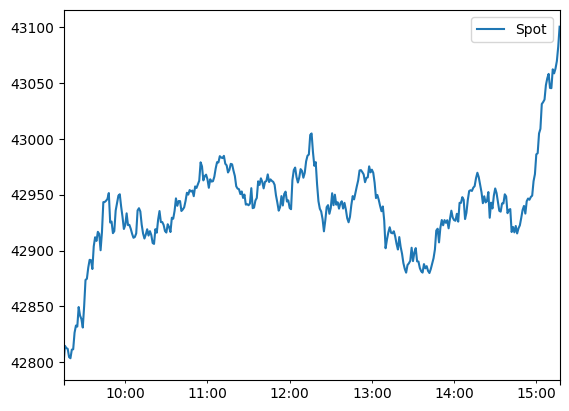

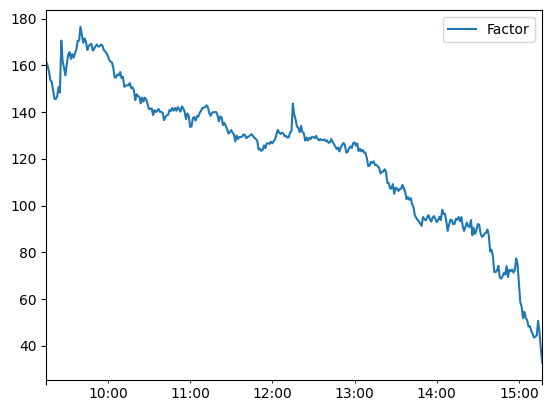

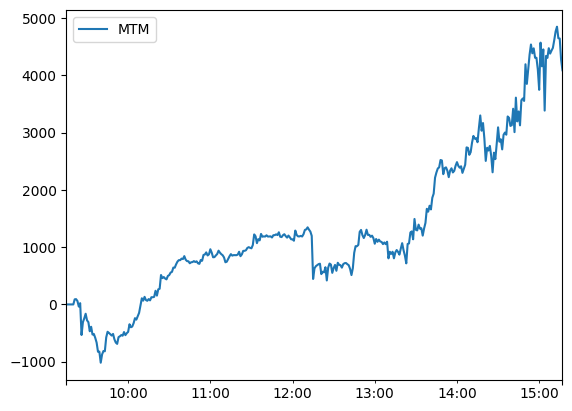

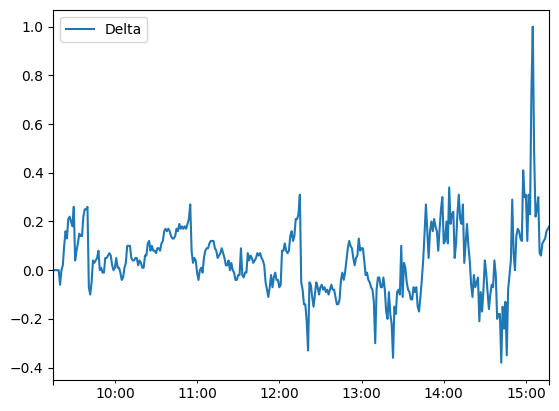

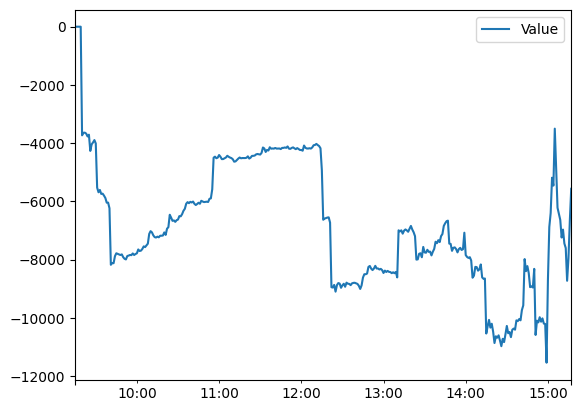

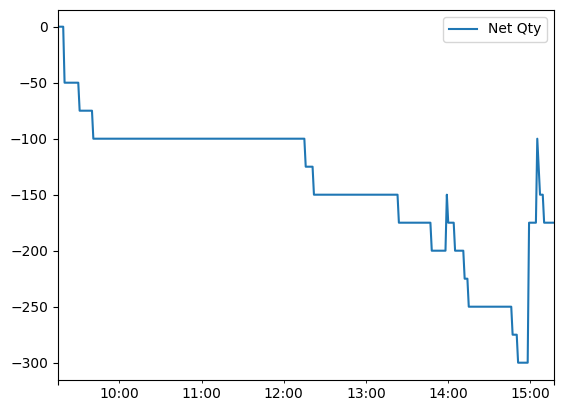

In [83]:
pnl_df.plot(y = "Spot")
pnl_df.plot(y = "Factor")
pnl_df.plot(y = "MTM")
pnl_df.plot(y = "Delta")
pnl_df.plot(y = "Value")
pnl_df.plot(y = "Net Qty")